# The Problem: Amanda's Automaton

- Each square has an encoding of 0 to 8, where 0 represents an empty square, and 1-8 represent arrows. Where 1 is → and the encoding to direction mapping goes clockwise respectively.

- Each step, the ball is moved according its direction. Initial the ball is moving towards the right/East, and its movement is altered by the arrow it lands on. The arrow then flips its direction.

- Your objective is to design a board state to keep the ball inside the board for as long as possible.

---

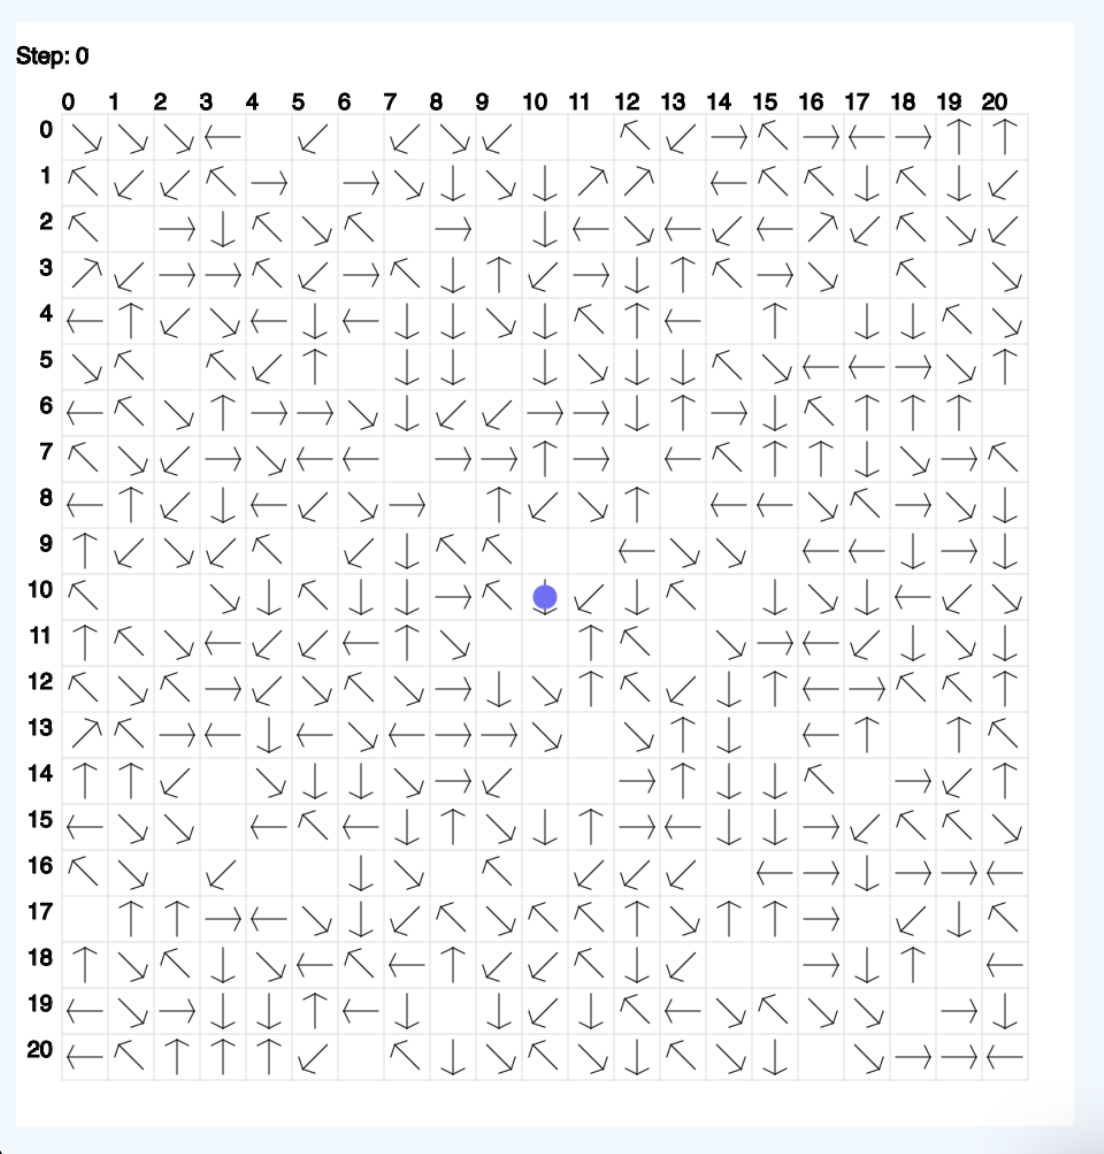
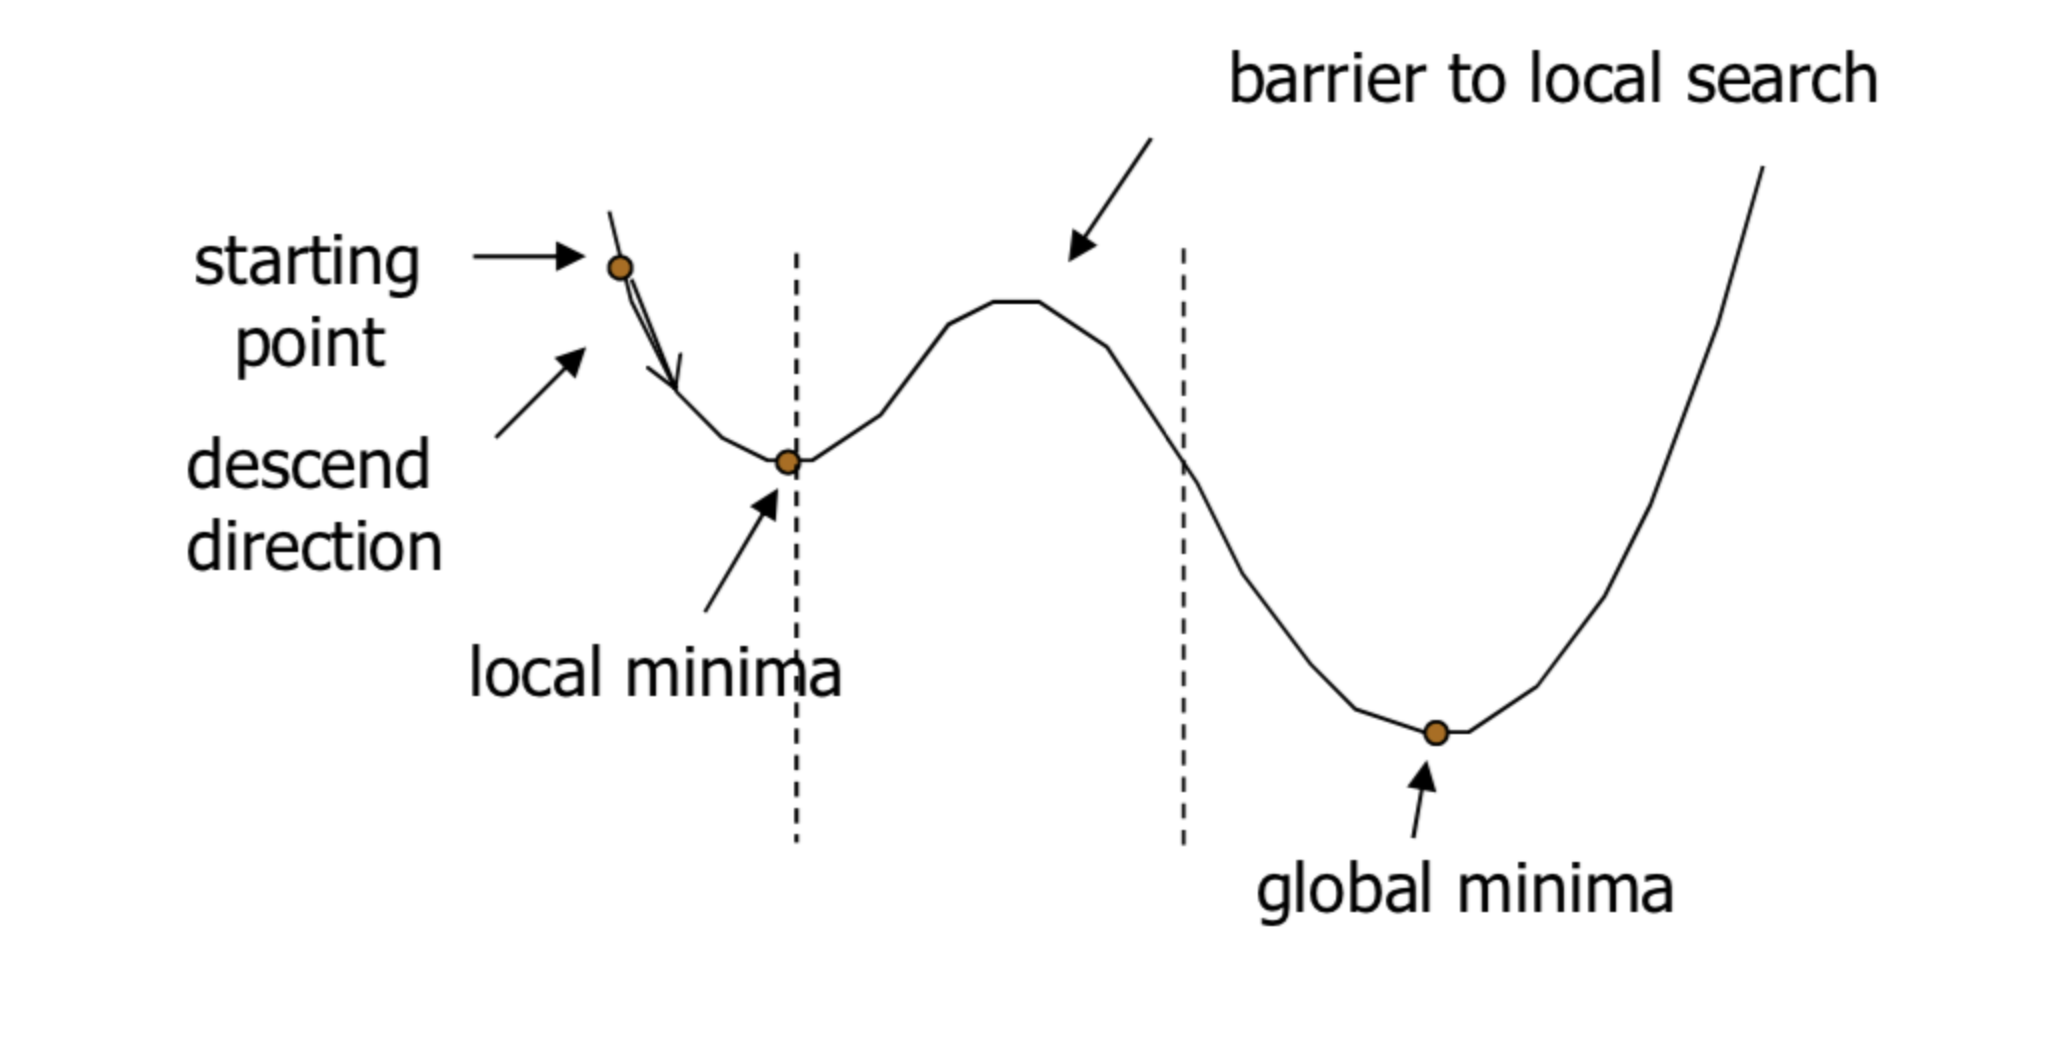

In [2]:
import numpy as np
import pandas as pd
import random
import json
import time

In [4]:
# HELPER FUNCTIONS

# Prints board in indented string format
def print_board_str(board):
    return '\n'.join(''.join(map(str, row)) for row in board)

# Function to simulate ball movement (objective function)
# Returns the number of steps a ball stays on a given board 
def simulate_movement(board):
    direction = 1  # Initial direction (Right/East)
    x, y = 10, 10  # Starting position (or any valid position on the board)
    rows, cols = 21, 21  # Assuming board is a 2D list
    steps = 0
    while 0 <= x < rows and 0 <= y < cols:
        if board[y][x]:
            # Update the direction of the ball based on the arrow
            direction = board[y][x]
            # Flip the arrow's direction using the modulus operator
            board[y][x] = (board[y][x] + 3) % 8 + 1
        
        # print(f"at position {x}, {y} moving in {direction}")

        steps += 1
        # Update the position based on the direction
        if direction == 1:
            x += 1
        elif direction == 2:
            x += 1
            y += 1
        elif direction == 3:
            y += 1
        elif direction == 4:
            x -= 1
            y += 1
        elif direction == 5:
            x -= 1
        elif direction == 6:
            x -= 1
            y -= 1
        elif direction == 7:
            y -= 1
        elif direction == 8:
            x += 1
            y -= 1
    return steps

# I'm doing data science on Amanda's automaton

In [5]:
# SIMULATED ANNEALING FUNCTION

def simulated_annealing(iters, temp, cool_rate):
    iterations_list = []
    scores_list = []
    # Create a board with random integers between 0 and 8 (inclusive) for the interior
    board = np.random.randint(0, 9, (rows, cols))

    # Top row: arrows pointing down (3)
    board[0, :] = 2
    # Bottom row: arrows pointing up (7)
    board[-1, :] = 6
    # Left column: arrows pointing right (1)
    board[1:-1, 0] = 8
    # Right column: arrows pointing left (5)
    board[1:-1, -1] = 4
    
    current_score = simulate_movement(board.copy()) #+ heuristic_score(board)
            
    # Captures inital values of parameters
    i_temperature = temp     
    i_cooling_rate = cool_rate
    i_iterations = iters

    try: 
        for i in range(iters):
            '''
            if i % (int(iters/100)) == 0: 
                print(f"Annealing {round(i/iters*100, 2)}% complete 🔨")
                print(f"Current score: {current_score}\n")
            '''
            
            # Select a random square    
            x, y = random.randint(0, rows-1), random.randint(0, cols-1)
            new_board = board.copy()
            new_board[y][x] = (board[y][x] + random.randint(1,7)) % 8 
            new_score = simulate_movement(new_board.copy())

            
            # Acceptance probability
            delta_score = new_score - current_score
            if delta_score > 0 or random.random() < np.exp(delta_score / temp):
                board = new_board.copy()
                current_score = new_score
            
            # Cooling
            temp *= cool_rate

            # Data recording 
            iterations_list.append(i)
            scores_list.append(current_score)
            
    except KeyboardInterrupt:
        print("Execution interrupted!")

    # Generate dataframe and save as csv
    data = {'Iterations' : iterations_list, 'Scores' : scores_list}
    df = pd.DataFrame(data)
    
    csv_filepath = f"{i_temperature}_{i_cooling_rate}_{i_iterations}_results.csv"
    df.to_csv(csv_filepath, index=False)
    
    '''
    print("----------------------------")
    print(f"Created file: {csv_filepath}")
    print("----------------------------")
    '''


    return board, current_score

In [6]:
# MAIN LOOP
 
def main_loop():
    
    # Adjust search space of parameters here (iterations is fixed)
    # Needs enough time to reach an asymptote, tradeoff between resolution of graph and 
    # how accurate/representative the final scores are. 
    iters = 50_000
    
    a = 500 # Lower bound for temperature
    b = 10000 + 0.1 # Upper bound for temperature
    c = 250 # Jump size
    
    d = 95 # Lower bound for cooling rate (in %)
    e = 100 # Upper bound for cooling rate (in %)
    f = 0.5 # Jump size (in %) 
    
    test_size = int(((b-a)/c)*((e-d)/f))
    count = 0
    
    print(f'''
-------------------------------------
Running simulated annealing on board size {cols}x{rows}
Temperature: from {a} to {b}, intervals of {c}
Cooling rate: from {d} to {e}, intervals of {f}
Total combinations/datapoints: {test_size}
-------------------------------------''')
    
    
    for temp in np.arange(a, b, c):
        for rate in np.arange(d, e, f):
            print("+===============================================+")
            norm_rate = rate / 100
            initial_print = (f'''
    -------------------------------------
    PERMUTATION {count} OUT OF {test_size}:
        Temperature: {temp}
        Cooling Rate: {norm_rate}
        Iterations: {iters}
    -------------------------------------''')
    
            print(initial_print)

            start_time = time.time() 
            board, score = simulated_annealing(iters, temp, norm_rate)
            end_time = time.time()
            elapsed_time = end_time - start_time    
            
            # Define the new row to be added
            new_row = {"Temperature" : temp, "Cool Rate" : norm_rate, "Final Score" : score, "Compute Time" : elapsed_time}
            # Use the loc method to add the new row to the DataFrame
            all_df.loc[len(all_df)] = new_row
            print(f"FINISHED: Board configuration keeping the ball for {score} steps:")
            print('🏀')
            print(print_board_str(board))
            print("    -------------------------------------")
            print(f"    Simulated annealing took: {round(elapsed_time, 2)} seconds")
            print(f"    Estimated time remaining is: {round(elapsed_time * (test_size-count), 2)} seconds")
            print("    -------------------------------------")
            print("+===============================================+")
            
            count += 1

In [7]:
# COMMENCE PARAMETER SEARCH

all_df = pd.DataFrame(columns = ["Temperature", "Cool Rate", "Final Score", "Compute Time"])
rows, cols = 21, 21

# ***********************
main_loop()
# ***********************

print(all_df.head())
all_df.to_csv('10000_dataframe.csv')


-------------------------------------
Running simulated annealing on board size 21x21
Temperature: from 500 to 10000.1, intervals of 250
Cooling rate: from 95 to 100, intervals of 0.5
Total combinations/datapoints: 380
-------------------------------------
+===============================================+

    -------------------------------------
    PERMUTATION 0 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.95
        Iterations: 50000
    -------------------------------------


/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5516 steps:
🏀
122154421554254354355
231311345732312102540
312102073103145021465
717523110265530152653
106465031055554436433
210223231031054520343
270400327107201534047
302711100364006403006
741021157717515357756
713230440742237057635
731303561115520304333
202134334622202036053
100031170700070170333
313577061175320720605
777650636012263701636
171047277560007200073
273707117165666077563
031271100505057777353
071744061616300161607
710504505756706046506
177155577176156727576
    -------------------------------------
    Simulated annealing took: 98.64 seconds
    Estimated time remaining is: 37481.66 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 1 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.955
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3657 steps:
🏀
212121235411532342113
302223213452323122526
217420310533065715704
171261535013101533005
310321211530247017623
733757001435131533253
232231131314713544457
101073553743537056225
777117121723507056366
171073150176560420754
731181346154314217646
230767111742155570563
101325702213352434347
371530021536503777126
371147045071605477146
071426763156066046265
313216841604361302367
717263610056711566357
131071500736563764537
211715047160767771576
077575761577675717716
    -------------------------------------
    Simulated annealing took: 82.06 seconds
    Estimated time remaining is: 31099.48 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 2 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.96
        Iterations: 50000
    -------------------------------------


/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4003 steps:
🏀
124214252153210053144
167411413222415554053
261722122231035505534
221030230702105545573
717671331115711525744
222302507213533123042
331703242110770063064
701613162341556167603
715302346337512376576
242503747727310156776
135004245531760562453
313377355357115440530
027150166031400157677
170277333767533177405
150700020751072406605
881007067164566370576
335731707377615005053
770477715076156364007
187441116067735603346
837150754766677675503
476371156675501610076
    -------------------------------------
    Simulated annealing took: 84.45 seconds
    Estimated time remaining is: 31923.34 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 3 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.965
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4680 steps:
🏀
233234402554425321543
122712221056123541540
311215020212710355305
721550215512531435005
120252151324274575546
114032013642004421057
312212415652053157306
123002611272157056766
213550033104205131577
102335470261240017705
863031712130360130544
226717624310535605303
630415046157674616767
372012107462045540646
110730471555702602076
141103111323437357667
313247277303316670157
131706777566230606677
331106661046757616706
172276151505515576566
757766111573750156765
    -------------------------------------
    Simulated annealing took: 90.08 seconds
    Estimated time remaining is: 33961.59 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 4 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------


/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4649 steps:
🏀
134321554342531221303
713021424032423213054
272410530277135302417
103022571302430440134
163256757541531471306
221077544673700173753
320672531743555340535
310310006441402733756
322710750675755452454
173207415353130565205
172207105731125313433
327304463410737027057
127765033630561767467
216534311570373671737
231071571155227077076
704671563262764060054
001075121152216067534
301710263061460707737
071571515707356601673
717617577467701576657
176715761566176115676
    -------------------------------------
    Simulated annealing took: 337.85 seconds
    Estimated time remaining is: 127031.12 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 5 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4023 steps:
🏀
532132232142354134154
215044404545002403454
231323311613153354144
102267101400110503333
332770303750347017050
712241710031127406053
135057066473760566337
131004613712731574137
772716236513226305337
710002100313043716405
133461675726307705575
222742303755756746573
337152311555542774677
722527100700771540370
225075603150661530057
233214631647611313767
377155737717156765666
162003115651535547056
111771057715616167435
617151050515576771667
111155636755156617717
    -------------------------------------
    Simulated annealing took: 89.92 seconds
    Estimated time remaining is: 33720.66 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 6 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.98
        Iterations: 50000
    -------------------------------------


/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3105 steps:
🏀
132152311434115055541
162531531402157431544
421056310211164314107
213073216151553012344
171105500052105524056
317153410242310563767
731131542425275467045
177153542671560305065
150320652306213174767
211025032003010553735
253377412525037473177
810671034613412075277
223441631642562057147
322604574011053160014
715474412122223007305
731121033676162106753
875526117317705670670
101575602166572612073
115645670447562054367
315557587671504660564
101671166517616757615
    -------------------------------------
    Simulated annealing took: 70.34 seconds
    Estimated time remaining is: 26306.03 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 7 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.985
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4511 steps:
🏀
323215555231534231344
331213333201503353073
722205375203306270640
103301212301243734057
475010421153757474537
212755542624070301705
702001100031576746374
221410220234056404646
313137330072032533053
233352426152514737467
204325610513334414506
370610237134771001556
721373731773174365154
130320500656074154154
150010332435715401335
110710770341721227053
323407187105236011575
317405315074070702256
315775717070750607555
707407562777140376215
171676027667167115774
    -------------------------------------
    Simulated annealing took: 96.12 seconds
    Estimated time remaining is: 35853.57 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 8 OUT OF 380:
        Temperature: 500.0
        Cooling Rate: 0.99
        Iterations: 50000
    -------------------------------------


/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4099 steps:
🏀
231523345415344635335
262221225232152217444
163365543441532450533
303710340523701354503
260223007353614574143
171037150023704713047
313070555031557717535
130541035701341717535
177133273113725766063
072042663431133116753
310206631173100370563
781403071200757021357
110024443077177624026
317311657361601331164
123150237167144005543
010231556104641377135
100071567156400037716
710272215771807361564
107110000051570507067
771077076167050666715
757715661105567615556
    -------------------------------------
    Simulated annealing took: 86.71 seconds
    Estimated time remaining is: 32082.9 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 11 OUT OF 380:
        Temperature: 750.0
        Cooling Rate: 0.955
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3585 steps:
🏀
211053425225312134154
102150325653424115574
313532045362371447153
022462044343360146667
712150213533446154466
112121362410734703505
107635065315457221635
821506063711760112417
311524555051055564664
221237151737456053535
231734325621403456356
300631110531215347735
717361003253056013667
324441003410024706667
788246537415274116745
100436342640062323556
171572545353727761624
325100717776105227533
715317715651156075677
871500157150606767106
150717615056616665766
    -------------------------------------
    Simulated annealing took: 79.85 seconds
    Estimated time remaining is: 29463.14 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 12 OUT OF 380:
        Temperature: 750.0
        Cooling Rate: 0.96
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4666 steps:
🏀
252413235231534332433
133232317353103773746
371006152053764442424
717250523275400401337
742003330241246573175
743022342067460057057
113101021106606531566
107623310715715370567
713632733676015054646
222045232600530362334
133706313615575017773
222420643750552734273
717507603433610773053
221365155570644442460
310310043175030047737
724170415476315720376
372045156150705560154
177717303105600607605
217100075077011076773
741536750768101661557
715056627155566155765
    -------------------------------------
    Simulated annealing took: 89.68 seconds
    Estimated time remaining is: 33001.56 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 13 OUT OF 380:
        Temperature: 750.0
        Cooling Rate: 0.965
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5524 steps:
🏀
723403215434123115144
210227403403221524507
133260301317715334023
371300223030427305545
371160430610170344324
723320330305556560700
173630455377135456053
103434073105740546307
710073104123605740546
132450061333157534664
217031077305757005463
271076171160606440053
304371070205272401577
720060541556304616740
270353500007540745737
177761007366470667775
324660402761117316666
721757707501606005657
107670736057056707546
407675074725710570126
175717761567671115647
    -------------------------------------
    Simulated annealing took: 97.86 seconds
    Estimated time remaining is: 35913.47 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 14 OUT OF 380:
        Temperature: 750.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4115 steps:
🏀
722255413252421341337
233151231442341053004
332631502161023430077
722603141734431506017
132640213163453336537
274300310310744777376
326031365232505577754
117702153105317456644
237473630537770230573
772247237340155601544
710021032530223255205
574434673773775564033
242730350077163515423
704254154716115270053
821310453602320036537
117717133476306246366
221503133270106113566
313531057666602160353
771370704074077507266
107641776710715606207
757667157177156656176
    -------------------------------------
    Simulated annealing took: 83.9 seconds
    Estimated time remaining is: 30708.35 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 15 OUT OF 380:
        Temperature: 750.0
        Cooling Rate: 0.975
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5696 steps:
🏀
255552123133523154354
117331520342320451535
815023315024530333246
154276035530421375653
814302105300465454337
715324031164050115706
810752507313204430576
852135027670355472357
131103251675767305756
227117403157601144056
300231537375341700533
371750176017055333640
317434474107730307704
321071131035470572675
720716510656017660646
707231703470155255673
831530402044230540146
172642071501570157565
310524550632515654157
710646277017105611057
177156716565671115765
    -------------------------------------
    Simulated annealing took: 133.84 seconds
    Estimated time remaining is: 48853.1 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 16 OUT OF 380:
        Temperature: 750.0
        Cooling Rate: 0.98
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5001 steps:
🏀
215515431542155472544
212215233522533214533
222121501532470404457
704350347153271343447
263031551530545560716
313572571234577704305
221072025605546001053
107175437707333441360
721021572151717056667
230440336072031433464
042367151702527600005
353753100132637353664
100022411154675360333
631031070535570537336
173711213143070746073
777234377104740270701
210702717074604461606
317571011057033105370
034260707024767630077
710681066076765070760
107677567767101767167
    -------------------------------------
    Simulated annealing took: 95.04 seconds
    Estimated time remaining is: 34595.42 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 17 OUT OF 380:
        Temperature: 750.0
        Cooling Rate: 0.985
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4240 steps:
🏀
101231431143153234314
321505223523310507035
325234241435032331533
117503320602573054577
213140735303531034057
175271023117132105444
310715073315301574575
731102171652770305353
713411334274275774730
727531561154053541537
132150003176024424375
210006703450754135035
734604711322264741663
271615567775556660537
304303036110530534705
021054105727027323756
710710503542041203414
173107576450767536232
110056615156106160535
157627562052156501677
071561761567576176157
    -------------------------------------
    Simulated annealing took: 89.36 seconds
    Estimated time remaining is: 32439.42 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 18 OUT OF 380:
        Temperature: 750.0
        Cooling Rate: 0.99
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3959 steps:
🏀
221532215244315325413
710223103033433030535
221750211620223114464
242602013210527770345
777101005226335477766
142121527337674354444
225022770562301037405
330102612570105245673
772777105615136337447
026271113137615456066
173060632436536455335
217253131521556730576
071000465103330716563
321354307115772743563
701716006071000527007
821501005726706776566
230604715003133166755
031471140701161520565
376610307601505657203
067577105670670615636
715776710555556656056
    -------------------------------------
    Simulated annealing took: 75.84 seconds
    Estimated time remaining is: 27302.57 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 21 OUT OF 380:
        Temperature: 1000.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5103 steps:
🏀
534244154625231404215
273262512341555647416
300301031054345245454
713023203612321430005
724070307407050505533
131006367650614673503
373007177215731540473
227107300307520057147
100415211061315336056
303123450713137574356
710550142437753352535
283527277677701605373
137127224521142017707
317517210315620471246
317326071620373170074
771000720223527675764
123237100053006520567
153317367505704117605
177771775100570131756
125071511775055667671
105660617155761155673
    -------------------------------------
    Simulated annealing took: 88.74 seconds
    Estimated time remaining is: 31858.83 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 22 OUT OF 380:
        Temperature: 1000.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5088 steps:
🏀
222123210055534431153
371315233330154214433
713552254702354400775
202674505544031301744
131550753341153543063
623715500241700033540
210003120403525173047
302031120112035360303
261070446160505304066
107222456400305005605
710063047561307326336
222107355177776376057
172425557175575715764
717025002552411600447
124313417726607077245
156467631513476472064
144661072505704043367
331310710300470765705
717057577105646623665
245712755706171567073
717671117671557615767
    -------------------------------------
    Simulated annealing took: 93.13 seconds
    Estimated time remaining is: 33341.66 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 23 OUT OF 380:
        Temperature: 1000.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4270 steps:
🏀
214253151222144351554
752105333415523533353
135033222641441340440
277372331052072030534
701222302743067475705
225502721345407354053
130252406272215575366
371131045502774354775
710672677141146270544
175310350404042470053
157723347022137715647
111231774742135602546
310524246131243556464
146530160160657620427
844715577100270533535
100230417410255271753
871515714367054170334
210171150715570065674
101711710165014074074
715156507715710762064
111661576671157665767
    -------------------------------------
    Simulated annealing took: 88.79 seconds
    Estimated time remaining is: 31696.55 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 24 OUT OF 380:
        Temperature: 1000.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4279 steps:
🏀
321231504243211523153
120212234342212534440
220524101053331705375
331030323063102001346
733577321530464643044
723202315302333753030
237215741715710547773
172304134071171553477
227711703362324102057
710760354401157010744
373124536156330557234
227117161555301721573
170022270702757576057
331006707531506060566
773500807737600705564
127173065076153141464
153771701160124724275
845373055154776431364
770774110786115570557
177151377610736157205
715177570656621761716
    -------------------------------------
    Simulated annealing took: 88.13 seconds
    Estimated time remaining is: 31372.81 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 25 OUT OF 380:
        Temperature: 1000.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3976 steps:
🏀
231523111534142215534
315211053604553331640
012316430104532153156
731535350753574143154
722521021174113100505
275733155765310142033
103233311017311560474
221507033330776554203
316177357175061054047
710741273357723603005
122105374774507171556
325344752272035224214
320324106362077366057
135020715663747567425
270720230157235305666
370717575657667046735
717775030411547707376
171555315640711164017
674711505057670666265
211100074701016607767
150671150555566566567
    -------------------------------------
    Simulated annealing took: 87.74 seconds
    Estimated time remaining is: 31146.32 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 26 OUT OF 380:
        Temperature: 1000.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5179 steps:
🏀
224122522115333111154
106525023432135412455
312247210553000540454
122100201761247035415
357271500743151545054
131362334060151015403
171150065030505335546
352103103035240105665
811023157030462436157
222371725654604616405
777077153660565715644
121653031053166306333
226370210601116560047
736103066432107333005
772455600616676051706
226601430677717632636
374811060770566672603
711033737115705054077
145777505610570761535
143547172616660664575
177761717674737716757
    -------------------------------------
    Simulated annealing took: 89.11 seconds
    Estimated time remaining is: 31544.13 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 27 OUT OF 380:
        Temperature: 1000.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4591 steps:
🏀
212222105334221553442
106370133474215455333
123020153607507473574
712464404061220116473
212126115113030152453
102746011335271140137
123610103130373007065
302605345725717761064
071171544007137133405
767726106111576240305
321500001305056754544
120351153346306570553
110010352715566370574
744143130415100560005
223137371517470305745
300502210504570301057
210457070352600307560
237531560542857576057
316077167107603210566
177761067177771052005
167157711167715167156
    -------------------------------------
    Simulated annealing took: 87.68 seconds
    Estimated time remaining is: 30950.06 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 28 OUT OF 380:
        Temperature: 1000.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4452 steps:
🏀
133154211555274154103
322315554204501411345
125022153301540531054
117553031021061373315
321230502411137017645
310077714441057546744
772032132315272423533
113603017065400237057
235373200530240376775
711371567206154672466
273711571407563013544
102765332171750157033
710715000710117605740
103113167530705652637
231000575734275240575
070547077570157602676
343503150057115266463
345007111110055564757
732775715047215362606
177777617756500666616
377111616176177756156
    -------------------------------------
    Simulated annealing took: 90.91 seconds
    Estimated time remaining is: 31816.9 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 31 OUT OF 380:
        Temperature: 1250.0
        Cooling Rate: 0.955
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4242 steps:
🏀
231522315341412154214
302241541034251015437
724223505206454350234
733130307304553407433
122342025300340540323
220725546352465572447
377023131321053264535
261075631571533166456
100710563410373005673
773521020744311634646
127150603423355461053
171002307217530405766
422077631537231116156
213477020766065331565
177742115605774105647
222131324631570575275
210570322170613660664
217013171155461167063
170547060276004711563
747105777107766177543
771576571775167615566
    -------------------------------------
    Simulated annealing took: 87.5 seconds
    Estimated time remaining is: 30538.9 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 32 OUT OF 380:
        Temperature: 1250.0
        Cooling Rate: 0.96
        Iterations: 50000
    -------------------------------------


/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6435 steps:
🏀
310332515524534154145
222152122702303305053
130421541005024010533
372147115202603154053
327150352015700357420
730735031136020534603
273423042105471301747
002550611617305317444
171000031105355737246
310003150217716073753
170371550771665302053
284063307530535602437
162307335061362037574
211231073217701363375
152312053271542307057
357166127550705676065
171074403700650656763
217342007166715260447
401704676707600367635
071156656506677601656
115016776566155677156
    -------------------------------------
    Simulated annealing took: 112.64 seconds
    Estimated time remaining is: 39198.47 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 33 OUT OF 380:
        Temperature: 1250.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3992 steps:
🏀
225355431110554433435
750031222633434411343
277013007405317431157
302150230502255413564
721630351511313207504
137006741330030337705
216217107251070164057
153475447103703303546
353377721117670705335
175343140350611153703
210353771707211130753
817743071137437000153
321707320412036357057
540774717636712605766
206641522101713375133
813102676770612212575
242034350056216560334
702317554661775107637
220356271336768137573
717573700074177165057
715767677763715765166
    -------------------------------------
    Simulated annealing took: 83.51 seconds
    Estimated time remaining is: 28977.86 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 34 OUT OF 380:
        Temperature: 1250.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4616 steps:
🏀
215333401523101511524
231020215420035355305
303150401330105043035
321662521502055020405
720301116713645547643
103065252535453054057
175335554404275046444
227703312512541575425
772273021323711050345
221004003715754425335
343110367530565347377
337103103652234726644
312311061077007654335
720330503515565454073
776736771557013130063
106100754322307304707
211070236373636760466
350710554115071155675
034150214074153356053
770157115760705716007
157571577567607573756
    -------------------------------------
    Simulated annealing took: 98.85 seconds
    Estimated time remaining is: 34200.98 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 35 OUT OF 380:
        Temperature: 1250.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4562 steps:
🏀
144431532372243153414
261503003123174400534
215310504127002124357
102712724151101580534
311025503045013400056
113710710534170353055
107172171503415715754
317262311555730166405
821221655327656153357
132311750745611563454
224320401335334547733
710607235644701724440
221631171140134240130
700273540423615403006
121350323150072232766
437703775007210561607
106475115477070201346
313150501600750576645
103167162456240242057
171007167641581666724
715761567667161776777
    -------------------------------------
    Simulated annealing took: 89.72 seconds
    Estimated time remaining is: 30952.28 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 36 OUT OF 380:
        Temperature: 1250.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4564 steps:
🏀
213354252354315331543
331443174032231041544
717124302105242011705
125346422313033535060
210222430175340307473
222566252323730724455
423650341450411747313
233771323737713707475
303200225315017036356
771500322763012166774
310715334433773763577
307131777317720027705
175377715103173544444
317150600372205356204
131767410307113766463
103124310526401160057
317310777101555215605
107107571076555261636
104271215660503053057
074240717017776071725
710157671566357667575
    -------------------------------------
    Simulated annealing took: 93.21 seconds
    Estimated time remaining is: 32062.61 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 37 OUT OF 380:
        Temperature: 1250.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4553 steps:
🏀
123532213315322015345
025353031042534412057
247122252152302532146
771523002042153065745
844100603034311533153
312367043453134543317
770327563730433053754
722722413162717337473
171030236043015370054
213171702373565701663
223313116663454131153
350310664543600477557
737031731505320011325
173775150432735035666
337071055032055727434
074661004160201546376
710003757015776055713
114703105041610560706
350371070350615675675
137137740773617666157
016717167156476461156
    -------------------------------------
    Simulated annealing took: 95.26 seconds
    Estimated time remaining is: 32673.23 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 38 OUT OF 380:
        Temperature: 1250.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4136 steps:
🏀
211231152415342155544
312153553431516432507
331055435311521405547
772211105021311503746
223315302211225537035
100357771705415520673
163771323067143765477
227223153151615536357
376477616344235553737
721024173721057234037
137656137177163305774
223100317225337777405
310024116310563435373
710530462750747277753
107413132711135773773
177311515370370120266
771021742507015307056
070753110521060742675
710771720311565600563
177110557170705710607
711167015717656115676
    -------------------------------------
    Simulated annealing took: 85.51 seconds
    Estimated time remaining is: 29074.45 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 41 OUT OF 380:
        Temperature: 1500.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4537 steps:
🏀
221531322145315331554
310617442051234001534
331110052443102153470
776332652060315360057
102613115574005345575
171253312001445634356
220520277115556753765
717100235035734764153
172771575103330503347
822627500213531153566
700703500171777305755
821721470077520346062
210217121556537720570
222461016611761133054
313016317151705765653
137607775121560206477
172077462217055270756
313556012711701057653
033107701115473661573
771072506611553061566
157756576155665737765
    -------------------------------------
    Simulated annealing took: 88.47 seconds
    Estimated time remaining is: 29990.34 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 42 OUT OF 380:
        Temperature: 1500.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4032 steps:
🏀
142152211132153311544
221052153354310142545
240242027145424172443
335021132523373550573
207135211540021307540
105225763571075055353
171130430653767434037
713317571553630333045
117165315035400474064
314277722235605755333
172112343267605324533
313611000520753007137
821632227367607713376
310242100524375307766
332503537633710700273
231507242417601675666
235047024611576017554
030707320154711712066
037571157610616107564
041717371140617406553
710576577157615671566
    -------------------------------------
    Simulated annealing took: 76.01 seconds
    Estimated time remaining is: 25692.84 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 43 OUT OF 380:
        Temperature: 1500.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3722 steps:
🏀
215442123423552415534
175534423331371543203
311324275723023147247
220215732547040347405
101504157150275570776
571150336037142454446
310024673130346270053
131346160021153015467
302433541113334030056
827126400411077430575
323150341135770524405
577134077163200427557
210077423557460103355
131157675064606622057
310004070245473621734
170454017861573767676
284024155437313075473
730742576075707126077
710716023650576506367
147773667157177170577
177577615771767715666
    -------------------------------------
    Simulated annealing took: 77.87 seconds
    Estimated time remaining is: 26242.11 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 44 OUT OF 380:
        Temperature: 1500.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4115 steps:
🏀
142011111534212155446
222155421252231042454
132133410054002622474
375315423153103114607
725341210310563016044
137171202320070430776
137704640310631735053
222025322311130577007
263044133736521314576
377775772626073260054
721007007201053115405
123254471115313000553
357336207573536624657
175070475156267503446
152045046311575371354
100303461531670773677
745871017340064656013
313111506776175457166
707101406156015212605
171006004456765677156
115743771576177615560
    -------------------------------------
    Simulated annealing took: 85.83 seconds
    Estimated time remaining is: 28840.16 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 45 OUT OF 380:
        Temperature: 1500.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4279 steps:
🏀
215044210102415231244
212154252100546153073
261323353055554430453
321222030105424700547
120210010223415174077
136037262150513153574
257671561300653535605
222810602017315343373
163003365034057033640
350253470642427237637
771777315577371670576
212721053131705076070
106202737630466227764
745504107373727634677
222730056071071773054
231730704517021113675
373373415005407732763
373757234316075270603
371611750375371027053
765247177160615755667
177661767547610556656
    -------------------------------------
    Simulated annealing took: 85.67 seconds
    Estimated time remaining is: 28697.83 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 46 OUT OF 380:
        Temperature: 1500.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5150 steps:
🏀
112415341142245415425
220462013223353411543
271513130276240277055
302325700724037441564
820620265413700020344
171000300320215574035
310231715710540330573
246714216135574600146
173714044350774074644
223225105757753677637
213003573101413740470
431503441421116415640
572750455326405400057
213707115536252256567
131073001070754430526
220457003315242437643
373104056133761560564
721070432361531537003
715741007707030715705
101610035576717571566
471056717656571711067
    -------------------------------------
    Simulated annealing took: 98.63 seconds
    Estimated time remaining is: 32942.76 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 47 OUT OF 380:
        Temperature: 1500.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5830 steps:
🏀
222152315331313432054
370333046043530502473
321016411056715742453
220271175171055441547
115007203545500565547
210710203105305403407
312502105313015547626
221503753133141054464
310737215377223005303
710032353764055576704
212100361055412240536
102025504563450535157
221206364057333754445
303613736505775352054
227157306704153647533
135031171170356266707
370353037260652501546
717156750057211556765
108107131506710030553
171066710056151610626
757115157711156756576
    -------------------------------------
    Simulated annealing took: 112.6 seconds
    Estimated time remaining is: 37497.01 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 48 OUT OF 380:
        Temperature: 1500.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5880 steps:
🏀
315014732313444215334
131515403031330233433
212310157073054557457
215274273147514740475
107072700550614534056
728473010550307205544
433757702741503546057
277777221053373013344
302110000225755540573
770411115065533037647
712310350413017464757
821026445373301133547
133103311505736373343
772304417461515340577
713475007035700777646
131310043710533004054
311332701107371562364
133750601006144064233
171130256071551760037
711050757162060566066
111737576715567610567
    -------------------------------------
    Simulated annealing took: 105.58 seconds
    Estimated time remaining is: 34841.06 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 51 OUT OF 380:
        Temperature: 1750.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4940 steps:
🏀
251523133215421053104
201321305105225444254
107546412223115373156
121142054230437011654
710336605250735153435
711035003073202735646
104273550340734605342
177503610552717753054
822150272155533553135
310042246231153777753
732576641021160000545
277731552562755557663
102410640664053067634
771006360076713261602
126210243060403266376
104162725653677005753
710721053056051600054
044714604203702070766
025275716436502453607
715460616111176676274
171671777160716677556
    -------------------------------------
    Simulated annealing took: 93.85 seconds
    Estimated time remaining is: 30875.23 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 52 OUT OF 380:
        Temperature: 1750.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5613 steps:
🏀
212253415221325005446
322550115640623142435
221030242101562060570
100205333737010571703
715003040211575556646
110407240315253654334
227350610564350552073
100271706121715715763
335071125563132700554
710613533675565556605
174507507160333636153
213575037255670500057
150225105030013746066
147300737647005543564
352054713715747530005
758150776601576157366
121700776175715101443
241007100155641777137
737171410200645542305
137717517356615607536
757115556176155676717
    -------------------------------------
    Simulated annealing took: 101.99 seconds
    Estimated time remaining is: 33453.27 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 53 OUT OF 380:
        Temperature: 1750.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4921 steps:
🏀
225221214431553341543
730233234324210523140
712750305740455443323
125062073032305730764
127243053075045570335
227331530204263654405
331075621301561630053
721274277333011532345
170033066277131407565
240714331411365705735
107223037670443772756
812415710010435470544
216027136200023214003
134111310417637160153
331003307337607466603
373101714576421366774
320073181055770055305
107312100042463600717
203756505705637670665
375776446576110057653
767577726766771765676
    -------------------------------------
    Simulated annealing took: 94.93 seconds
    Estimated time remaining is: 31041.11 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 54 OUT OF 380:
        Temperature: 1750.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4809 steps:
🏀
312315212142525422644
222133242523520555444
222702752220523460073
221225053470150201533
300235210411300056757
723357306543111553333
216260363213333137576
106711717736333747076
127771552304714305744
342127455255530253037
350044241537324330050
352410701745713015660
711031504715537460477
718310315403105073705
271110732275030327356
100703701350056015314
124370470103640722735
821007027555650206573
315631031076357716157
171570754073777100566
677157673167671576655
    -------------------------------------
    Simulated annealing took: 96.4 seconds
    Estimated time remaining is: 31425.52 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 55 OUT OF 380:
        Temperature: 1750.0
        Cooling Rate: 0.975
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5101 steps:
🏀
221452415323210544545
331133321052215524541
221522027322103274344
100323035630341253770
227630602102503040053
332477603027056565044
324250263312101544074
222205707513015640373
133630421740373015373
377303103073305335647
021031310513300577037
771704563131556077007
763571343153700576136
127770313273762170636
613360746755646672057
177357740741417613666
315747110424001727477
310721007550040705776
737104071770707600665
116316710110612074633
371576115646617666767
    -------------------------------------
    Simulated annealing took: 99.42 seconds
    Estimated time remaining is: 32311.44 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 56 OUT OF 380:
        Temperature: 1750.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5664 steps:
🏀
211335212221541411544
731013411064700132503
310250521505554402545
123120750725703306754
230220104057234754034
025310061413102013003
210716505232000537603
171021761433015134373
711600311100534371347
106700341637270270206
141003105651370370056
322277447073713155664
777321053315220005637
222165007205775656656
217103025044760370164
703113401466531077663
315771076201560060663
712110715576053241607
712070105673704156266
104677600111571201566
077155677110015676505
    -------------------------------------
    Simulated annealing took: 102.19 seconds
    Estimated time remaining is: 33108.37 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 57 OUT OF 380:
        Temperature: 1750.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4783 steps:
🏀
321101152142154434153
100233311524034152433
212104013223105475356
271015523620213603664
301353703234310157373
723173215002615414246
170722303506030153065
102150657263477267355
310031757521770557645
131072131607216730057
177212500357017001324
522100755362435773033
100371517605712430405
521750602016702557776
150201037301575237463
777472751316562775607
174211500675404653376
221425546014670255766
013271527762771256607
715312766626757076656
375556771155555767156
    -------------------------------------
    Simulated annealing took: 93.33 seconds
    Estimated time remaining is: 30146.29 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 58 OUT OF 380:
        Temperature: 1750.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5579 steps:
🏀
221231541243542222103
710204523231563433005
175355340214770240056
102644571105201355644
717013105322040154033
233500707032052117473
731007021115637354547
101066571202411634035
377360071504220340305
710327103120532330543
171104124312720521057
210223312023743005734
131427732715603542574
767100071531156360177
240761776042270537046
731757250604070677765
112200340375022056643
211537707611305160467
227371507084606071544
747717401775070067603
166671771557715747716
    -------------------------------------
    Simulated annealing took: 104.97 seconds
    Estimated time remaining is: 33591.59 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 61 OUT OF 380:
        Temperature: 2000.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6662 steps:
🏀
221532441342151421313
310213023152321543533
722261420315557055464
112211160354570244635
243304631421301075356
131330703555334044030
133315057304066006456
107371615701170746057
337762506543200545465
071500021155754063054
710004716750540207134
177110615504715226303
210032701770571735573
604310040400256273053
233135541756244353507
100170776100104335666
710217571156070722056
100631260062160601565
247250747016307516057
306013661026576710566
775566715765711515657
    -------------------------------------
    Simulated annealing took: 117.61 seconds
    Estimated time remaining is: 37517.62 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 62 OUT OF 380:
        Temperature: 2000.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3812 steps:
🏀
121425541431512301053
221240725207432530435
335002101425615105705
710626642726507505646
172216741546045262646
210212010577657054057
622462102111051401334
127505310601275762105
321361521011400211576
120715003057205176053
233355615103760157735
371311505313101600475
331500771104337771753
331073111121150636433
737213534003764057146
710271141521621623054
721065576500755175465
171311564040577566053
111250045320650104737
241017507707777016675
777011176176715761156
    -------------------------------------
    Simulated annealing took: 79.27 seconds
    Estimated time remaining is: 25206.81 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 63 OUT OF 380:
        Temperature: 2000.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4126 steps:
🏀
142311124523256311144
123051234110252145044
270135354322334341077
302033054330074733343
071073603131110156057
027410717202034717534
717413772501605250575
772321551731153052573
772050332157127153347
171047777731057620054
150327152735355335756
223735032600766730533
777573775016447773046
710753043724347560665
131104761337757713157
377710107775602606755
711022115055175670567
344117151563040757645
710211500115527101566
711017610674601700337
117715556611110557666
    -------------------------------------
    Simulated annealing took: 79.42 seconds
    Estimated time remaining is: 25175.7 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 64 OUT OF 380:
        Temperature: 2000.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5916 steps:
🏀
114254435424412314314
315400347054222454434
123650025454341535453
210215040233123355747
371002656140345742440
120637361015305730366
210715040132005670134
102120747341141575305
321700063031076641703
226117103765454364770
272427323151553007753
023066671141400056403
030030445752576620676
207475310702560575256
831034500400201600464
337713047250776050737
377104756710340564264
317453733018600314233
331042175760660726466
761707260267357616605
177173617756761671116
    -------------------------------------
    Simulated annealing took: 104.23 seconds
    Estimated time remaining is: 32937.97 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 65 OUT OF 380:
        Temperature: 2000.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4710 steps:
🏀
225435312211522111534
727215222243120052353
220213234233121577137
206301466307447154000
313061531060350360076
753533725430160301566
737422210074316003533
132440033204730540370
203077075610053040347
370215255361767524754
717306361707437705766
137751606635424560333
172750431061005554607
310472235754525054276
122542153575042074076
315710357640610265767
103471536500070763447
217011046101560763235
104015301531557004666
775071575561704766507
757757150067766111566
    -------------------------------------
    Simulated annealing took: 88.16 seconds
    Estimated time remaining is: 27769.8 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 66 OUT OF 380:
        Temperature: 2000.0
        Cooling Rate: 0.98
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5367 steps:
🏀
123152341542421155553
710031023030665445340
271003230202310144334
102500624341033003776
332021382064407013467
313636012075311142737
320657625610112304447
731537350133262362075
107227025230251700554
832110442515312033505
712031023154530520557
222503716430774037605
173031021500020001536
313610047373111176053
331303151566602060775
311067000075676263336
015711425750153550003
711507457111201507666
711271576007755356262
104311767771560505766
077176575617615670166
    -------------------------------------
    Simulated annealing took: 98.15 seconds
    Estimated time remaining is: 30820.62 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 67 OUT OF 380:
        Temperature: 2000.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4432 steps:
🏀
315221241335554353154
132250244234301131334
223632302100015215533
710231011001054530533
227105067303502355313
322664110760365652037
725036271566115730326
226106321313733473073
170327340315731760566
710000022521116635345
242076336620706570053
103004760215660156005
221720715072517300536
713237577715505317605
103575347107306715444
171477721071560676665
717224250267321062767
171750715610512701546
310760671667121620154
326100553166767115616
176767111566771771556
    -------------------------------------
    Simulated annealing took: 83.7 seconds
    Estimated time remaining is: 26197.27 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 68 OUT OF 380:
        Temperature: 2000.0
        Cooling Rate: 0.99
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5682 steps:
🏀
342521054234104231323
024113105342315374333
330221243157033243577
176303400315130305336
102525114013204543054
310000237535505073056
725711314502300605006
100710736223364470056
131071771015213052034
713242100116053057605
113100342252733470473
343234331372716034646
757230732105720714005
761007152440207560243
131036072525616707377
153336712146115130266
110750541531606072075
317400225160250560566
311070045615660625607
317710500466710005766
116117615677177166557
    -------------------------------------
    Simulated annealing took: 105.58 seconds
    Estimated time remaining is: 32730.16 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 71 OUT OF 380:
        Temperature: 2250.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4544 steps:
🏀
231523052315221532055
301211152042250305153
760203120073013003537
131714260150210557766
213122210320334435464
100223736471001570056
331030035405737316363
221102772613405242537
175335221511620055437
711001350032533340177
103334765370555735675
827712735777015173055
726100456156145001360
146304350745560770573
233772200770705776005
237615401547715015364
772106031207101567753
314610105564106271660
316047156610461560057
718176666577577641707
116157771005761567156
    -------------------------------------
    Simulated annealing took: 92.6 seconds
    Estimated time remaining is: 28613.92 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 72 OUT OF 380:
        Temperature: 2250.0
        Cooling Rate: 0.96
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4425 steps:
🏀
141104333103201313214
221213425221153231454
131221561463346553354
376250300450324157603
123525520027033757057
270307150412575510546
702121104215354454035
122002715207735640005
212413215237507370546
173307152622057054543
712315755315571532547
100045566374515273375
231100371100563407726
737502375424655337573
124271072041157037077
755437776507156705466
871416650706010542565
811812570605736644305
371101741071500760165
257260105716060561603
115767271556167655676
    -------------------------------------
    Simulated annealing took: 89.09 seconds
    Estimated time remaining is: 27440.82 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 73 OUT OF 380:
        Temperature: 2250.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4984 steps:
🏀
311005222315553413205
232235733013110415443
302211050403410520130
003503720310531304577
100325115021303015757
373625022070105564073
222210270254142305666
103036006534342350634
340706273705731716604
717150660532052734733
235054147535743415717
401351755030170156364
473102056547560357575
212100007105307607616
151007755016512376054
110334120750554155324
344120127152761013407
377207015672155347626
717071720450776505654
216566771677571560375
157765105666715765617
    -------------------------------------
    Simulated annealing took: 97.78 seconds
    Estimated time remaining is: 30018.25 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 74 OUT OF 380:
        Temperature: 2250.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4451 steps:
🏀
123232123402310533153
310262423310014755305
332063070133274134061
722104240470606205634
733221560550330357735
177350224131105534005
127316300472775501506
270046230050521301476
323103300424500557453
367527425301570534464
303637321151270015235
721171565771045544334
170672002315565300057
210410323211535717335
231000003160017166704
300114475505356301663
043373113206512116137
730211003152112600775
277074555432670570656
174717715611115615606
717176176555771115627
    -------------------------------------
    Simulated annealing took: 85.08 seconds
    Estimated time remaining is: 26035.8 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 75 OUT OF 380:
        Temperature: 2250.0
        Cooling Rate: 0.975
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5898 steps:
🏀
354431323434215412144
232313533352224215343
313023762036711436047
173235530531103453034
222350354503550421575
310715772513130407073
231036211757300056627
237233706134105360537
302302115233135733054
323320221617553065201
777330737531355434066
271370426075730203467
173741072315603370124
313103610327313272605
273012060327517060763
104115057615505761607
772400041650332705775
161041120240627160756
107715265207015735655
711057166476077570576
570571761763771057653
    -------------------------------------
    Simulated annealing took: 102.03 seconds
    Estimated time remaining is: 31120.46 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 76 OUT OF 380:
        Temperature: 2250.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5411 steps:
🏀
212323225213155534154
316737317322423104454
322533410155126345444
222021535235744015603
106570310502105130053
710062032124713015343
136757133334317071004
322155676311113630376
223033354321530056657
373433517155611754434
711677231343071530005
123443530745377076763
217210671703300013733
631002074231155767473
136675050030402157746
310315041271013536065
762712600424063031563
203502137056016037167
231035555305705710564
074715202546106742033
710556776156771555766
    -------------------------------------
    Simulated annealing took: 111.22 seconds
    Estimated time remaining is: 33810.5 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 77 OUT OF 380:
        Temperature: 2250.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5994 steps:
🏀
153213211544253315433
110421417323452241237
122222211550247452404
225621100521030447403
313210322720255033436
320611021101520575474
730261031524735333507
231030107176170014276
371037111733315730055
337276153174710563264
727264121025344005537
221310007403000225356
153774107371522067564
113210065314737661637
311331607530573034446
137150171531676267054
171333457010766455706
713107008727601057577
135074676075715662257
314350470757671056676
776167617375515062717
    -------------------------------------
    Simulated annealing took: 105.31 seconds
    Estimated time remaining is: 31908.62 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 78 OUT OF 380:
        Temperature: 2250.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4509 steps:
🏀
212342532122153311553
506522322520524340543
221303021155525044334
017325210323735144076
325040405030103053070
710431620330757250363
135002536337075216607
233647170407712533746
377230256571735205574
121071340710540353057
210776502234052254245
133772710537013665764
371000641157507677443
710241464335212660057
210467206170230540605
203731522510477257536
377630306107515457173
311073620606766657053
771567046410505454020
141601761617605663717
100676161056476115576
    -------------------------------------
    Simulated annealing took: 90.65 seconds
    Estimated time remaining is: 27194.74 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 81 OUT OF 380:
        Temperature: 2500.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 7048 steps:
🏀
133311100542143531325
715005721015025353343
122211510002543420033
242202327045050560574
222373315505430301404
133070046150735330777
371245065275757016033
732706516260530074757
711737711154105533057
122303006573743030573
313107500317621400507
170063711517447672776
108671303173347705105
373154634071515530156
717717715071760631637
225100410760447073376
210041700741574024653
104100607154043036057
770330076076324066766
100770154724101700566
716677156666316117607
    -------------------------------------
    Simulated annealing took: 114.88 seconds
    Estimated time remaining is: 34350.16 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 82 OUT OF 380:
        Temperature: 2500.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4462 steps:
🏀
315235312673423142335
132213131055330237743
213040233135572407053
103555303653555532440
371216215570532550340
710002523574175441037
171223557745037033775
277607671861430506056
037150611153202633326
372811120657753673537
227310315724536557366
131002715266561617744
821733507715037317576
321071631117157277056
130211751266046075755
344467427660602320577
333381052747456527656
373153315606661626066
715007771056760050563
145771767500187667337
107610155506661156666
    -------------------------------------
    Simulated annealing took: 87.06 seconds
    Estimated time remaining is: 25942.46 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 83 OUT OF 380:
        Temperature: 2500.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4245 steps:
🏀
121500554231543144353
335224214315523753134
210235674111246444075
033156350713377000746
757110424134002413253
102411502355040675347
315071163131055755304
231003571500055770736
103213702151142404673
027203676422125053057
330074150323560530557
101073035117055334543
871744070423250775537
227231717066775674377
317177146020453670744
757631155777631056055
227710232054270370775
146507115364063125663
310708701564715607077
307177110101576056466
771115556606157765765
    -------------------------------------
    Simulated annealing took: 80.08 seconds
    Estimated time remaining is: 23784.17 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 84 OUT OF 380:
        Temperature: 2500.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5174 steps:
🏀
023433221334231534314
210670246417701503404
201674443235404355706
132254661404114720423
226500750253157155557
167715754071533677564
220215461005705515315
770302170744604600564
222133331553403214357
030076374377647430554
317711005740070034605
710710755352755507754
231036112414602536673
173650003315531670657
327150075700170354444
160422155537017363053
273503507771042611600
337707071015721677776
077001770307746056664
715071017706637162673
106757715176115761567
    -------------------------------------
    Simulated annealing took: 98.7 seconds
    Estimated time remaining is: 29215.53 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 85 OUT OF 380:
        Temperature: 2500.0
        Cooling Rate: 0.975
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3976 steps:
🏀
123154232332010144354
311575302620233523173
766453303242404737250
123617724363700575217
210736317641022340275
202350031533114016035
703752531343101240367
710673503715123035645
771354570746645626646
762712215162055215744
127763740754705446053
210410742731120170560
107310766727313777153
331772107306777764657
735237535707531550546
710635330775372117565
201477507157710661713
107473076006701167137
375354060304135077176
360715067775717751564
167115767617675667557
    -------------------------------------
    Simulated annealing took: 83.16 seconds
    Estimated time remaining is: 24530.82 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 86 OUT OF 380:
        Temperature: 2500.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3152 steps:
🏀
621523311334413254355
240541132012231450053
123372121154131334333
200144153310521673037
107103027131235240430
237113131064175460134
377227321415540354375
722465737233521155373
228541076505237635057
216103174324355634754
142524242351300070775
221033605424753574667
200677211040621013044
375781764633241257207
311371563013763605646
370725375027661631175
106546660721056157363
853173767163307105547
117571027317752654057
135721667715033606135
717671666704766676760
    -------------------------------------
    Simulated annealing took: 73.64 seconds
    Estimated time remaining is: 21649.83 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 87 OUT OF 380:
        Temperature: 2500.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5719 steps:
🏀
212213225231144352054
256370333533153134134
203026320246355305703
700231520361053113573
227021521013257140353
372035713211610554337
714173020207115301476
232102146707373000056
275021144325637156056
302103142036247373425
710007747155735353773
100311562311326305537
671500671773677773375
100415037517071630666
311075170023065053253
137513743022056041734
171035711054350307036
262747706052117662560
357707500706640715657
307105320610557566056
771771157657615557164
    -------------------------------------
    Simulated annealing took: 101.38 seconds
    Estimated time remaining is: 29703.25 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 88 OUT OF 380:
        Temperature: 2500.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4528 steps:
🏀
211423531143532221544
331231313023421240343
703102030531377012043
120253472503440333137
210756724007604037575
322021211364305037056
217033315503757537064
377773471715727456467
711077156030540171764
245216706573134366403
202100455567270307766
323003016745231152676
210815777721367026605
373313105722665664277
337137415375051242757
747063070710525060537
332774037533116657605
702160701535610531776
101204550370360073153
175776157010707611765
157615076757176756176
    -------------------------------------
    Simulated annealing took: 91.04 seconds
    Estimated time remaining is: 26401.8 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 91 OUT OF 380:
        Temperature: 2750.0
        Cooling Rate: 0.955
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3872 steps:
🏀
212261313215423433525
334003172452441375344
073210631535523105035
710202110554241517746
135563312406302374144
313221663654303703053
117757530602744730344
107104575546377157005
421026753024715744727
110170762533042173544
267017515370447714604
374111110203567330373
713162206173171217146
210327731012063764774
177171177613304233777
121577121516672466167
341057507017550601547
751554175705761277645
117150777556616446655
215317567776100556556
072636701566571115556
    -------------------------------------
    Simulated annealing took: 85.55 seconds
    Estimated time remaining is: 24724.24 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 92 OUT OF 380:
        Temperature: 2750.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4156 steps:
🏀
142315505431331555445
223100541542155755535
216104153023152154317
311024121530524654054
722210675761330514704
133476404600173134733
171215721300336503073
371103331711777737553
223353311563654100577
110712352013574176666
177123217157673352356
221003162061670325056
310171357527017253206
223155625737235635666
771153736467166767364
816173315155551553007
215007101623050460054
210411035015336605607
017015621110005060036
315726155058676715677
117675157367716675157
    -------------------------------------
    Simulated annealing took: 89.63 seconds
    Estimated time remaining is: 25812.29 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 93 OUT OF 380:
        Temperature: 2750.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4523 steps:
🏀
224215105312623454341
333100303333033443735
710224363431271341506
242732110202253430574
132252022443531401417
473621075270333740526
241323103600734055764
261613725311712530575
100411375271115535354
347123310621154277707
711561763027100056024
225041041725523175763
101654102462532056760
810043336252700574537
212373101762552554076
304615003205570730054
713602016470647616264
207041724150760055360
876017571076105125567
104336640675775637765
716776577767115661561
    -------------------------------------
    Simulated annealing took: 87.49 seconds
    Estimated time remaining is: 25109.33 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 94 OUT OF 380:
        Temperature: 2750.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5340 steps:
🏀
210543132542523427471
222040354013440335421
673632302770726373554
210502047002157754405
203371077154020157343
371607130312635170535
711061072735303470130
101207671537273575757
210710000732247170744
112102156371011357775
276650211152705706057
641110433074642552575
243232413473235640643
271151637430114060057
210037333317734267067
101031717703156736425
225042101537037160566
377104107732007777624
311177106715701161603
715777071100556607306
106617711577501566675
    -------------------------------------
    Simulated annealing took: 94.97 seconds
    Estimated time remaining is: 27162.76 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 95 OUT OF 380:
        Temperature: 2750.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4453 steps:
🏀
233114352427022133543
312352331050154044344
071071150415301155735
333272156635555356073
102421701033565035446
174663361503753073055
710377215370175401744
253724474110703057733
310686256352561570537
345461720066753761347
732150100732236273027
710007110100175537000
122151502504676005706
150012315770050537666
314731207157034670537
234215671031304756075
172311557717405727366
313121531551016740703
734357277456605767536
777716715066100155775
411671555765577110557
    -------------------------------------
    Simulated annealing took: 90.45 seconds
    Estimated time remaining is: 25778.95 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 96 OUT OF 380:
        Temperature: 2750.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4498 steps:
🏀
315321024555423135214
252123215530530301374
203010211155302741553
310212101533001034005
736367023105040056554
142375315375575016315
110762172704673137765
213100076410570300653
231777155151323426434
376242720665710147354
712400041150177602756
778236757731664370314
841107541573166367676
732750106415314066660
173176633001575764667
210071501350004700054
137373037372776557605
371315664772155600553
715503036601606137006
131302660752076115566
157177567615767115667
    -------------------------------------
    Simulated annealing took: 82.75 seconds
    Estimated time remaining is: 23501.68 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 97 OUT OF 380:
        Temperature: 2750.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3561 steps:
🏀
123431533132155221544
265223214254335433003
100360212331353410143
322747033024533230547
733076363135645757537
716215750273146374475
722003263720465700504
231673730653177777336
003110316006572514077
107077561613114370446
331732611011735450565
712620412333566364763
217082255537205732457
134630473115732210605
221337111134556663034
377136504143104536663
711571001415526145357
107547371017205055355
157240760271735720165
031057207157741656003
115765676771555676566
    -------------------------------------
    Simulated annealing took: 78.33 seconds
    Estimated time remaining is: 22168.26 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 98 OUT OF 380:
        Temperature: 2750.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4049 steps:
🏀
132210155054221241335
710214223504413153053
712155460523230431147
232155221534410313365
324374406157372037445
227120222044711153265
117215330402261332357
671075535302117177573
210002704037636425666
104550753722564643264
372632735643523757004
711757504313560161564
102215451535623203003
100007550516735366066
310007437615574037454
735815105541011700755
226255734707152426056
100705636121655206463
327475070417076046135
711587057636715706766
177161761776576156607
    -------------------------------------
    Simulated annealing took: 71.37 seconds
    Estimated time remaining is: 19984.86 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 101 OUT OF 380:
        Temperature: 3000.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4819 steps:
🏀
215142311432510421554
202441533252720740356
313245300253022034143
721300601563113412134
133251327720370156377
171235271535315531667
262737503103023175644
310310317407316305053
212740316040513011577
202652763340165333005
717103563241175377260
221600067056453716364
372457435063515300575
227062250324156252060
136713377714206340564
710713704676200653637
104271671542177035264
137750070160675527353
075685355067781766707
710177150761167656566
627111057675661576567
    -------------------------------------
    Simulated annealing took: 69.73 seconds
    Estimated time remaining is: 19455.99 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 102 OUT OF 380:
        Temperature: 3000.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4388 steps:
🏀
232150554251534532153
262242222151314352744
713104204030154336426
163125461502222432437
270221253553570660530
306130610135304030505
310322731071642467575
774062613154035526357
220210311332213414706
146271037577553000564
121303311460557245343
310237235671001326337
235501775433207616056
178136753210570055365
310363104267115667313
231521070044354464667
100021317642161766037
311014767100677701536
354016701221151575731
710070506676607746465
107751077777177166655
    -------------------------------------
    Simulated annealing took: 59.25 seconds
    Estimated time remaining is: 16471.55 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 103 OUT OF 380:
        Temperature: 3000.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4172 steps:
🏀
325232535473012314154
125212200223441534505
151252150005321552533
102452054242041646730
321721031423552740570
730320201330376571357
322100007536025041566
033502311151135560205
103330773525055701646
871672505366115753057
331752111364316650556
002321054650660015675
710720071570275363053
171104157745053016427
100043741200715250725
867102575711273067766
221320170756172645535
351603005703715330136
231677075603136160423
277455771671776725607
377715055617667661676
    -------------------------------------
    Simulated annealing took: 62.63 seconds
    Estimated time remaining is: 17347.8 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 104 OUT OF 380:
        Temperature: 3000.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3301 steps:
🏀
252311054222544211544
242056104246355207563
222274564053412200557
135032311530104155447
716227522701310410675
172724727107311517666
711510052415026015546
271041050615746032045
102227534507033177144
351366711636734057617
771030466150475335374
373154621547613307305
257224505322210535353
104314326701177540333
710313312102674463577
123533167544146271705
323077207620660757676
315782071555657536013
723137771076017327605
107077717002561716266
775763615774761556767
    -------------------------------------
    Simulated annealing took: 48.2 seconds
    Estimated time remaining is: 13302.2 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 105 OUT OF 380:
        Temperature: 3000.0
        Cooling Rate: 0.975
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4130 steps:
🏀
152315432215374211544
102131403411010153343
210627245005175370067
152155701575622206647
115021125151730701544
115070315316230147054
125267027515455376414
122461406445740623075
131003327147004135763
753555350057570053757
110337231121576015707
677471076015505562676
217650215365404044656
275000060201616466356
310433570145560310564
033031245557257747017
707775531152066555464
100770771453674666333
171517661026470076133
310726777121057073777
770727776461771767666
    -------------------------------------
    Simulated annealing took: 60.39 seconds
    Estimated time remaining is: 16606.66 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 106 OUT OF 380:
        Temperature: 3000.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4521 steps:
🏀
104235235431231441154
712313201253457243104
221052540515245443705
100641011535515604253
332367306241243054444
710350633773300164024
236521356040701543533
137157504535063153537
717032317771533645705
854410731771636005576
112446150353137353233
154102030711625560744
212525371720715363064
104107724563136747063
621773272075665571563
215751060310057553153
106351157213115613057
125356505372000576766
117506006111760763405
271170770671507771716
317156667155576710556
    -------------------------------------
    Simulated annealing took: 64.31 seconds
    Estimated time remaining is: 17620.79 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 107 OUT OF 380:
        Temperature: 3000.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4973 steps:
🏀
324200153344454235435
126215550032232301643
246002540204103013543
232550020711660234027
271133530143335303544
710226715353501134037
173100016260701703035
210031003334054070130
131007211570400172057
221277441533505747765
310355065073145540563
125075327511423555447
050315062263206340135
273161063607523717556
310763033336046630355
707514707455307775333
235075607410703421571
100750031507156156054
731577456036014775367
771061670763700177776
715761670675556067156
    -------------------------------------
    Simulated annealing took: 62.94 seconds
    Estimated time remaining is: 17183.77 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 108 OUT OF 380:
        Temperature: 3000.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4982 steps:
🏀
252241013241051554225
102011242344322244717
333245755054340054246
727104570752420234366
330610702554674632753
722502043032107573477
122313631475341100566
107700207143450507364
371531303467314540135
331717067631115444054
217104072507120613605
171410301716272005353
263102721105605603747
014031555717276243055
714310063514070507364
710035341056466606707
230133354702411570536
103157731606071054674
717206315056767062737
131571507761157011627
757715771567715727057
    -------------------------------------
    Simulated annealing took: 68.54 seconds
    Estimated time remaining is: 18506.92 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 111 OUT OF 380:
        Temperature: 3250.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5592 steps:
🏀
211335222142231514245
131055231564214504543
712035303326274014545
122503154134302214245
317750611554054674544
122157303372400746033
123035020376521046663
321003707711536450557
727630211573101364150
242133371771557306467
173571270611536253646
213755067715530163656
737671617075671073405
100273574553156303045
331000071071621716566
720710851650777720753
107153677310161564605
175507010504076707574
315471107030750575677
371465306067770615657
715671577166647157616
    -------------------------------------
    Simulated annealing took: 77.3 seconds
    Estimated time remaining is: 20793.41 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 112 OUT OF 380:
        Temperature: 3250.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6586 steps:
🏀
252221533105555434255
102225325523523403353
524610263550715353144
772402110564005037004
211221001730603201577
222203103401740475444
310063111125420554657
721500037310055305334
760373471152304543406
131327413520034540575
132731617505073406445
372003507675000520365
310271571015727353657
361500033211162640744
240047315077037571353
107307127155765470335
315031071001701575207
100760452010566056076
103117003303605720767
301578071577660107673
177155777156715606756
    -------------------------------------
    Simulated annealing took: 77.15 seconds
    Estimated time remaining is: 20676.09 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 113 OUT OF 380:
        Temperature: 3250.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3843 steps:
🏀
223216423432152315440
334210330222424071154
312532032346673104605
711233152037672114053
727771552702107702634
737715603015655307405
737007157054477707533
231032677154202367447
100211741641702062017
370310507410642563760
710377454606554605737
100775730451054243407
177176120255711117676
221070747353243040564
713152575050645521660
711337103717766446057
731377226722446057764
174660212106206762435
140547210610776167705
717115665617616105053
171007271676756116765
    -------------------------------------
    Simulated annealing took: 58.66 seconds
    Estimated time remaining is: 15663.39 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 114 OUT OF 380:
        Temperature: 3250.0
        Cooling Rate: 0.97
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4862 steps:
🏀
221542211522155432114
221642100210053052335
627531065432245441373
070252151200150077063
271460046101258400047
303310415527154060577
827274246421101135777
112022561370562272076
124103331606663015764
320127272213113530575
250226101537331306764
237566125507326760546
371255060524062743553
127717545501520113303
811215537374703205345
101001075270066056366
761014311110700570534
175010725007156561675
714341505571574607057
216611561017157776265
677155617655576710556
    -------------------------------------
    Simulated annealing took: 64.38 seconds
    Estimated time remaining is: 17124.24 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 115 OUT OF 380:
        Temperature: 3250.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4840 steps:
🏀
141324421542011115435
223173521521503654617
100210560334311505346
771502424016013055535
122003506215011476053
225032457403030615647
313025071743335300135
012216313060457114566
331061115764155301553
223100757231415566724
203715503553722634635
007610315557500601405
775004110205235616753
221570211070076014540
171071542356660176067
713210471115511453605
713021310065307000664
107157107135056503653
171704207071310536064
357570776417627060773
176657711576715665666
    -------------------------------------
    Simulated annealing took: 65.9 seconds
    Estimated time remaining is: 17464.0 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 116 OUT OF 380:
        Temperature: 3250.0
        Cooling Rate: 0.98
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6510 steps:
🏀
212235523111153413334
712301420143150534033
132550215124502303077
310306403534304017547
224713150302407175537
232102061003047115770
222033033041530535070
317077333637107404266
777154571733370732664
724733311037215305605
771250421071422772656
100007102712536703053
276415731277300526005
372250363021574007336
711077501102674066276
171004026775115300573
227153070750005374360
310717073170030701357
142101715500720620206
130700675370741057666
077157617667156755567
    -------------------------------------
    Simulated annealing took: 73.22 seconds
    Estimated time remaining is: 19330.69 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 117 OUT OF 380:
        Temperature: 3250.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4483 steps:
🏀
225242523332155153434
333152363524110461303
760020071535210514670
135530402200641433457
203532350354557415437
713103533067310533477
100771110535531547356
803172132203173050564
824276331213637300057
330260731567015036564
707027472240131105343
221211710404642273305
110710475740254060725
887726040723210127777
022104773560715606656
310475277315673326375
102021057126626662667
174176715706742175646
700030737462170717766
176440611077643676663
177761550667677656675
    -------------------------------------
    Simulated annealing took: 62.67 seconds
    Estimated time remaining is: 16483.5 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 118 OUT OF 380:
        Temperature: 3250.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4308 steps:
🏀
253212343142105534544
231402162324143314057
307215040733327100434
717202211052031705637
137715303036573037305
242255607631547147677
311003220332014027473
127150310173556224376
150615322057232546757
242076325460100533564
775077506025316465733
110655071547335663477
215007753170157773335
300255031075654470354
181200221765070077726
321037355645760021673
227615105810753766677
101070032051547774573
671554616607166772406
241575616356704847666
717615671561716667657
    -------------------------------------
    Simulated annealing took: 65.72 seconds
    Estimated time remaining is: 17086.65 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 121 OUT OF 380:
        Temperature: 3500.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5794 steps:
🏀
252452115421435455533
122020532221600534354
103101161702415425353
227103340421505422435
331307532115310424654
734710003015050303456
222135153103504757754
210021123211107540535
202330430213305364017
163023171367367604764
227631272727545365775
337672166607570005353
126710271277070702767
207033575155310533463
377617036005777056457
307571071061155425766
721715710055331332556
717106141705640312646
175561105630547776646
310047771157607142153
117665716715676116775
    -------------------------------------
    Simulated annealing took: 81.02 seconds
    Estimated time remaining is: 20985.24 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 122 OUT OF 380:
        Temperature: 3500.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5070 steps:
🏀
215543231534533144443
106241263254310064646
311101540254021305630
721372012575230153532
171775032704105560534
210741257104645344033
333727304151533403433
717100755536317153053
230624321753401540730
172570631115366607307
712371033134735674775
120074610307364053055
117315022702410460566
315225315571573657317
261107600715043376035
231775035556525360763
771341156407407636263
121207301226075753763
273071626515567655757
777157475015756060737
715761761756671567676
    -------------------------------------
    Simulated annealing took: 69.13 seconds
    Estimated time remaining is: 17835.71 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 123 OUT OF 380:
        Temperature: 3500.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5954 steps:
🏀
124432111533132413453
127312341044505570040
715032023155504114034
165003042551103555405
310203132311040745770
112303407032056143457
115233204207042137005
312753113077133701560
131024315111477017613
131233351036557205535
713757344471776677056
127107021124135467565
210324723716017664164
107042753570303305405
371373103505306653144
310033004375671153544
073115074760270072760
731000756203117660563
177063105431022067653
310716765572076765677
107771567715771551566
    -------------------------------------
    Simulated annealing took: 72.93 seconds
    Estimated time remaining is: 18743.6 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 124 OUT OF 380:
        Temperature: 3500.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4527 steps:
🏀
242531341513045340233
262723153620003034300
173121032150557134037
225240214614105307006
300731515643041277074
225721623101542140053
173735413324033537175
310271075372445301766
717420005711325757643
732110410527157036035
121023631574534022456
100242411741320147564
821500071160301330643
311041522027762005265
723311116316015761264
210212217704100706053
177466011570340570137
317674727067105614036
711672026015650772564
107057777710057615713
111566671505566076166
    -------------------------------------
    Simulated annealing took: 68.04 seconds
    Estimated time remaining is: 17419.0 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 125 OUT OF 380:
        Temperature: 3500.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6815 steps:
🏀
155442524151343153454
321234223341074130434
225273150027505405303
500707152020750734047
233721527004172307745
710010353015104003464
233200003443700507173
170750341272554057546
177116125771674235754
713312063757601570575
021071007231547332053
713105637020727333437
271771734115125703675
102143167153047716666
710315731006701767757
811350637101700700560
113570150007170607507
121007115705464017046
715776160600417007375
117676777676261706160
711110516717767671557
    -------------------------------------
    Simulated annealing took: 90.19 seconds
    Estimated time remaining is: 22998.55 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 126 OUT OF 380:
        Temperature: 3500.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5128 steps:
🏀
215264432153412315553
217203332315132053434
107340313233113054454
126335021531430203305
271370623421775557073
106232150447154340757
106305637504372117007
262721302351731401535
423331215203121760366
270276102213631634053
312303433065763771537
173021032614207505076
222250443166066056564
710003237037307562345
237153267716620005775
472107161005117000553
110311741512661037357
213307631607115756054
675600570007447605735
347670610571670536167
117757617657617717757
    -------------------------------------
    Simulated annealing took: 71.84 seconds
    Estimated time remaining is: 18246.44 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 127 OUT OF 380:
        Temperature: 3500.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4179 steps:
🏀
335215044241532342345
325222423327253027563
246263041542142415543
131337153343013533057
175202730020334357775
710213035030731177246
225077572630730154344
217271527270453001763
715465016462377727157
141137155607774600535
222101002171155354354
171022143152653603775
122201763337673740113
220261157704417705650
275731715705347606527
700770647530154042566
371147156241031560654
710311110556010133175
103121561214707377713
173075210556676024235
261717717711556666756
    -------------------------------------
    Simulated annealing took: 62.41 seconds
    Estimated time remaining is: 15789.59 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 128 OUT OF 380:
        Temperature: 3500.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3346 steps:
🏀
215242111534153443554
242174053214411335435
713553111115521153273
257375222423434340153
873222703445303747657
321000610305053576434
730216420007040515754
322105347740437033616
223573436235571473056
130227570100541471154
277331153413433733524
377733727031535650407
724760744001657267646
710243743036657105353
100774115756156325335
814562634332816566055
171550073775716755775
710524762671035654613
133267707301731152467
217728566476671303565
755666715716617775765
    -------------------------------------
    Simulated annealing took: 55.07 seconds
    Estimated time remaining is: 13768.6 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 131 OUT OF 380:
        Temperature: 3750.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4526 steps:
🏀
364311524544154415444
221550224055402434373
101252115553014102047
211106043110532024033
105323033150337605235
213531031556152555575
371773157527534330577
713275025343301015373
767002430357106333057
170407702465536706666
146355024653055732735
321001775566310310673
177315155335721153017
310715720706166313564
101700455573645705753
872423331760415667445
104477534237467410564
272121337075377153653
103711056060712067253
871117703767676704157
715775566675616674375
    -------------------------------------
    Simulated annealing took: 66.52 seconds
    Estimated time remaining is: 16562.56 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 132 OUT OF 380:
        Temperature: 3750.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5864 steps:
🏀
123423453315213401554
221231671553450536414
310202104230415334314
021164155506431101744
722750602154207003007
230025520067747353546
174735320155731147054
224271624053023006005
715307531330745374563
124777036532037701567
171714770773175576064
310642257107753577175
722103072711557446056
230711713707705573564
172031225207533160303
371117115071057043266
303371324327007007235
071710730211076056667
310607143155715736733
727777715071160403377
177711555667015677635
    -------------------------------------
    Simulated annealing took: 74.91 seconds
    Estimated time remaining is: 18577.29 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 133 OUT OF 380:
        Temperature: 3750.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4526 steps:
🏀
132521042454315000554
314522213402541463144
724152130554340215643
170721515530122051057
112010411621531330547
211041036165236552337
174277602523433135334
353107347576157544605
717221637705376044073
322363355652600533470
172703711055755053757
310063203710555305464
112173150206370035404
210317112777157600166
107446003210175053343
371003411711653075335
710615675505041760776
100744615756167567763
136434715770131615607
771777710547551057476
717677177171736755765
    -------------------------------------
    Simulated annealing took: 67.86 seconds
    Estimated time remaining is: 16761.28 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 134 OUT OF 380:
        Temperature: 3750.0
        Cooling Rate: 0.97
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3264 steps:
🏀
252352412221152331554
232552423120524010556
335471030215730403005
022322102565531351553
770177023711574745247
207137216423561107135
174276770171335535466
713317675771576015643
710031310270305557440
120776742764575360330
117211537347373704766
717162037751545374754
222460160301662717605
377546507154111157677
721715361011325566077
033411561310132353446
107251055360451562435
237753634171530407717
076155056027157736175
310761166776711106756
771555067571555676156
    -------------------------------------
    Simulated annealing took: 53.94 seconds
    Estimated time remaining is: 13269.09 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 135 OUT OF 380:
        Temperature: 3750.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4607 steps:
🏀
221110533342131431345
350231144034017453044
722413211602210143433
122607100546004340133
221007331531346746463
371710125407074062053
721575066717436536377
100720431033273311733
704100001401316013577
810035471115344360577
336472710324013705370
126550710311544135366
223503236120335322344
377220537762212705646
721517364636520210443
140007731076307021654
128311505623301525773
140771556560106752064
100470315561600607763
137713107005672677577
756371761566156715666
    -------------------------------------
    Simulated annealing took: 67.63 seconds
    Estimated time remaining is: 16568.33 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 136 OUT OF 380:
        Temperature: 3750.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4522 steps:
🏀
232251524154321055544
342100420443161472153
723021430564311544757
730211505762031053756
331001621530570430556
102315073151754415754
532233703721173410174
472071613251373422344
101710302467723135753
814271731520452334303
810536330611665573563
313577060736535670747
231041101153770050574
170227070155371057705
711074105070560566753
131150477210504314754
210207056110571760656
313571570847665507534
161620463353017005753
241505602175705076757
710675376577570667166
    -------------------------------------
    Simulated annealing took: 62.18 seconds
    Estimated time remaining is: 15171.38 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 137 OUT OF 380:
        Temperature: 3750.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4257 steps:
🏀
213215034215554443154
371332113053301423424
310033210013140431773
372105401520020343476
102121561050404053244
285210526415060030343
825022643003455457053
113575272460270201537
311026154612360113375
711711413214573120466
174102357025553575653
222264714553314533537
310570771333066403474
377412100537023120606
317137353475003037666
137203701064307105541
277004574163705200154
736270312061131575564
376157326311517210737
717546707771654066665
775577176157615765677
    -------------------------------------
    Simulated annealing took: 59.08 seconds
    Estimated time remaining is: 14357.51 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 138 OUT OF 380:
        Temperature: 3750.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4085 steps:
🏀
321115342534435321553
223101034105223021535
130311055314440137356
332312263015441644064
722122661030425542433
130035411575703334377
230703132221557712376
700717775637437015325
757711033102405717567
110003440363327372625
222707171077777244606
330207526571246033566
352133035057267774747
705374276156555716735
821726025305346715756
103100711575706577163
075710573057356661633
312117014266700457633
710741575074177226066
177417745717156166565
715671567571566166765
    -------------------------------------
    Simulated annealing took: 62.59 seconds
    Estimated time remaining is: 15020.73 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 141 OUT OF 380:
        Temperature: 4000.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6465 steps:
🏀
132115343052415553215
312231534637153334444
721503501535144370753
132110311100552154157
213072313351323702747
317503060755022054056
056325615535031407056
701030304302570415577
100037357715317013164
213432575711531127607
171136757150300114054
326377107160676560605
710031101343011755346
131310600706070705715
107766030623153513666
304100330047141205677
373476570760575356054
773216510673021277606
313232127557006621507
707333537071775775737
176767466711555617676
    -------------------------------------
    Simulated annealing took: 81.2 seconds
    Estimated time remaining is: 19406.77 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 142 OUT OF 380:
        Temperature: 4000.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4484 steps:
🏀
323344133213314410335
233732225230132352013
375642304202302413537
715515044400707430005
210131723154025300736
232175730176030554653
700312310073114206046
821710510046625233055
122100603304347237373
421461113711770601444
712152151505171333056
210037131052363030455
502112553210127713600
210337441153665207071
270757171170726712064
075571005725305670707
771110602215775757576
120217074756570645753
147756747571517115765
326116751721071605706
176710555647717776177
    -------------------------------------
    Simulated annealing took: 58.77 seconds
    Estimated time remaining is: 13986.31 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 143 OUT OF 380:
        Temperature: 4000.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6095 steps:
🏀
123534414331343111054
221357434423531344354
317150310040310534105
112102333124345401534
111327625203144307553
157406707341053153276
811242030020631410661
321732717075030605333
022273247275272717064
130100321151460557335
272115000415216647016
303017141737011335705
350745510377020270546
717103273171675670044
132327533611053015673
115715003060605305437
221702311157076350244
377474710104042277665
225712100672113267053
175577170040757715707
715767757165675671566
    -------------------------------------
    Simulated annealing took: 87.07 seconds
    Estimated time remaining is: 20634.89 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 144 OUT OF 380:
        Temperature: 4000.0
        Cooling Rate: 0.97
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6253 steps:
🏀
211523433354215231443
213245342202103205246
106753241023565313035
710032465250243147370
131770621112700157663
122022170301615576647
210252721053573114346
137705066273101705315
372100211513555770566
710723571310575753544
132530750373207070535
100357572707011415344
712425006372420171763
261004111565555601557
100533711157000576005
203731103576374073055
717230371056750563653
107150450700176036757
471057030305115561577
177017067577101707766
715765771155566561665
    -------------------------------------
    Simulated annealing took: 83.59 seconds
    Estimated time remaining is: 19726.68 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 145 OUT OF 380:
        Temperature: 4000.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3654 steps:
🏀
702431225322245432244
213302343533015641373
212163064210232632053
873767270210555330563
127547102701547705547
710241346355404115407
222201752007117230756
371633415713514304375
717522321231223755353
225316710571061171534
246224122510755530505
710414564032641077373
103242233114063560673
211760610121504435657
210007507175530315073
313105771260374600366
762171107151111260624
025761771035730375675
776150642612050252454
146536667107565666616
117767115671567655716
    -------------------------------------
    Simulated annealing took: 54.18 seconds
    Estimated time remaining is: 12732.0 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 146 OUT OF 380:
        Temperature: 4000.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4895 steps:
🏀
421431544211154310154
210232223153343154314
271300375231025454005
302710102203152452053
723075055351525324735
100216215056221055476
177700571155577520057
266775012733570407054
727713027734560311404
710767727305314330553
116107101747455317567
221716411553457370454
753141007153007726075
222310070404012111363
204506552730050377577
333344067117305733144
313161751754746544004
717200410520562760727
126717150745701727107
117576757540760566707
715767176167171617775
    -------------------------------------
    Simulated annealing took: 67.17 seconds
    Estimated time remaining is: 15718.89 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 147 OUT OF 380:
        Temperature: 4000.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4082 steps:
🏀
215341553421155524353
102554210523730104246
310245715751402005464
122552507151711153763
131015020152014360237
333702575171171011477
341761523717405700477
321050771221557004774
731052152100057076005
717754024273775424733
221502424107553655473
110321350557313237753
102720737101755356407
713323177555460200547
135767555411067030657
371504105755357367235
713362353413371565364
171077506017313715707
212215050710057646726
130560717616621571676
757271576156661767156
    -------------------------------------
    Simulated annealing took: 55.3 seconds
    Estimated time remaining is: 12885.53 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 148 OUT OF 380:
        Temperature: 4000.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5163 steps:
🏀
122543111115555534154
325021341345215105533
227635054244152726343
137025404752144536066
371210315514024332736
712231071367414047001
710007506447016001576
766315717155570144053
223315070321302307537
173707777320261054053
323350622311155376164
710502030434705756056
710413341117003157566
177370701305702635607
100047453507610477066
327712211201041260124
222100670676503365303
371030156653777504526
711670265150301076053
776157075641157610566
116761767151661055765
    -------------------------------------
    Simulated annealing took: 73.23 seconds
    Estimated time remaining is: 16842.83 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 151 OUT OF 380:
        Temperature: 4250.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5055 steps:
🏀
225241431115343415554
225263255432042554353
306460657015074454435
825024150210533503344
210301020316015345753
631021155035517070137
104065027415155465347
331000751317664337034
310210037474441330775
343410035773764457053
227132170777101561567
110023550052361005757
150007035750562521616
810674560720036606054
107155361517260505534
331002630510713116403
318106430676165200546
333071355612175777653
170757407140611051075
107371575577015711564
757717656756361117657
    -------------------------------------
    Simulated annealing took: 73.76 seconds
    Estimated time remaining is: 16890.04 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 152 OUT OF 380:
        Temperature: 4250.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3439 steps:
🏀
311523215403523325553
133330203555150521146
313724155411153213534
137130710536420535340
173375704115410075330
376353543078101553454
710077427557250430305
137271503010601777243
235001625075636370273
070410423773417055663
382311330546305757347
773563737155365730605
171073107722305557616
313003725627423405643
033235223212073404454
173717754765711503154
137175611635502252525
463750752415702371757
217710177601630756606
176170656150770660666
715557757167567555667
    -------------------------------------
    Simulated annealing took: 54.87 seconds
    Estimated time remaining is: 12509.38 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 153 OUT OF 380:
        Temperature: 4250.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5339 steps:
🏀
362110523555322211540
021152321531533345560
100362065505273005335
102027500315310543354
311052111034001351776
310000021071554030523
231025002112705771337
172220300744363113336
713106461005007370744
212410046760704050053
731032617121640057467
171232051535275735375
460377325556675533164
580033524067130333607
375077715764770535056
100711355315557575364
471500470701006113670
570065655176005606053
117715015627756046560
155010755642106703767
105561576561576156166
    -------------------------------------
    Simulated annealing took: 73.84 seconds
    Estimated time remaining is: 16761.58 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 154 OUT OF 380:
        Temperature: 4250.0
        Cooling Rate: 0.97
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4010 steps:
🏀
221543231555403115344
753134252372210052573
233213311521150533347
233203235720025755547
701561703456104046037
031003541557113533564
732215507400437335705
106703415565264007166
872667153640363020564
313156107150553577703
122023021411055766025
241073755677370505764
372776436717365726774
322124002131411573603
710046777301215703340
107537552135077563043
231562070775753077066
336637760670771755605
717573273150875534336
146007337147657616060
116766767166715676567
    -------------------------------------
    Simulated annealing took: 58.01 seconds
    Estimated time remaining is: 13109.84 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 155 OUT OF 380:
        Temperature: 4250.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3594 steps:
🏀
110244222011111542453
727273331044631543234
122105222153133322405
221240236020202335737
373102405631544142434
121213652277023300573
210275464034242753057
222327533201764537147
163637442477742376347
710671734643431060777
232022401500524465633
103007105576111533430
371577375041526553376
771711753206633157371
710260673421001606054
733727537104366670366
813707071461103151657
310171353261307750575
177160167761002156666
241567111573770312067
777105155667771156666
    -------------------------------------
    Simulated annealing took: 54.57 seconds
    Estimated time remaining is: 12278.97 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 156 OUT OF 380:
        Temperature: 4250.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4998 steps:
🏀
115523415321340342415
211240552541231033453
142155535021505200034
325022503053125355407
103411755230257343576
103211421535305001653
335262733530157735245
321310753666012071056
027756100331176370345
771007021706515475753
326211100013164013467
100070031537326404646
124500073771221755356
317324130316667170054
100231365156365713205
107470153050306706070
737067113563670700756
715007261057646670035
732015504026607560260
171355715710176167160
277577177577157711167
    -------------------------------------
    Simulated annealing took: 64.37 seconds
    Estimated time remaining is: 14418.71 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 157 OUT OF 380:
        Temperature: 4250.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4112 steps:
🏀
531154343321331551514
115364530221051372154
115036313250221061156
122106710154031535154
711201357417013013415
124215021131113540555
116502653353154535666
310063552476125515337
732105575071565552443
177420400314655556447
332426170461134300575
121075064227501225756
310530457471156275665
117313111533720556253
215103325713005325673
211073327155160153057
321712705075507353567
721278105563711715757
126150076153200771634
147122065275716670035
166771761557106677157
    -------------------------------------
    Simulated annealing took: 59.11 seconds
    Estimated time remaining is: 13180.76 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 158 OUT OF 380:
        Temperature: 4250.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4159 steps:
🏀
624143115321154222005
216322415544254431544
221575533153402342053
710312233211311020357
306065277241374720447
721075230261123474037
230211337153046453466
104102207417000333355
371531521121213671364
727101017507131770533
171331507155553454476
110322071325327063754
115357311733715714015
156761507153120520567
811446531137263306335
252216670032015375304
177107117071554757753
714137075750570557205
133316510157777277032
310424177161057566074
775676157715761577766
    -------------------------------------
    Simulated annealing took: 64.4 seconds
    Estimated time remaining is: 14168.03 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 161 OUT OF 380:
        Temperature: 4500.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4373 steps:
🏀
222114315274442213353
322226231503377232430
713430102320235216536
377711563052401556576
722723030412203005376
700260215177757532663
272107775700715453477
102155715301113760056
710221243167005356166
203702261075544053575
801110703112321570264
633422707473572757364
100012621073620767005
224215050064076605365
331203150643160173317
263313350360074016735
177707710607016640730
712472670515303663673
131157157635601057545
771005707315677761535
711576556777111167757
    -------------------------------------
    Simulated annealing took: 63.33 seconds
    Estimated time remaining is: 13868.88 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 162 OUT OF 380:
        Temperature: 4500.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4332 steps:
🏀
215313444111534153315
222131352213413431444
713221542440110347646
221201325522506065444
210211530337315441534
102753375325453375353
317570202020203352705
312475320713315332666
331027310437044362646
733305031352021424053
716466331235055377565
771021775153735366664
722333674176770067405
240733610650573710153
131035230415657507625
177730717077576770706
747413571717770767256
127766357677357104473
174207704362707176346
710571576565675761566
117717710567617661567
    -------------------------------------
    Simulated annealing took: 65.75 seconds
    Estimated time remaining is: 14332.94 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 163 OUT OF 380:
        Temperature: 4500.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4797 steps:
🏀
310334221052415523454
222502265211115241453
170365725504221540544
122571202643503005033
237076154414040155704
712211065602154035405
126132255557307263532
140753300541136161433
821007337432352577254
250211211533562457514
252710242131523607514
203673405071020252056
320417355715575253567
120115003130116567357
147111017075360553537
221030715310164057005
133372063100164705773
717610715450607670657
261040671050756230773
333507155760156416046
766771566567615771561
    -------------------------------------
    Simulated annealing took: 66.35 seconds
    Estimated time remaining is: 14398.26 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 164 OUT OF 380:
        Temperature: 4500.0
        Cooling Rate: 0.97
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5192 steps:
🏀
212315321221154211154
133032043105422143156
312073010520430701156
223027214233342524154
235250270306061104705
307602155723640457563
750644673527455605757
127150302560452655546
220134765315347530153
373770772631074716004
221007071670605727305
107114261671132564053
310252063715321301534
377243711750535703701
126104103157156152766
107357506024720300763
341103173717164670746
722075520706607410766
177117071601562677133
151071567571026016767
111055665715665766565
    -------------------------------------
    Simulated annealing took: 71.32 seconds
    Estimated time remaining is: 15404.29 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 165 OUT OF 380:
        Temperature: 4500.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3992 steps:
🏀
243152441354431533546
310323335023322315064
330030745240527130544
231571056460346471354
202715034330637713775
330622571531107710563
372310622732020427677
310037006242426547346
733102711613156736351
132223675435013615766
257007153053537435444
100377200101343305404
221361330061467470113
777013207203153217677
120706775413201131564
741235034063000360573
223334310167002303007
175670704241370572726
713157810750615622666
177711567105615066766
755557755576155567727
    -------------------------------------
    Simulated annealing took: 59.83 seconds
    Estimated time remaining is: 12863.14 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 166 OUT OF 380:
        Temperature: 4500.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4924 steps:
🏀
321335221555435525363
320205210123257530143
030003531520105564333
275157505270351233466
103231564401112100566
310306206223642113324
010021342313533700335
702337503366333165716
123722227702377557754
117700315145332341735
261031362313754370533
374157263715705717770
710004370710160021057
131134527105577771564
100615075007061626005
710007155715527567736
117375515600302005563
311516157500556766057
104220504747706661126
353075771126706011266
177757564755771567156
    -------------------------------------
    Simulated annealing took: 63.08 seconds
    Estimated time remaining is: 13499.09 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 167 OUT OF 380:
        Temperature: 4500.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5353 steps:
🏀
100143331505523521553
121540415423530315345
021225453420300153054
230206325311555333463
371727025363340445643
026246105717021743447
710273073037157033335
733367507571647574556
107700260551610570205
033577107705334272053
035743441547753053563
602121107553557547333
100070010224437015753
377574555550535561603
373175552070014676337
337710040353622001777
346003103557172256675
310415031155704670564
707150311715052057003
777177575677703726707
171161710677176176656
    -------------------------------------
    Simulated annealing took: 73.67 seconds
    Estimated time remaining is: 15690.91 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 168 OUT OF 380:
        Temperature: 4500.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4202 steps:
🏀
213253431555213415443
822414212352410430546
222165424012530533335
202041530222171154573
316623310301715314447
021307025721133554334
710617153247016005636
235032143221134367743
107707627023751537757
204410303511055276735
172231534712636040575
101373415531661603757
370077151300613052005
342777052105711157566
321254021671531535247
730160571242627170566
102427116107755606655
840612372176600152014
747057570765570100354
811714247715057366577
471557767115761626563
    -------------------------------------
    Simulated annealing took: 61.03 seconds
    Estimated time remaining is: 12815.52 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 171 OUT OF 380:
        Temperature: 4750.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4692 steps:
🏀
254244252105021431544
232104422347741105343
312632342061011544053
736306052110077454047
235717305703557505464
102421553151170220205
377653505636315753137
777600706730573000544
371000752635541757703
710347750071352556053
723111034707405533733
706623150075631530573
113004025271175201567
150710535650053576457
642463520033207057577
142673100370271701747
231677627115215702007
101215071260546623236
701555520675607753075
170150657677770771367
156271005666617677567
    -------------------------------------
    Simulated annealing took: 64.61 seconds
    Estimated time remaining is: 13503.28 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 172 OUT OF 380:
        Temperature: 4750.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6297 steps:
🏀
233532154321114345445
206355343164702743244
303136534544013035733
710122102023031577133
132141065130274047053
112157107273303005740
112053250702771541437
220000752003555400176
332457313153600530465
717035771331111164667
726303543132005464375
103007737115530160054
117431043260113005324
710610377165207220673
126600751557764013375
247107105706116011766
166703176506310176644
123071050736183220574
267770006707577753127
337316073577350665753
766671746656715667675
    -------------------------------------
    Simulated annealing took: 83.07 seconds
    Estimated time remaining is: 17277.59 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 173 OUT OF 380:
        Temperature: 4750.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6485 steps:
🏀
232522155231544154034
362062030153427302243
124206052522150545043
276307053233364003037
710021070157743140575
222102515311534034726
100301047075753133647
331421507150567305534
772527710530701700075
360703004310540756463
773417572002230573407
177731500711076670616
212310241576020057235
810730305563065601542
232103111173025770505
126427323555315352404
317747715070170530663
316761100341557055267
316641477107615672273
310175671461176676647
172657715675656616766
    -------------------------------------
    Simulated annealing took: 74.98 seconds
    Estimated time remaining is: 15519.9 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 174 OUT OF 380:
        Temperature: 4750.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5541 steps:
🏀
112315101554342315054
121555444224542133104
775123417300353707755
221155532715320360675
210035202055234275263
222033425036453105443
313107423047522353030
731210016540413420537
237077315025301304575
104150041577314315356
375302303354206720564
777223321135014635643
220473116331033354444
217107122070151742005
717311015370004075353
126606041717540765573
210410745101160667067
671041101066005674666
100715260005703711425
047105075660160172675
715177715661661667561
    -------------------------------------
    Simulated annealing took: 77.5 seconds
    Estimated time remaining is: 15965.12 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 175 OUT OF 380:
        Temperature: 4750.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4011 steps:
🏀
223312353523453351544
337334130310230154407
366132530052402375544
167513705353615742331
128814612646434173354
728014115034404034517
282524413077317305360
861615133603056276305
425610370117503756005
113455556070567056753
521003315343673137547
115413720477147057005
111331157475741705661
127037551157733131034
710174440474607500336
262150003157056770373
223025107034603156213
744713515351171732757
771507150671610052465
217006407017177105276
111576576375715566156
    -------------------------------------
    Simulated annealing took: 56.44 seconds
    Estimated time remaining is: 11570.58 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 176 OUT OF 380:
        Temperature: 4750.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4526 steps:
🏀
234354314315423351544
337502232371233143434
311753413542405330503
710133420044047106374
735303530533202134716
223203275337551053054
117124153306371240575
122310467306713031663
221023025374303476233
332577110274073000537
316812034757571214666
725032757751377131754
107531507505775677505
113173507554710561533
727077561366735601547
130710073706772276005
164606115406160021564
710105701056701305337
100171176115576170726
274157167104610157666
756566715776155626756
    -------------------------------------
    Simulated annealing took: 63.64 seconds
    Estimated time remaining is: 12981.77 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 177 OUT OF 380:
        Temperature: 4750.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3661 steps:
🏀
662555241523153453455
255052153510570410545
212634070225311471544
311717471555576427057
315221211431513745534
731310235407230056473
171221503210332401743
472110567354570377070
102007775027040645467
507031572752622440054
242272554676204610135
312315110110607737057
225001071250436337054
133337310660334756534
710760644546512467530
227504410606607674670
606455042567052016667
817316377525030633467
717105707705770041675
176575607136157167656
710555671716671561660
    -------------------------------------
    Simulated annealing took: 51.1 seconds
    Estimated time remaining is: 10373.95 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 178 OUT OF 380:
        Temperature: 4750.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5173 steps:
🏀
352313314633215421534
131031012433500235353
771003554214311314747
102220652451443414034
350065157117470215205
101233731015270433573
815507123313000775377
104370763023014577546
314302021156434070756
712727301537531524621
721030211035263534775
730212162020037102464
272531311347530340537
102607727511572573645
121304723500213117364
306731111507053105777
710770567007007016706
131110050077016700566
230237576077705506063
771772764715576550767
715617771557611576675
    -------------------------------------
    Simulated annealing took: 65.95 seconds
    Estimated time remaining is: 13189.91 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 181 OUT OF 380:
        Temperature: 5000.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4259 steps:
🏀
127215044211421521345
710131557411235341544
231026300530154013054
103150055305346401670
771035515044310557153
262433527021015446057
137302345115714017464
324210752025115414335
723530030077561120575
127734103613754311763
250071237415724230563
173171550430171256343
377610037575736056337
717114317740556056037
231776414507363152076
100410650531757105776
377170713754636220323
077313133205037154257
712106461600035073635
146710171571710767056
177157657657107671703
    -------------------------------------
    Simulated annealing took: 57.75 seconds
    Estimated time remaining is: 11491.33 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 182 OUT OF 380:
        Temperature: 5000.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3281 steps:
🏀
215232134215553435305
212324155222215313543
477154411115471155337
242564141542217145454
712230767557111540305
175002101570720624544
211250353632053403007
307731431137744157033
027727710210407277073
132177621061576061463
213042072242744205633
437431056014244465730
107110426473371363503
307231555477631533400
337777044527335753330
316624424255070203770
707565000766560637663
331035307110153275577
703110301073177160507
107257671137756711076
671776111667761555765
    -------------------------------------
    Simulated annealing took: 52.31 seconds
    Estimated time remaining is: 10358.21 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 183 OUT OF 380:
        Temperature: 5000.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5412 steps:
🏀
352200153412132134214
122505530535354503406
241003154303015240344
331610304000074374774
206271103111537502407
102303523415272364644
374357730232615047053
726137702377452030737
113035717305313700405
257212776704340301364
353250071560057307403
331007710315716077705
731331503102460760156
210072623246605607245
133070331020372077753
463573077063554665667
250758715707150405346
107502161057761507136
075865471665107036761
738176071057706705664
716632760361566156616
    -------------------------------------
    Simulated annealing took: 68.87 seconds
    Estimated time remaining is: 13566.87 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 184 OUT OF 380:
        Temperature: 5000.0
        Cooling Rate: 0.97
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5180 steps:
🏀
231522142622154335154
315211061434324155434
733530110202121133417
212165712154020630675
151065021505256557666
212533003272135374733
202110667703403014577
722065000200160577566
425100070751336236464
117427727132375453335
525316035315737630553
240412373440771730337
331035227357604175736
107472105020116073705
171210200701072772003
330353237106020560753
710017846472155207607
710731341056603066076
737155240061336361366
171750247705671602667
157671117176155576116
    -------------------------------------
    Simulated annealing took: 63.73 seconds
    Estimated time remaining is: 12491.58 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 185 OUT OF 380:
        Temperature: 5000.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4865 steps:
🏀
132321235231155221434
323025255201452250253
750250257253451156334
102371531530553300575
477574521460357323375
102611071130033317117
127106404155402670144
755715021530347672105
211175215371073370256
210007750063055776075
371050007531570167563
021273315136676225467
133107111375076202635
207034363764060203356
717714711427065227554
231075502371355227653
100710450441560056033
804147153265313522366
376256037767131746035
716073715675777305766
116767617157667577177
    -------------------------------------
    Simulated annealing took: 70.07 seconds
    Estimated time remaining is: 13663.92 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 186 OUT OF 380:
        Temperature: 5000.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3575 steps:
🏀
223511232341052323644
310221111011534773174
725632043362107571303
727215074770204311733
176211574112104640053
211003602214116135207
104214154202233101576
310071512354527270056
346174733424151315605
362110113216715232653
331003417750766732657
023137147767142563777
727177115611310737566
700317506115705077774
173325030040224660706
217020177311115755656
774773172105737640535
313557760265570661757
277715087155301215564
171054165710543557763
715666011577167155665
    -------------------------------------
    Simulated annealing took: 55.38 seconds
    Estimated time remaining is: 10742.93 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 187 OUT OF 380:
        Temperature: 5000.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3858 steps:
🏀
221324215341435423354
731207331015203233005
713134203253250710133
720111207410304024263
720102205232701056347
137734417572045417765
201242610577137340564
101310246572342173307
731056113710153715646
335071606217057620056
772211415174100575245
023043657303562170053
070677334335026416077
726073475777602033464
700710040460475700615
120103241541340702014
210157201120220236306
130671417007260077557
107681004700777704775
120613156066661056716
715671006745761761156
    -------------------------------------
    Simulated annealing took: 51.1 seconds
    Estimated time remaining is: 9863.26 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 188 OUT OF 380:
        Temperature: 5000.0
        Cooling Rate: 0.99
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4129 steps:
🏀
352234101124155244154
242222313115552105133
233010270430532540646
207252001731314033005
271032071450042572345
703503606532053661056
224105361531057437365
170323173025542474753
124557137427134604037
310007063143446357566
272174333271746700534
332041576031370576207
222610240370714366726
241003753371633266644
260771407140745275075
137013042603177527746
315354105771066375563
276710730757011725757
271122716653322475266
717606176667726617156
017715567115176776235
    -------------------------------------
    Simulated annealing took: 61.2 seconds
    Estimated time remaining is: 11628.66 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 191 OUT OF 380:
        Temperature: 5250.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4473 steps:
🏀
321015245352142252245
321215541313023431053
235202361051442057337
301625224016444574576
177724202534052153356
217353221715214745164
137102533153376733357
710107521274711040765
102052317115066057544
810105070127435465546
687114140416360756043
271151747371331701134
103215716175772646357
710066135765171453705
821046150606166001566
130220717735325136053
323161105040707077466
231107405560171166575
310131053537210645563
130617007776757611737
157615761666576657666
    -------------------------------------
    Simulated annealing took: 69.32 seconds
    Estimated time remaining is: 13101.37 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 192 OUT OF 380:
        Temperature: 5250.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4618 steps:
🏀
212133555424122421534
102026142342563521305
710605533123031543044
872155520213634443033
216105210567403030403
102113150546310135777
317107535244031730013
221630042474443036437
106776473742367070575
314215345062707015376
073500710675156430057
710304101714161463575
237430415245643305664
136711367107177303146
710000347115716720642
211704507200242606056
316472212027017370563
311360111653022310757
317153133617077507277
177707757615716656066
105671671576576156765
    -------------------------------------
    Simulated annealing took: 64.83 seconds
    Estimated time remaining is: 12187.62 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 193 OUT OF 380:
        Temperature: 5250.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5363 steps:
🏀
142315224153313415144
367531012325450332343
100331010025301542547
210621211517044034174
312400260310553402005
371115036734310744741
710310202671134700532
222102113072456000053
135013225557240116605
223303600764430145776
377303247433237306567
715027066351756327537
134704303571505706057
810030031164633770164
214244745567015753054
130260642155727156664
710717432320205067363
173153077331320707537
113065310570731616067
371306167670670570164
077166167757657757756
    -------------------------------------
    Simulated annealing took: 74.68 seconds
    Estimated time remaining is: 13965.89 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 194 OUT OF 380:
        Temperature: 5250.0
        Cooling Rate: 0.97
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4548 steps:
🏀
142522143115534541245
321520021410003027153
112531000635100531175
102762304310115402016
125376211366066566355
127153005053064543053
310064310040004046447
726247243130566400566
333627566335715712505
272337131353775701556
104741100617767755564
003700313311115662353
375221023771136435747
101304635560740377034
212475210215560643602
708077160040357053636
121315706770605727077
237154470365076177677
031064016106060816046
774115715571167616567
715162675156655566567
    -------------------------------------
    Simulated annealing took: 65.42 seconds
    Estimated time remaining is: 12168.69 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 195 OUT OF 380:
        Temperature: 5250.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6368 steps:
🏀
121342115232523441153
221012315404031225126
313422035605202415445
226445231115315530053
102164105325044675530
311030121327176155466
021502727030156413555
700357530211560563053
234326210753124305433
100076150057206720526
221710007315555303003
710430473535430156666
203673246730776371735
771003465113047607534
161403370307202676673
220335503506774756057
301070026575556605465
371757050570061172656
071515707673376656616
710755400715776116756
177115671110557167156
    -------------------------------------
    Simulated annealing took: 78.79 seconds
    Estimated time remaining is: 14575.28 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 196 OUT OF 380:
        Temperature: 5250.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3098 steps:
🏀
102211155553415431114
321503452210110204213
570115441501713313236
212115152223115717305
210311522652356017757
212500300255006416076
152233750553625243566
247105325052356467737
162151426115770564606
100031420323240046355
564405331526015714553
273073742072322126546
300450753075035052466
343133133117365400633
337504217030163536457
737032671552054573330
131370210720727753067
177243665546207171307
717102077177462716716
171404715684755570567
571677176156107615675
    -------------------------------------
    Simulated annealing took: 46.7 seconds
    Estimated time remaining is: 8593.32 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 197 OUT OF 380:
        Temperature: 5250.0
        Cooling Rate: 0.985
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5828 steps:
🏀
763541534225350412335
121564301241035034153
210023053556207604455
135000763532105350564
373251015225545063244
702203633454334177704
727720300271001170577
330410350120264676226
232104045756353140546
102735755530767035554
320316103373700236535
100757313265556670643
713103572207300153353
172735030570730713333
237110315741105607275
301037534241420056616
770156074064666600764
241317317065151712667
370107104047001640265
103371576756731667067
477767157176567611566
    -------------------------------------
    Simulated annealing took: 77.48 seconds
    Estimated time remaining is: 14178.99 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 198 OUT OF 380:
        Temperature: 5250.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4187 steps:
🏀
215323115134136425454
233130143201744423405
123215021503034350403
120265270310305440243
230305323710505337337
106027073021163005756
863353322310755654754
707337150455750570535
227603541057132327673
106477352111371735753
324621431057705700073
762337271315152366646
173021070434137773333
124703365071300460064
313047161052156615607
124147627006705375636
176741602455507120056
715010233627011565605
814715176076012071746
171507015360734767157
715671566167676111566
    -------------------------------------
    Simulated annealing took: 57.59 seconds
    Estimated time remaining is: 10365.45 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 201 OUT OF 380:
        Temperature: 5500.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4829 steps:
🏀
521523123321544534153
222240124251524202334
372065330004153044006
710040271050421503646
232151305410157157457
103002744722535457634
377535022426670001405
342173574210310143053
710064651725772001205
722410071546715777436
233003746577671477057
104410726425155476670
373176546020374677466
330750400750370317345
323271100573124624765
177373470367006100157
107077533014356153275
704717570770763567064
821505757663207175703
241706711567306650676
717675556715675776656
    -------------------------------------
    Simulated annealing took: 65.11 seconds
    Estimated time remaining is: 11654.23 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 202 OUT OF 380:
        Temperature: 5500.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4212 steps:
🏀
215343213354532444544
131011444234243355703
223231221441035034137
317202540037214202747
731013531175504444447
810000374115064653546
002143022376506057454
810742500643527477574
531106034057171526303
201007150237500525753
273115010207153733760
702311570756064457737
827133114556560507676
310003110711327342476
132713660500364301373
774043173201530270053
202171561162155611667
070755343126622055377
773100430741680600766
377577057307547256665
761765166771556656676
    -------------------------------------
    Simulated annealing took: 58.85 seconds
    Estimated time remaining is: 10476.03 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 203 OUT OF 380:
        Temperature: 5500.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4135 steps:
🏀
223425221032435154435
306301633253311333353
321053602402135533353
322243204227004001457
771530303305253153037
711671320042345531307
721110331571133576676
710131750307005707575
743741173717071365663
223243367766144205657
270407301621152020546
241706337303363705334
330446363435617553007
102500701007462171760
810706204175776730563
241525505420607675237
163533432107676013576
257235630475767607766
175070577213556771603
040716766616716157377
777576167776176566766
    -------------------------------------
    Simulated annealing took: 63.37 seconds
    Estimated time remaining is: 11216.2 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 204 OUT OF 380:
        Temperature: 5500.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5396 steps:
🏀
315313221502311134143
132532330215533414264
253226024221430215444
170206746650254140316
310723062610404333056
225107513411053706435
100721372633030152003
312724244663175325343
321063374767215365063
263243714035317635467
337104107101557371570
107213461014771306307
771003310250370576056
160417100413257740665
127731002155567321653
711710703170776756066
100700473260420570566
137571307007502010606
771152604571570706056
310576577057227677104
167115155555766616715
    -------------------------------------
    Simulated annealing took: 74.23 seconds
    Estimated time remaining is: 13064.49 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 205 OUT OF 380:
        Temperature: 5500.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4376 steps:
🏀
110434215553234151344
125403413225302321573
340201234221021023453
721103506035130725547
717117020547104337343
222815034065205054137
174210072207301527705
710372550740062077575
133106755707534667054
100227072627165405755
311311277365546335656
220701564674467775244
137734073020376200053
710771557353224156633
102500504423715460577
310772117111602601706
142105071000074670076
123771515037014017063
617717715775015347563
077161005750761505767
775771765517637610566
    -------------------------------------
    Simulated annealing took: 58.56 seconds
    Estimated time remaining is: 10247.51 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 206 OUT OF 380:
        Temperature: 5500.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4370 steps:
🏀
112225241331523415544
315144243314340154107
722315106304332436445
233026240153421526647
173171551720053543546
317101333701414040566
710065106550053035737
022107410055172531405
731077141714455377057
103311073227036426635
771316473650407607776
576331043612535646344
071100757126356255757
104031357006603317763
374130475420376742677
770717406413163570546
820133676207711757644
177111656201510656053
221507046736120156177
357470166156607677766
775761067160776665166
    -------------------------------------
    Simulated annealing took: 57.85 seconds
    Estimated time remaining is: 10065.82 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 207 OUT OF 380:
        Temperature: 5500.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5519 steps:
🏀
312105552224154433154
221515254004404335305
506313202500564403057
210022050027523115346
222336574031530731175
317550021105301733357
221021500773244057535
213630314503000553713
200776322132137057465
375022136416116330554
224540041522541475754
230215721110175337375
370006536313267377053
717355073536465326560
132734671031706405357
217571156030076160366
531041130710566537275
177315750313005375663
757757707105300715377
107576505303137677777
715557771576467156666
    -------------------------------------
    Simulated annealing took: 74.04 seconds
    Estimated time remaining is: 12809.52 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 208 OUT OF 380:
        Temperature: 5500.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4820 steps:
🏀
313231524532543111425
562313155342025031344
310070541517053201534
132072031520517553353
323072745060141430005
227515052571531553756
100272223307304147403
373025063154753460546
226100757122330535334
170065530305476343373
222103567115505710363
710715607033233527653
135316035637033737037
103204321771574740576
371573115520640767056
713031105037106646724
103155412564106770753
131050235067600767575
123743200766572677566
315757216601575605073
166105716776155671766
    -------------------------------------
    Simulated annealing took: 67.56 seconds
    Estimated time remaining is: 11485.27 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 211 OUT OF 380:
        Temperature: 5750.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4425 steps:
🏀
143542152331443320153
222321052315231221446
102130222057302653133
315313124245361270707
273021076305175504705
103506110325254576416
367272331017605776655
364555773074556077017
310000715605003722664
710124151220130046463
847110717031167430677
822432071132540676347
175003113152304663764
217107507000601540535
152064567200630157354
244716325077217105754
202110303361615156763
202263675673652263560
263430750457673666057
077177167007777677166
715761775765716666705
    -------------------------------------
    Simulated annealing took: 58.74 seconds
    Estimated time remaining is: 9926.74 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 212 OUT OF 380:
        Temperature: 5750.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4176 steps:
🏀
215534314315214534547
202103002235505464524
820021153004244044403
731110524443315105343
221033020131575544037
171227136613105417006
313750641306140555776
711103432541156364563
714321665423156575263
722166031520336654347
307720771036023015305
100241560136746056566
241467360375047130544
160131150770311636325
210002473112775570527
253771755525516053067
207111321101770327014
317770700322604226064
715005610631656063567
131777546070376315767
111566567157767177566
    -------------------------------------
    Simulated annealing took: 63.52 seconds
    Estimated time remaining is: 10671.09 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 213 OUT OF 380:
        Temperature: 5750.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4368 steps:
🏀
142152273111523150554
222134100543341431154
270022420343015400203
102030630170203303344
126653502015340554054
103757307654135373462
222310315335107400745
077352555475467100553
071776003311357530167
712104435420715360334
210027077074640757066
226527524361005115707
310721043515133601576
126170141570657500154
187747121066731556154
772247114227077111564
106213167376260572357
327656101710505605164
150414471507611057054
177761071161557161561
715627715671771111765
    -------------------------------------
    Simulated annealing took: 65.9 seconds
    Estimated time remaining is: 11004.9 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 214 OUT OF 380:
        Temperature: 5750.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4723 steps:
🏀
321100555322442115445
321421023530322542153
072430210331034542153
133573062153302054547
022623152512013706025
210230224131040573666
331031006123611745464
712607603575743157653
171371215337157705640
216001463751320573133
033710177705016357364
317131035247700700564
107343175736232233343
170100547220175777765
710003105363035044761
847155715157772424266
712036700301713702777
104773440410307570425
130271003535615057257
350715707073713766026
167157671567675166566
    -------------------------------------
    Simulated annealing took: 69.39 seconds
    Estimated time remaining is: 11518.89 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 215 OUT OF 380:
        Temperature: 5750.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5112 steps:
🏀
252355322153031543435
232042100721502327340
753042631100567034053
173202217133620503447
242203061315646574646
371753331153001305445
306230442550053542563
243031071031131055737
107232406771244705405
107302251512707363056
314173110536146553314
736531075431005263756
222177475733153074572
210742070477557620702
717100650171502025673
235315160036530163054
173100007560620150564
710076105707655667077
240366150556010350766
746154710417747665064
106761577611115677666
    -------------------------------------
    Simulated annealing took: 68.52 seconds
    Estimated time remaining is: 11305.8 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 216 OUT OF 380:
        Temperature: 5750.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4092 steps:
🏀
233213231523453455534
373202303315231433103
721463027323001423433
721137271434233150203
231732625216225233757
102541542434003373577
375727524311603547447
376706470343143035767
310473453737623570056
731022311557015727556
171251337547436553725
173777631461556005646
710264773236315536035
711063215070770017577
210371610731151556445
173315143070623053353
010316567040043400535
327550067704101167054
074377065852100015364
710554705017173655463
111666577755764375647
    -------------------------------------
    Simulated annealing took: 62.26 seconds
    Estimated time remaining is: 10210.0 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 217 OUT OF 380:
        Temperature: 5750.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4395 steps:
🏀
311532235154102315433
225224615232311544146
213423251403533304075
137530220304107315344
337332311323620066033
712706025710431570703
122274321027403070573
213077047674557011747
142210223370732533764
715752716471770737575
131737534504507457516
113106272476077026054
450372332616766001575
287715156027561530005
703472021746641573253
171004251560422353334
220770020407406560776
311064137516107577713
013171027500572067137
315616061560363168775
106757761567655766363
    -------------------------------------
    Simulated annealing took: 60.67 seconds
    Estimated time remaining is: 9889.85 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 218 OUT OF 380:
        Temperature: 5750.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5759 steps:
🏀
211537211544452555345
222110003504212470145
710021110055405454543
273471530506704107357
102214200063001054546
310651321530047056005
271061020235555463646
313423210333333057034
220300705050756477053
100404101053433575364
337020031735237171605
712150450316120065536
873663135736326055756
221217715657071224565
707437703031156016006
821504101530300300566
300310073017160707053
157710114115527646666
173507616005705542773
047037716776110560156
771676611156167111056
    -------------------------------------
    Simulated annealing took: 75.53 seconds
    Estimated time remaining is: 12084.28 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 221 OUT OF 380:
        Temperature: 6000.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3957 steps:
🏀
212310553242524331544
256152350332423753303
222121532137546154740
222307701015455734077
335021701320123153136
227633015715335574372
232216113153113344070
311004667441401304654
227715360103574332056
601233710737070567765
271500712171575545557
762667463617436300354
211512216605516754565
314415215371602726744
174245240760063701403
810300303524220471546
217741571064015670705
716710645115527015644
313705615107015770770
336177661216715556667
776155661676151636777
    -------------------------------------
    Simulated annealing took: 62.72 seconds
    Estimated time remaining is: 9972.81 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 222 OUT OF 380:
        Temperature: 6000.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4761 steps:
🏀
123153415224231553453
020520312404102331435
031530535054204010304
213504104364753034353
110525211773707046054
100203331051553004335
317117673177231542767
025031003475117027544
720204713111001542066
123713172315553305663
313110715541363736437
137641065763520146376
235863313152236307456
373720771314260361155
310000310212157605154
333107372011325531254
171006760272737073535
214012707672701024527
230000474756172166713
310715671576760060563
767156615677567756167
    -------------------------------------
    Simulated annealing took: 65.79 seconds
    Estimated time remaining is: 10394.61 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 223 OUT OF 380:
        Temperature: 6000.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4823 steps:
🏀
321221534413452323153
221205615230134031575
100210473405335254314
321022150554205575754
322173064703407253035
130327715057241330277
331006265023424405646
102203160617306633013
706521560431713377604
171675006276276700546
074245617151532557350
771501325762071747777
221612126751526205546
100264666431305372054
315375454070733530574
171507515763175375377
223031070503150357317
317712040407310554566
361317750071107551245
771500507260271556464
151746175767656755757
    -------------------------------------
    Simulated annealing took: 66.67 seconds
    Estimated time remaining is: 10467.12 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 224 OUT OF 380:
        Temperature: 6000.0
        Cooling Rate: 0.97
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6008 steps:
🏀
215531233150445413435
222201230521544335305
303003255340564047453
740610335022541575157
711026025153153515547
122216530320220032045
213602071566462246054
702237117231335346375
121710342413355054457
227233355530601300517
770531537060413236176
222530750207200457156
470242106175737031615
171703310153407400056
710207700023156370363
241075415511055705616
720213155526060553053
100041712006110105523
817101176165150630563
171171167767457056067
715760615675775761566
    -------------------------------------
    Simulated annealing took: 77.82 seconds
    Estimated time remaining is: 12140.37 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 225 OUT OF 380:
        Temperature: 6000.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4109 steps:
🏀
355321555342154231544
233150022174012314053
202222571303115075547
434060052150231054005
107405225345463211306
100066401313133524146
332154146102402416056
303036134374200340464
771735624117305330533
222203714535173614333
310657215771103134777
242107502465157603065
106350004417715533705
263323713550315277616
113103152003560470064
175771531570343024363
220070270745611626447
734150047402043074777
073573564606775160756
071037710073645705616
715766774767677577156
    -------------------------------------
    Simulated annealing took: 56.83 seconds
    Estimated time remaining is: 8808.39 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 226 OUT OF 380:
        Temperature: 6000.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3705 steps:
🏀
122231345234127722104
161263153201115542354
125740430410313117506
121631530246427731054
620403611635033053554
234227215403560530153
237266100117317735757
332350022375210417566
710030115043351557724
113132315757136545774
103132106157105533405
317034734177070415643
137710773601021637057
271123173014101570247
377230617720703360537
372047665177357707305
720746415016431150335
227111564426723531653
171030611574606070137
710377556676576767676
171115563756717177716
    -------------------------------------
    Simulated annealing took: 59.37 seconds
    Estimated time remaining is: 9142.58 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 227 OUT OF 380:
        Temperature: 6000.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5065 steps:
🏀
104253413415325425335
322216340532530121617
727131742773302135425
131357114040014315307
173111141552743323056
712234715136054710535
137750274263071264554
213100307307057635203
133321111711146053466
371020243535127470543
710016063471336604765
135354637113175367164
171026271360520705643
127136073703371627057
310734743715030757337
707157715560060373377
275357614163467205726
177071070167156670266
310750717101504560035
000620611156072457766
177157611056767671567
    -------------------------------------
    Simulated annealing took: 74.16 seconds
    Estimated time remaining is: 11347.06 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 228 OUT OF 380:
        Temperature: 6000.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4845 steps:
🏀
122123133541341143463
310430265323113010543
823233420430131143035
030106410731775347303
132357375335302745344
072220771406153015353
713236123501030435775
233361052621270537435
177133054231554100457
711070256303640575763
710772453303047056406
227173715004627430173
136315500773372471562
370077343760764652265
710315750741642054664
116172640220656635677
114150610660655153054
310341574043511367234
136505070707120201570
315676757606767615257
106756671776157756616
    -------------------------------------
    Simulated annealing took: 66.28 seconds
    Estimated time remaining is: 9941.39 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 231 OUT OF 380:
        Temperature: 6250.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4946 steps:
🏀
235423643105241325054
127371235235241015533
121021203153067215534
161240215760531174053
710421006555305306505
102370651372042766175
223121106560572137557
220540765551544553734
226672123431413743016
330404353155225773664
771341113171323064473
704311032075160004505
827100072240115602056
107046077751751572575
824415104701015753313
826541027170375570407
821504671557721035676
714110617015606063056
131766155507010701305
310771517606265670252
167157715561557616756
    -------------------------------------
    Simulated annealing took: 68.67 seconds
    Estimated time remaining is: 10231.11 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 232 OUT OF 380:
        Temperature: 6250.0
        Cooling Rate: 0.96
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4174 steps:
🏀
103354205415444331235
711532211232373353046
236253412401553313546
116370632163117417157
213027147410401135775
316735141425557035016
225000436345560215566
107257475153105421544
161664320640153717015
715442170476451240154
171353421416316005454
110675067626051532653
111004757504374033535
310381215621371234605
235100320073752605633
270311567071535576677
377015015710177731357
164711000562054670606
117176755504765150676
241006105086701607053
717756771567577115665
    -------------------------------------
    Simulated annealing took: 59.79 seconds
    Estimated time remaining is: 8849.3 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 233 OUT OF 380:
        Temperature: 6250.0
        Cooling Rate: 0.965
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4564 steps:
🏀
215231530773021144413
102115301541345342333
360242003312403014405
221007155131640403435
237100023555443021603
771021577206420430577
737152261720530534747
721035641555571443347
110175534516540036075
103505361065577233366
387150750673316503544
722541504674431576053
242635323304230170773
107150307170717770650
131557531156223053053
315064072136163771407
100783111076601123266
256410544717777007075
152457357506577075766
241576705775155767773
711667177111765567177
    -------------------------------------
    Simulated annealing took: 63.89 seconds
    Estimated time remaining is: 9392.05 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 234 OUT OF 380:
        Temperature: 6250.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5618 steps:
🏀
325431345425231241325
220213255241314247044
270561264137324334034
316131586421741406677
173376152530030507444
103146071772451345756
311722307153411033553
221776217525327532405
133710404335320420756
753531430165301565634
107371637155700635773
171102350507711370447
122475156722743003005
707421071155541701666
711550610004560160073
711000453071005605344
120441126076600732735
210321733715606270653
670703777603730570657
177105666077114067566
715573076767711661566
    -------------------------------------
    Simulated annealing took: 82.92 seconds
    Estimated time remaining is: 12106.32 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 235 OUT OF 380:
        Temperature: 6250.0
        Cooling Rate: 0.975
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6619 steps:
🏀
153432132315445241544
102754153132341574503
311035341402152101546
223103021154053105467
133755070503230120534
307425106767315304305
771340321160246355707
222237027012172046773
207124152225703570547
310040303703321376027
047741001027633300464
731510311576013170305
173223717550177076636
210707104376355162073
100033037563723001773
314774150071702560323
231161330610530707607
270021574070157650577
770102753060106027246
781771101557605775365
167111671155556666567
    -------------------------------------
    Simulated annealing took: 80.18 seconds
    Estimated time remaining is: 11626.69 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 236 OUT OF 380:
        Temperature: 6250.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5066 steps:
🏀
133415534154214712305
310243254310022115053
175550254321111533535
100330404010552215405
820232103032056340533
310452321204177005463
232335621201211572627
402033300305425574640
207003117274147043037
224270304105575347577
310077715273760170777
353315705755355714073
123341471555326602057
640761153535707460725
100703531753211136666
137007665567077206775
374607611074010570566
710271551751055256057
107010165566001570566
815045665715730716705
757507605624623671556
    -------------------------------------
    Simulated annealing took: 68.13 seconds
    Estimated time remaining is: 9810.99 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 237 OUT OF 380:
        Temperature: 6250.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5167 steps:
🏀
212215345231542411154
252152544204222635564
026061026203134055407
110677205063701005336
561050353341505545316
210012035641542031646
106355073105320171046
221037101351311470563
266464271571340306353
303762201377733554730
330241032715707136633
372701043343766033777
711027734715611560667
010710671105557423646
037100410446607147015
733215077636377701364
107750365645756773603
101041766520154607733
170130555547475075657
741740305467160715077
167157771675627156757
    -------------------------------------
    Simulated annealing took: 63.29 seconds
    Estimated time remaining is: 9050.29 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 238 OUT OF 380:
        Temperature: 6250.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4287 steps:
🏀
122155224422212312215
233022410303332533404
772427163121631742357
771725740343353034264
223123070710537153537
327100270074712354076
367714666402674746053
321033675573400017435
721310350640354630343
210627112471733336043
106032647313271156030
715711427733152466733
221107350172720607775
210415702050616056404
233023431561255562603
301316075053037326377
871140610521467055773
212140577011505433673
175713758202566077047
314707750715353710566
776576157671566177655
    -------------------------------------
    Simulated annealing took: 65.55 seconds
    Estimated time remaining is: 9176.79 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 241 OUT OF 380:
        Temperature: 6500.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5243 steps:
🏀
223333255221221533554
706216215245255705443
220161221307013110757
130311440060530501443
331711240030302713477
227023421436713037447
137233235370027133766
317252200606157342574
757040703101530303302
861745364304312256056
210021017561335475735
246504107553170175707
771413047407013160053
103533057024035343607
171073754310570333646
124213337723653252755
713101310723115660753
173577707207030775246
264302477771721057035
777707107451616765667
710576271173656167657
    -------------------------------------
    Simulated annealing took: 69.53 seconds
    Estimated time remaining is: 9664.51 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 242 OUT OF 380:
        Temperature: 6500.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5499 steps:
🏀
232142523143155543105
122525027715422323754
221063131040323105400
773156315555037475034
221554011701005115463
230564243111475305543
303100750211001144534
317251043301540013505
771100750357070745356
120357545157113051053
210775505340501535706
101420331306315655656
331100043534437066033
363010345024177406057
170141167315556726576
183104751423331314354
722020525006001175754
173333062006112660575
107177021360105605057
315005761157656610566
101666167715176156655
    -------------------------------------
    Simulated annealing took: 68.79 seconds
    Estimated time remaining is: 9493.43 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 243 OUT OF 380:
        Temperature: 6500.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4062 steps:
🏀
241534215251323441543
227153422313433324343
150121267030130433075
247611335401571473476
731335003103101547041
272171103120223534336
100253304351771324054
827406745317607136205
122637723072642372373
736752500374607763344
233046627147660737055
335133377167667464316
770261075717341662434
122504073315320057663
220715363703116676640
773102715577126375057
720453144026675665360
231007212036674676027
006046077377415357307
035756767776656706766
717771566667176176156
    -------------------------------------
    Simulated annealing took: 60.93 seconds
    Estimated time remaining is: 8347.24 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 244 OUT OF 380:
        Temperature: 6500.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4166 steps:
🏀
332223543115322531336
266300164424233323404
207530354440371571673
310124101523315465057
771070272027037071305
172250733136315143646
210656302374672345446
136427076711153615232
324100652021705354176
710000075102641603005
110041041114135057363
210732157003052545757
373110361666153362666
261030311713505726635
233771543237050531375
353310205135013074060
763703530620736126057
103171077057276561304
107760567701150715776
031543771570307555560
757167757657155637607
    -------------------------------------
    Simulated annealing took: 60.29 seconds
    Estimated time remaining is: 8198.77 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 245 OUT OF 380:
        Temperature: 6500.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4560 steps:
🏀
255544155321034555041
313155341542215463145
131722524321005542054
106034555021513152475
023131054450220134663
210211201410530155744
177603301631016642015
222153110171155640364
723031042703263035603
220210204315033017137
773365327105565334076
122771075157553676664
131502071464100057345
316311353351557015054
011735504147105641054
781570330604721315705
113747017430311027653
117104455577120760170
311361747377705605663
106707772610056473577
171566106671066667766
    -------------------------------------
    Simulated annealing took: 65.71 seconds
    Estimated time remaining is: 8870.46 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 246 OUT OF 380:
        Temperature: 6500.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4823 steps:
🏀
223522544215554223154
312335025213052331404
311015223735270164613
322001225601505347534
137710410671542371426
173252023101011564563
374350030310423005666
710216421065033340666
241133765335243464453
107577511544664437644
317556510417442737566
202433776657100564433
210004152631367305756
135073103552056717005
223477755073540563563
317151075651554067357
777307115043266301766
121131500702115530636
215071077606505656653
350710005672775073777
177115761111557567666
    -------------------------------------
    Simulated annealing took: 68.27 seconds
    Estimated time remaining is: 9147.64 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 247 OUT OF 380:
        Temperature: 6500.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3406 steps:
🏀
152321554421543442105
173010455343245422165
421735157732213634154
271010225574324303744
302232011403704171573
827106153241421352050
230310315527407705163
372766017071177711053
717002116371105556057
126533631505324155447
211060431375130505377
102403010030430642056
334311377175035272675
773137625605216564645
313723337413113534057
710063021767607075147
122731766407155560754
214660601071700061673
337557071758176575653
715075660176152561557
106715667657167161665
    -------------------------------------
    Simulated annealing took: 50.76 seconds
    Estimated time remaining is: 6750.82 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 248 OUT OF 380:
        Temperature: 6500.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5323 steps:
🏀
211533154352221534354
313610464031010603133
121310542433242554547
810024342634125604043
173156732536250203035
222504076304036053176
713755031053235543603
161633103052431026343
126732127210773357366
221020277101157340705
753240771123705300546
177421721507073332253
316363117076047725337
103072324315772043536
231005763040570157674
310170140300713437303
106043556420704057056
178571164400430261165
387747767037140656643
711720758077162056305
771507616715577167576
    -------------------------------------
    Simulated annealing took: 78.12 seconds
    Estimated time remaining is: 10155.23 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 251 OUT OF 380:
        Temperature: 6750.0
        Cooling Rate: 0.955
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3854 steps:
🏀
212353252353434213227
122535441130305232754
210315222574045236575
231522634206043205307
703125762105417763246
777116440303113734035
721711646025355477757
110771502775063205674
107112103777717005854
711007553150566507154
127171533275407431753
217611172033506630665
202173721101200015643
120277256234773464553
222063413710017355547
037415227120735305055
372135666067520352562
313757587736640500345
371057735476601606644
717171105715676067137
176715776177555665717
    -------------------------------------
    Simulated annealing took: 59.99 seconds
    Estimated time remaining is: 7738.34 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 252 OUT OF 380:
        Temperature: 6750.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3762 steps:
🏀
212213023063443152445
732332440145423734053
312273335047430415533
124102271237471730746
272676702224402413054
152704025221520567173
117711151200371300557
221100751427122057675
310134561106727475456
722042757405550556665
177105676224247614443
641065000767030556437
244137137113130270446
104216607346035605054
123415501054570673413
217041170346757263444
231047171640566641375
733331075564044450007
171000761075762817066
717760305750554616560
137167176577156756177
    -------------------------------------
    Simulated annealing took: 54.98 seconds
    Estimated time remaining is: 7037.35 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 253 OUT OF 380:
        Temperature: 6750.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4330 steps:
🏀
321514454141264123144
321011423525304315343
237522341445010533047
172071022441424157445
221107111157046270354
310327110115413311773
121121242545163330560
210310263252307241253
132752447672750620537
317126500731375566305
310036710006113305776
362713152754754245753
727530327230553000567
731537130020303606357
175332710713553603706
217020761602007226566
317747221573606326305
171705757215610706465
210708107716077676157
107571167666267571156
061767155555666711506
    -------------------------------------
    Simulated annealing took: 63.95 seconds
    Estimated time remaining is: 8121.15 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 254 OUT OF 380:
        Temperature: 6750.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6000 steps:
🏀
312201442221431543537
331101234100214345344
202341506725533054013
303027324415100530133
233032122334000305576
753102154026255753054
317121172064633575164
131000315276473531207
470730774115444573025
247376136055031537255
703220040030203075564
230734135453572565733
377173004502615305607
822210736231153745336
215007550573300315664
130031041254503603053
324777711250535736027
715073710650660553564
716367612710667601675
700771677710155610266
177567057157610115667
    -------------------------------------
    Simulated annealing took: 78.28 seconds
    Estimated time remaining is: 9863.56 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 255 OUT OF 380:
        Temperature: 6750.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5570 steps:
🏀
221204115335343356324
303202422050231034333
320310164054403113444
325033221013040571703
711670230643410712036
221776762727314070577
107572133015703175344
767100027130030040663
121061505071177767547
423237021507507571334
233207400531316000175
205223407170700573346
372175003041750475325
213041010301573557463
202370617602007601666
317500035655356775573
221071715170706716005
704315571155603761176
171170317076456157046
242266176772616155567
717767764776176105677
    -------------------------------------
    Simulated annealing took: 70.56 seconds
    Estimated time remaining is: 8819.68 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 256 OUT OF 380:
        Temperature: 6750.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5455 steps:
🏀
022315552251555542354
213514221153473334402
171154201000540346033
223123100114031011570
310070265505534533354
030353023350101574664
716404710734701305153
721020446331153531165
760236342033645401065
121007021743520502564
103407230131352013353
221537172717333635707
213571075505777070136
132767711200465366066
323747550070534007567
717007002071350705664
771774017757107661735
711054156727066577256
104771361505751562665
815277507106617053607
271111176701115661676
    -------------------------------------
    Simulated annealing took: 79.12 seconds
    Estimated time remaining is: 9810.64 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 257 OUT OF 380:
        Temperature: 6750.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5689 steps:
🏀
325323223154321533154
240266231502521305454
331004471554015053731
102211105553545432434
137004752615555246304
312211021514115765773
310007002654747547063
122103101672124030433
027310357377101530547
210231004062533400604
242277702217157156676
333736173715307000744
103243110633471566063
131707760111571003567
377325213211511526007
757116603067112446765
771000403026505414625
710077171707577115646
077755040106276006005
107706105776115721157
100576576571576571665
    -------------------------------------
    Simulated annealing took: 75.52 seconds
    Estimated time remaining is: 9289.48 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 258 OUT OF 380:
        Temperature: 6750.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3934 steps:
🏀
232151155215441414353
312433215333243416030
221502313247031542534
722653027341571114605
210034026562431400573
821571447311174721746
223672111013117043460
336217172736051775444
310075735571111542056
310044015272672340553
070347257265553203360
782100667210547057530
761107110512006526057
110315146111700157137
213503504041340405630
176804555753760526405
724710020101157247536
286100447116057641570
775737102006764563254
117246675576650753066
275677117757157671667
    -------------------------------------
    Simulated annealing took: 54.67 seconds
    Estimated time remaining is: 6560.15 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 261 OUT OF 380:
        Temperature: 7000.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4766 steps:
🏀
713252315042213352154
100226131553423034534
121707150524111404233
821120320420127185353
320620030315530044040
122006415711360535030
333105266342171330557
004124715710111360247
272436215472335703356
100004337331030605164
303150035315052475644
370223147753344245034
711000640752426000373
321707550014612526667
177451077271070114644
212311157063115763036
217363226011702723364
757760753320607605763
171117106750670116453
312161771117567175606
177567617715765767016
    -------------------------------------
    Simulated annealing took: 66.73 seconds
    Estimated time remaining is: 7940.94 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 262 OUT OF 380:
        Temperature: 7000.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4523 steps:
🏀
317132315234735352205
325323131202243170057
137224363153161615434
217366522302540410575
535334304021704107357
102426310423027514766
024217070330634307535
777531176377076745153
101500771531572757047
811007773427553530406
222173267317157370046
033777110702507705667
371542357123215553433
370710731715212400547
357356503101015130667
773311035031416067035
100036710032201507166
277774101717576056603
756723116631010370776
106771066670741115666
711115566617705701557
    -------------------------------------
    Simulated annealing took: 68.05 seconds
    Estimated time remaining is: 8029.59 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 263 OUT OF 380:
        Temperature: 7000.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5564 steps:
🏀
212362150331155524154
102121352103035423446
123023031100502150054
322630305234424105305
034362011301530153713
372641075023000160577
313107207200674531206
771160763211770303776
102150070000427320057
172236577665601375664
310110352372241270533
171007716072403230353
213115770720516535335
710375542117217557355
225372107631507004756
710265731315506000176
376157771200030562553
750777150030670637366
732105072045660361575
170132714760747753566
157665176157755771567
    -------------------------------------
    Simulated annealing took: 74.15 seconds
    Estimated time remaining is: 8675.2 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 264 OUT OF 380:
        Temperature: 7000.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4608 steps:
🏀
143115225420315324154
325342050231556533404
170031053323314150333
215762101740302414353
103433714071540376747
713117543403704064533
171725044154006075453
226100424357772440544
310711710047014004034
314102107111130170163
710077007175572553557
361270671313241364627
045617514117473277347
732411710061611172064
121571740217027074735
310312202604616060773
222105770376110564643
206804544750750654053
317150160460607017067
715546115657656017126
171157775157715771566
    -------------------------------------
    Simulated annealing took: 60.64 seconds
    Estimated time remaining is: 7034.53 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 265 OUT OF 380:
        Temperature: 7000.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4909 steps:
🏀
312211015231544231534
821005532154553353053
130203202435430450447
122560303653230756035
521715300460701040176
210231221720104031357
175071263211707473014
342210251073070317405
323077410557666677757
733115025315353426576
131103503574741626756
133101007355177355365
310410043137370517663
117105017607152305437
241031704431602760064
223730460036576375664
137716037731716157675
375505531054600350564
711370477065240707363
107152610707367576753
105653677176775767566
    -------------------------------------
    Simulated annealing took: 63.63 seconds
    Estimated time remaining is: 7317.4 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 266 OUT OF 380:
        Temperature: 7000.0
        Cooling Rate: 0.98
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3396 steps:
🏀
372215223314453423546
213131500052415335300
100241220621575534543
351223430150341205544
233440720022121423164
171370675221315337353
310271423146440407705
721313344024270600534
177177541542061305577
120265376752201373057
311033315146653057335
177756700421510157563
141151023017240133057
821104544437567405440
220360225071615604377
375717061252556200707
754531157560671577236
173770136747115721371
317617054471535057024
174076076070155466766
115776716767155671156
    -------------------------------------
    Simulated annealing took: 56.11 seconds
    Estimated time remaining is: 6396.79 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 267 OUT OF 380:
        Temperature: 7000.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4959 steps:
🏀
122155341522041341543
220022015345015053544
336411051250433466666
162122612750400474437
210000235220304505436
233101502271051574305
375023203301333585403
313237503117530351537
773072321761662720147
723310025627137713057
177744337370106366075
363274762757546706346
100171114557054172757
767117156306173757464
203235522004641057775
737006008053151536563
371037072037500370547
714711711557060060035
730340710705705067046
147157557576177761167
161765765767767171167
    -------------------------------------
    Simulated annealing took: 70.68 seconds
    Estimated time remaining is: 7986.93 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 268 OUT OF 380:
        Temperature: 7000.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3844 steps:
🏀
122534111534715141054
222312411105555555453
371031004314431730533
323215507264673405475
710303120017743013134
102167471016560637573
111346063502530154057
104646021041317575447
711373760746021173437
231505623521560363575
103351247102605047566
300723640326715767044
713133532260337626463
237567261055270157307
171500024427067100576
333157155036207105433
713746017712572771504
231003705663325663305
171007110650706047573
310571576767576701717
177555667111567577575
    -------------------------------------
    Simulated annealing took: 57.64 seconds
    Estimated time remaining is: 6340.29 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 271 OUT OF 380:
        Temperature: 7250.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4217 steps:
🏀
214313414454354354444
202152352411534544373
333353030315200355743
710317502144101573433
127125314033545350433
310030043154035733557
100004503211650531540
241277460735217754403
821717537235121104243
250621671613361056537
226130773611220501364
267373123073052223005
705047022753220377747
875726054107235274016
221574166454570605737
220317151573065616054
343107246666027104766
701711510357737232607
236711077157035000676
171711505705762772657
711110576576577667576
    -------------------------------------
    Simulated annealing took: 54.95 seconds
    Estimated time remaining is: 5989.75 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 272 OUT OF 380:
        Temperature: 7250.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5768 steps:
🏀
105542243542215335343
215563330023152343046
317230222530535140134
122302314204207024337
213025731153117111777
252276106303050170547
353304064003101177005
127750215055245471554
420735003713360667053
210073533632753346465
137331113604033370753
712610327370073675330
211000315633267070576
133507566057561566071
311007715700457573364
107342577056041505707
131725554404734006765
715245076736154270563
017177360776644017123
201057167115051711557
676715661561761555665
    -------------------------------------
    Simulated annealing took: 77.04 seconds
    Estimated time remaining is: 8320.26 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 273 OUT OF 380:
        Temperature: 7250.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6605 steps:
🏀
211555252123111443154
241305554165131572353
127346225215444134545
220621023407233507005
774217260250012340657
751507105305014035474
733324715520203770505
106710243520743157153
115741500350531317354
210725221514016601734
222035040465701146056
313100731313107000563
321061503320307055337
710150077205016533334
737016355072760170302
771510300360601353673
176000703555676617263
216360737026070056067
150777156016715046177
245525075702560764605
776715767576167677156
    -------------------------------------
    Simulated annealing took: 72.4 seconds
    Estimated time remaining is: 7746.87 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 274 OUT OF 380:
        Temperature: 7250.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5524 steps:
🏀
207211555344153202104
121215255052130303754
131511403235054210157
375375660215303277355
710215135326163712065
822100337701153101563
135021155340553231543
502500361035730162747
815004126114131355707
143310050375303034676
224735534711057707666
206175330071120301144
333040736376105640054
723100715551310775075
227443705060753616663
306461415660375030557
811056040630717767665
315350730740607644535
163407553777152260035
403071777815767105667
571777151556771576677
    -------------------------------------
    Simulated annealing took: 77.25 seconds
    Estimated time remaining is: 8188.71 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 275 OUT OF 380:
        Temperature: 7250.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4619 steps:
🏀
523132515225331524454
730334123242253233444
772703240324441305353
313022716130257154136
103134637035406171536
277274302535343554053
777753533157701201566
127107171450234357056
821310463777042052454
310003233021434410535
122711500317437734053
113126774075571713667
717513116153172205646
231007206505365167056
301727214170321057613
771026077040311020175
323771554707703267675
715120761440573756077
711107071507077170767
273715057036766064607
377634755761567761056
    -------------------------------------
    Simulated annealing took: 69.26 seconds
    Estimated time remaining is: 7272.58 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 276 OUT OF 380:
        Temperature: 7250.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4563 steps:
🏀
131233211543523155543
713415231005330531144
126154205650054353525
110000561375131540343
103212363377302005775
221007015317550713566
075570713310435531645
717127024671547760556
102324275701577001565
141020771474157055544
721262110557360463005
203715101303301333153
101000433376736377057
320411500772740742467
741003323411541055337
725711116702153135775
710040104430111030056
177100415534411160676
105007010571170617453
151564007017615605676
337115771761776156756
    -------------------------------------
    Simulated annealing took: 64.45 seconds
    Estimated time remaining is: 6703.07 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 277 OUT OF 380:
        Temperature: 7250.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5181 steps:
🏀
122155542421254123154
221042153276152304754
226532021105544641407
775064173244244514154
752713100423402704536
124656420150014054643
227155720036137521347
700232275235305473057
221007001657544517546
203716611170530014076
330125003325571375314
717170650315756553404
721241110575060547353
720737107232503075557
243110703360236026737
131337104153016301066
210775070357214670005
157720413555652067636
111013071781055705777
110465761170036576667
715771167717711151677
    -------------------------------------
    Simulated annealing took: 63.78 seconds
    Estimated time remaining is: 6568.85 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 278 OUT OF 380:
        Temperature: 7250.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4838 steps:
🏀
132325231341111142454
223520203015341153474
330315315431013110533
322372154201530300357
730624025301364315037
374105536740603054037
176335312131517605305
272500002534360330564
702320343575056013333
121071770351755304646
110763117732654703544
221007311147371542647
307134731545576105344
377210277360476600004
331412130307452572777
727200340711260775663
136405745155520363773
147500777156057142757
161071560771305230767
144715761507676567606
716670565676756715616
    -------------------------------------
    Simulated annealing took: 70.18 seconds
    Estimated time remaining is: 7018.09 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 281 OUT OF 380:
        Temperature: 7500.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3984 steps:
🏀
241543124132212752140
310341310313411154014
134044031531027700535
177542515022155705357
127333135531515545075
421074503114411053766
763777320316513205577
210271131035321560546
132374276657066305354
375310211716571733703
716741443144356646637
721505307210717563777
710236345000232105767
331005375535416653547
177534701532360557577
311070815370265205666
136315457717361666054
211701150453637055320
750431515607015564606
841761663155721510556
161150671671561667153
    -------------------------------------
    Simulated annealing took: 58.25 seconds
    Estimated time remaining is: 5766.78 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 282 OUT OF 380:
        Temperature: 7500.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4619 steps:
🏀
231420534542315231113
120615302223031015345
310437213030211210564
725432403502222206207
226223711367142342136
131030031677307032626
711006136702161573444
230737071154635476055
171743671715570135564
310247627551615364207
110703131761415405736
243571150517600450005
262327520435453217627
201016303073721757344
772350460311300400015
225706163115633201745
375574557025257026566
717755337015325066463
071106456010771161777
717105150712662057600
611771551156667771576
    -------------------------------------
    Simulated annealing took: 62.39 seconds
    Estimated time remaining is: 6114.56 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 283 OUT OF 380:
        Temperature: 7500.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4126 steps:
🏀
123211150522114432154
710215432110331334365
235015352462503542544
334253140056713424314
726422402271410543605
177310003777640450246
111031641176545535546
225302157156157756557
717317031623050535764
717700412215567357535
161171031535555734235
210026251557633600057
131110070273026776567
310031150545660057766
234371137527340550566
704755330036101055667
171201172660273251464
710032417105071675665
131050611516065673573
753632616566705615626
155616277566176555666
    -------------------------------------
    Simulated annealing took: 55.97 seconds
    Estimated time remaining is: 5428.97 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 284 OUT OF 380:
        Temperature: 7500.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4351 steps:
🏀
255221555553231554345
107305442253303301023
221153122626027167147
313725642321530163305
311530372030705315754
373410052660751730575
102212717101541473144
115612612133600230053
152223700311573116465
810041551576352530344
231103503774733454077
103340123103631205767
776711002161033364547
715027553321013503035
100376365752066367526
124113266511600307573
371056337170130205757
221105571120157076536
170125140107216160775
137561157775600567667
755765771660577651557
    -------------------------------------
    Simulated annealing took: 62.46 seconds
    Estimated time remaining is: 5996.22 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 285 OUT OF 380:
        Temperature: 7500.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4567 steps:
🏀
103253412315431155544
221401542543214121544
710215045053401427054
136311605330240541476
172531203430410330005
313032115231731311603
725077230103543701546
113233024600362713353
120707543532311073773
707371102264057577404
827620306736737455602
435007336467151313034
271104521310305731364
731050341047563712303
333311150707073200666
710003104044043560454
100714054460707205656
117766757207042077553
100747601676770746656
371111576157107157503
767111050566775775775
    -------------------------------------
    Simulated annealing took: 66.92 seconds
    Estimated time remaining is: 6356.93 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 286 OUT OF 380:
        Temperature: 7500.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4340 steps:
🏀
222105344523231342414
262125153546313142336
312520330142070564647
725031102133510315645
132605311055334003053
154774135273116670407
115710162305770157705
310775566751735537053
171121661001175005405
210040763452152732556
231153747567730055325
315072255531636333546
317341537232532354054
722122261036730605413
131007265030256252605
203100515070412563175
710027246017077373153
117031563711710507564
321070061564553626075
207710554246107714766
376617156765771676157
    -------------------------------------
    Simulated annealing took: 57.63 seconds
    Estimated time remaining is: 5417.27 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 287 OUT OF 380:
        Temperature: 7500.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5493 steps:
🏀
102214315421534155433
221032443253254410446
122657230307202420135
222222316310637346353
777311053024737064047
222155655231115233075
704062006306300057405
220244347101532233057
310731565531714567404
731100027255155143576
132775756763357003633
677715627152700056073
107807450557775735767
771004272374453131633
378118355317007073537
711041500716371143376
104105063510560007756
074151045005566046564
107175712255604705373
715377677117056156660
116776656461665556777
    -------------------------------------
    Simulated annealing took: 75.21 seconds
    Estimated time remaining is: 6994.25 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 288 OUT OF 380:
        Temperature: 7500.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4457 steps:
🏀
120235326434315432414
320352035373103444404
075715027044715424107
716155130641540443054
113066315330000330535
213117536731151754413
137302843641712574560
712314625503535401647
217106120734630173366
132802150757274443725
324623126500477347045
221780077567472052764
800441131571155771603
071727117364702401576
310656342335406000056
132111703775535610264
222123271016700663066
317171054726176137167
310154660106776767565
782471007206150505617
177155675777157556556
    -------------------------------------
    Simulated annealing took: 62.81 seconds
    Estimated time remaining is: 5652.9 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 291 OUT OF 380:
        Temperature: 7750.0
        Cooling Rate: 0.955
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5478 steps:
🏀
321322341523015343355
120242563130142052653
246122020262035052447
322732200715405475464
133032705421504650734
370602165730311354400
572355630535570014476
110072331775315701403
210073730202731531544
177150650461576305035
122132771675771001753
221035026310676071553
103715715004575756367
031630730616570545347
716403113036167005375
106657056577555560765
121578120561577203643
120721277761060066063
775565666105065604367
350371561616017076137
757564615677715661767
    -------------------------------------
    Simulated annealing took: 77.71 seconds
    Estimated time remaining is: 6916.0 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 292 OUT OF 380:
        Temperature: 7750.0
        Cooling Rate: 0.96
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4319 steps:
🏀
102313363425523315325
524534021223120643544
430405341410350575135
272371035071154503373
307503102615035557757
710220703036053246246
737230310213631753464
731203720457057005203
103377147710534660057
177325332244333755765
717717467111722630153
111062757111555436344
217700661013607057756
502341340055220512613
531706561315315615640
100461577340707476077
071007156753753027547
073711005575607717335
072117036411570576755
743155756670546576166
161177111167564767747
    -------------------------------------
    Simulated annealing took: 61.21 seconds
    Estimated time remaining is: 5386.36 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 293 OUT OF 380:
        Temperature: 7750.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5131 steps:
🏀
325242362354315321234
221233025052143143453
103302213163554000537
350172472170102214334
353111502115515603305
727555210007130577733
122211006505020560677
223500240153236005646
320334105367513773035
220076223555630057063
230002226113503606567
372710041770056177737
713343160546432370056
107130241470753305705
271317106100760760153
375704000773157153657
310463326667054357535
712031057015750705753
716045704031557570770
174171566710055717666
757155567117711105716
    -------------------------------------
    Simulated annealing took: 67.47 seconds
    Estimated time remaining is: 5869.76 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 294 OUT OF 380:
        Temperature: 7750.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5546 steps:
🏀
122325232115543411154
423023100012155624104
230633352631115444534
202702134406710532557
333603257300031305464
750560705310404537134
127275737375734101374
210604044550161554013
122702337232001707706
671346100376044001566
225316071575130156453
004774550411572270334
377335003505720133766
711507215020353757537
100337142203405675675
545371562407210064605
231710711507004704637
101202702371156566076
700415130610070507657
071160157155364672016
715765665617571566160
    -------------------------------------
    Simulated annealing took: 68.78 seconds
    Estimated time remaining is: 5914.77 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 295 OUT OF 380:
        Temperature: 7750.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5468 steps:
🏀
222512431101533111445
316232305521115410053
721102634311450030437
100365503021575505405
243114150553454330656
162231525310206315753
122022324012340443065
310480032345711557565
106572703022533005564
813335733655307000564
171370611530070054605
223500071530360575235
373321555753702706303
761000432713560600757
721713305607141571667
721223400256810157056
133203033664110561564
271304607261005206125
073676077004137520605
747417766766717525656
166175746661561167615
    -------------------------------------
    Simulated annealing took: 80.17 seconds
    Estimated time remaining is: 6814.14 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 296 OUT OF 380:
        Temperature: 7750.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3434 steps:
🏀
213134523153331535444
371264215455024101373
711143115344204210157
107105442433464201564
830053213341140303605
702141534026637317116
125737312735131136414
117714602402276240375
274641463415545756457
373102115023744000556
710453321162003700205
242530332341660534333
237007736741753736743
170231017150567770763
342573421571716754437
717767661055600541337
821522017114870461376
141174011276061673625
776150710055767077077
107741556071555715766
071555662766105117636
    -------------------------------------
    Simulated annealing took: 50.74 seconds
    Estimated time remaining is: 4262.34 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 297 OUT OF 380:
        Temperature: 7750.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4519 steps:
🏀
253212414212450132124
130421152431005354333
772300425303117454657
222025021040460413054
203571570244530546775
371174202517466335263
724150661621353373057
170332624736176317475
210002746006542410746
152714632043057607363
210031745637560360733
170757670131525307673
312101033742233356470
731506071733307657567
107740040170302530757
173747460070170265637
124106143357076064037
317071107535760365777
734776002110603663666
171771571105056677256
115617611575461566715
    -------------------------------------
    Simulated annealing took: 66.81 seconds
    Estimated time remaining is: 5545.04 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 298 OUT OF 380:
        Temperature: 7750.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5258 steps:
🏀
144132150522532341553
224211015054014054554
130244102211055407656
715021021111420054464
131235210036311444543
311477231152210113147
715440303115301364175
124242100373015703313
212522667373253360375
221557037731270756366
340003270763377170533
762530074505372607053
270167330607163637364
131500775377503256705
373257510571336320705
727073163014550746202
231276006315553625376
173150704103177072013
310106170316166660706
107615710060601767566
271671557167656661567
    -------------------------------------
    Simulated annealing took: 62.01 seconds
    Estimated time remaining is: 4960.69 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 301 OUT OF 380:
        Temperature: 8000.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4199 steps:
🏀
221721242123151553444
730132652341535350357
353700053024403034413
311711540030413002353
236021320071553674437
233707727571555200077
377127514307756576305
710247556075703300531
177104107700340211364
212810021013411343703
301237027155720353057
117304653761157300766
210766255533725730403
232106220653265777666
302355557402461555363
013731216107446000543
715070663331005565205
210756701577106057566
177110005561055007207
014476175505775776266
711056715166150623776
    -------------------------------------
    Simulated annealing took: 56.66 seconds
    Estimated time remaining is: 4476.28 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 302 OUT OF 380:
        Temperature: 8000.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5077 steps:
🏀
142541133105231414344
225020243310507414453
252706710012140401557
223107002137010153457
300221676070415320535
310061363404257067076
322102675041177056753
216360642637313130157
212026162113325253055
121071500763066357765
317021337377773751577
216711564047300113654
113100637711175271504
207332717476557362005
777072115316205730576
224757100700771153667
131116727270260340737
372105765650467605607
711166105677277750636
111407731050777167656
105076617365661157662
    -------------------------------------
    Simulated annealing took: 68.34 seconds
    Estimated time remaining is: 5330.85 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 303 OUT OF 380:
        Temperature: 8000.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3596 steps:
🏀
111443153231154414344
323231221354052405037
726202252614535345344
262243153105553537176
203212721146355307013
327217110512140505667
715601031317124573464
771110373521536754444
241000314710764744304
132215714077073840053
242771105102411127407
713110443531701254456
211373121272607201575
202537533611556656050
010777013230156375563
341115525220063315207
710371117446624703266
102517008576532575665
231563011376506675065
711005750505771555764
101716150676155576156
    -------------------------------------
    Simulated annealing took: 57.49 seconds
    Estimated time remaining is: 4426.45 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 304 OUT OF 380:
        Temperature: 8000.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 6128 steps:
🏀
132322510552421523055
733061051332351711543
220211053022121046017
306715533240643405334
311036003105530544536
721072050324410532444
163046574331270154653
213241006761504001577
137103214060201227005
371033537176423357376
723107730303662007453
133355331317113570353
150637770366713654275
213473537557706665376
103643070545200636053
337317041603567070337
712704702536205064205
120410705371050701336
103007106510531656037
071771570537070757767
757157657657156661567
    -------------------------------------
    Simulated annealing took: 73.92 seconds
    Estimated time remaining is: 5617.83 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 305 OUT OF 380:
        Temperature: 8000.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4900 steps:
🏀
231533524151425321144
107101322350533544347
162423041052550764644
221522151052070533333
167541013313111305470
220372253210312000053
376771616304010513050
721004205045363717447
223215200302010153775
107503713733634533366
350353232713134313577
277176354223030754464
204167771326053130365
373213134602334054646
310407436675766660061
700536373410615736620
287503573503150670734
810337417477515763076
210371671376075167163
737720287773707155707
756677767165776715576
    -------------------------------------
    Simulated annealing took: 67.5 seconds
    Estimated time remaining is: 5062.71 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 306 OUT OF 380:
        Temperature: 8000.0
        Cooling Rate: 0.98
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4511 steps:
🏀
154313234315431234153
852033403222613404144
232171342235475364005
771012621067702145543
222100300655561736473
177423020371534760540
777221130770755571757
315061561552715374464
733111320415545640133
717471741076003055766
212600672313137015764
152107146022215470404
154302234202402040561
212225710406105606055
107441513465577556267
731105347102611130646
222702771533371220075
237631413070352156067
000077011715602402707
371271007105476206536
767157711577617170763
    -------------------------------------
    Simulated annealing took: 67.23 seconds
    Estimated time remaining is: 4975.0 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 307 OUT OF 380:
        Temperature: 8000.0
        Cooling Rate: 0.985
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4936 steps:
🏀
315533131231435423154
131203502202255231574
215651315713401341446
315312143071715304344
102711070615557564533
210077104705301505307
131102021557343605347
710376037125131157764
121021172705355300005
243550761153501300773
262522753051520536647
131040007037015756734
123040407233321155705
263343674073556640573
337753076054154076007
320777150747153760546
710215507507336603354
131050571016770732476
210070747052560057676
747757504515557106757
106166756471011566176
    -------------------------------------
    Simulated annealing took: 69.42 seconds
    Estimated time remaining is: 5067.38 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 308 OUT OF 380:
        Temperature: 8000.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5946 steps:
🏀
143102341523155534154
165225025310534304454
250267505033303305656
256440322434307234034
213324026101065403203
073030234773001053433
171076162220278700553
163733700315301177477
310067410031177370405
742513033737005657766
143007670750713634533
121333031117113633344
210311170317105634366
105737657556506077173
237720535070606060676
002110105023476055600
071117536107117317376
710025077042636727057
115071054740670564164
301015710117155726776
174710557615771566160
    -------------------------------------
    Simulated annealing took: 72.17 seconds
    Estimated time remaining is: 5051.66 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 311 OUT OF 380:
        Temperature: 8250.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4790 steps:
🏀
215312315342154123542
131550053034214345324
312772220413011025733
732074260171635446677
203004407404005235405
207217254605457444475
373104301111537634646
317310630005101054044
777136035423311360060
122347636157031035537
110711310603156724664
233100030272710154653
771811536671560205754
223153355556653367154
310377743010013546625
127074507154556756607
031710707346732534616
172707505703010552444
860474106406755200263
167771075071516260657
715717717715760537656
    -------------------------------------
    Simulated annealing took: 65.57 seconds
    Estimated time remaining is: 4524.63 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 312 OUT OF 380:
        Temperature: 8250.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4485 steps:
🏀
300123252325322152414
113427455023532310475
215730523505754006757
212232030321003000534
172602156121220211373
313417006056752341543
717216347557530727037
311071672422764677666
710006331114553654064
202150372102435402003
101046172752670563666
310741561776253201534
732865060460543017401
172627027101373304677
210663714073207133055
105733060110155076154
837677506260755466566
372155400713170505533
710446706662010556757
771155700443707503537
115771577661555166756
    -------------------------------------
    Simulated annealing took: 64.81 seconds
    Estimated time remaining is: 4407.14 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 313 OUT OF 380:
        Temperature: 8250.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5014 steps:
🏀
122532243113415523154
520304632331531241344
331505213312054354767
372212152035503503157
123641313042023373475
210624273422553060157
102160307333750154405
317043301735307300005
732100003701263700544
313361311105424564203
170226710010114443747
215076104731430632033
210710411130755276305
233037725071724455706
331532603153557000573
072771671452571157257
711577157007114505660
757311006002077765537
727171010700711507057
117750710576610516067
111557607155055576566
    -------------------------------------
    Simulated annealing took: 66.13 seconds
    Estimated time remaining is: 4430.52 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 314 OUT OF 380:
        Temperature: 8250.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4178 steps:
🏀
321155514455005434544
221221555555544406353
212111011522304155057
311044154415001537357
702231314312041358537
102423124143536306374
814330520733705300705
223116031535707220543
220156777030215367664
710035210355130544433
277133067532706015735
775033431243537533476
523357573065777047553
103715050607456015367
161235527775000705773
221431561621432656466
323771053571530051633
717043337150514644676
014145761133021574254
715607771677071656656
117756677115764616771
    -------------------------------------
    Simulated annealing took: 57.67 seconds
    Estimated time remaining is: 3806.48 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 315 OUT OF 380:
        Temperature: 8250.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4143 steps:
🏀
133331323134154245335
317352630502302542103
021472625023066304305
330203500410015314266
172300325534133054057
213224715576471524135
720202112604203156461
210353135217665354355
131071373114677302245
710030653722273333240
237750313003750534014
704273301707153671564
823107104605563220403
117715273130623073765
727470042213762767205
277212773327210605335
771167133426671373346
717047713176800750740
112025711626671674663
155765716126610650377
067150556715716756667
    -------------------------------------
    Simulated annealing took: 56.43 seconds
    Estimated time remaining is: 3667.81 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 316 OUT OF 380:
        Temperature: 8250.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4405 steps:
🏀
132312252134421055543
263522552353315152545
262315012010503353705
162311573077550370557
221071517702511570374
164067313074015605354
223720731501563240703
317212770311535357546
721731610732763747313
243772435555237574335
103150003670562315454
103317174557755304344
375733352154173706053
722421550527214205435
711003137355360517665
241045023750537205373
100713233105033436647
107171067010057057030
715041645562061105375
316750570711766176366
517577155516771567577
    -------------------------------------
    Simulated annealing took: 61.84 seconds
    Estimated time remaining is: 3957.51 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 317 OUT OF 380:
        Temperature: 8250.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4609 steps:
🏀
242153454221501343435
162125405345155074247
215021523122620554644
332213555711010742035
727133311003524061446
030317703045307657544
172124671217115334217
244020201550373705246
164310750740353363056
241352166504463167645
331002136331255357057
100613753072710725737
133435700021047014757
263655066071567204464
711174715560006716774
211173150617703330175
201217105616500710617
031631053556170607656
071114741536210256247
746110507755560661566
711105576176015661567
    -------------------------------------
    Simulated annealing took: 59.78 seconds
    Estimated time remaining is: 3766.12 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 318 OUT OF 380:
        Temperature: 8250.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5214 steps:
🏀
221542210551335332153
302023032221503036535
221152253340121015434
100346532222532435667
325306026246357407344
720325277441140017573
235030406357101557005
130031711150335546426
337533661136557410346
771273602711540313410
163707154624700301564
100021567260153323003
224100065565305577567
377103506026526356304
731047275702301714305
710373164631570370053
102773755037010630477
863077500715060650206
315764004607711157666
071555436150546605667
711761676527167016656
    -------------------------------------
    Simulated annealing took: 68.29 seconds
    Estimated time remaining is: 4097.68 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 321 OUT OF 380:
        Temperature: 8500.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4574 steps:
🏀
211510435234313234153
321251043403534334455
720202535625312311254
022371021443743544334
175061140030025335703
213720355556746340057
131722735215032037056
222144033531626336756
117325404154610534465
221131746510217530153
750633754145361133340
810415715711753057307
771037701313271766706
103172507337760512703
220025455626067070536
313035010443315575353
711036357435253036756
107750306030750701516
244636560760145670215
377710567607665611666
717175665677757115677
    -------------------------------------
    Simulated annealing took: 65.58 seconds
    Estimated time remaining is: 3869.1 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 322 OUT OF 380:
        Temperature: 8500.0
        Cooling Rate: 0.96
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3505 steps:
🏀
103220154215421534154
315320332421431312446
721524323025243314057
100274553670107016144
202702451052110536753
711724271111160533547
102772301075631757305
324222346244600425765
033157222565476667557
710321571033354665734
807351571556004363464
811030770003130120737
810737646253526007646
316177672372221317363
861343573715036007563
430314267103575700357
173111646171721156266
350005466621207025775
137771507564261066626
171057675366061760167
710101560167567637565
    -------------------------------------
    Simulated annealing took: 58.65 seconds
    Estimated time remaining is: 3401.88 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 323 OUT OF 380:
        Temperature: 8500.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4785 steps:
🏀
235153233531341033153
701233335363152200533
223136340330311154376
715227020530764315706
123307631374007054713
217710707613111533057
771026150203704700546
121102032055703075754
210023610735765700573
132552314476756142657
202613046516150544645
350270731737533353466
133040101231557715343
217330156735750435073
131313103777155607077
460207027645776072306
240152711547274420566
861155300706320447037
241507703470331667066
310475871530770715564
167715617757567157767
    -------------------------------------
    Simulated annealing took: 67.65 seconds
    Estimated time remaining is: 3856.1 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 324 OUT OF 380:
        Temperature: 8500.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3373 steps:
🏀
321151542111151553414
035241011005321115453
712022153205540330540
224131020215030054334
130317031153156344056
306317213253036042356
713022157121542464134
107011031324143666053
871712471177317650766
315075415477006353674
723271504715737307076
210603361531471550263
202232107613722555647
374001311671167533045
164336637371555327253
810272271773570707635
112461041656020676705
274121773715776657177
373136110106550776533
717071581772505070757
775757640071556767176
    -------------------------------------
    Simulated annealing took: 54.71 seconds
    Estimated time remaining is: 3063.99 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 325 OUT OF 380:
        Temperature: 8500.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5069 steps:
🏀
223721554454115555404
312221520533215310103
721164434201205233054
131730315205214631573
173610534105257603243
327502412007543106075
210231103053300133054
071007503777015705735
710750060407474477663
222153536453320521737
371035613555356564707
710070217113005305576
132107531765751054764
171365315615661766564
127167100337111767575
221003400641105704056
701076003115710172056
177054101376571057537
121013371000560061575
315757657661617307363
726571776657611576765
    -------------------------------------
    Simulated annealing took: 69.87 seconds
    Estimated time remaining is: 3842.94 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 326 OUT OF 380:
        Temperature: 8500.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5464 steps:
🏀
621221340122311105334
210241050527014215403
216563152350037107460
275020341066057020057
306131027530137100537
717156200314400267337
171331561770515444704
103271763522174055706
123273777213300056577
311755751075602447746
133111752174315331056
237444557350737710405
350240300656706005644
717105421054375160433
210025027150570027677
238132047040451654046
131034606647056016734
777077077104063420570
733316361150705001267
717157771707175153057
105067617176715665166
    -------------------------------------
    Simulated annealing took: 67.34 seconds
    Estimated time remaining is: 3636.45 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 327 OUT OF 380:
        Temperature: 8500.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5931 steps:
🏀
022115224215334147444
230230403152404134533
502106350076703105773
102021052113041753057
100230071560030117447
302102151215554050377
726777153117015736377
300315063356537001775
131070637000630146765
210213111613217375253
233202523347200701646
303370753343042256065
017111503351760730424
311000445736673503374
711507140743117572075
712337143105426260563
734772741014266557007
173765602260206565364
157767077161012505026
241501756701761516707
710671556116757710576
    -------------------------------------
    Simulated annealing took: 68.91 seconds
    Estimated time remaining is: 3652.27 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 328 OUT OF 380:
        Temperature: 8500.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3426 steps:
🏀
253311231554434105344
171133215433352711533
221061423430431054340
040615270311712734003
722012455723214552177
233264271053356635464
172360703231772570304
126076717603243117354
315763135044763524753
102711710776637164636
814203772153715634575
222357155537516100353
335675071133401136054
772405313224053466775
102510031156333535763
316713333553717630647
135007206007307567044
273506070772701775064
757576781601537155363
245763410571676170577
710671157757615717756
    -------------------------------------
    Simulated annealing took: 54.86 seconds
    Estimated time remaining is: 2743.17 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 331 OUT OF 380:
        Temperature: 8750.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3598 steps:
🏀
353411231413721542313
175373211230153143035
212570275305330757675
212076345337331441577
103112722722271057144
371621574613673452605
721215422631540413736
232251673307723437057
171611462163160003535
310661603113115576776
721100135057635361767
175061346427170715540
313324634157157250054
330210750574015560654
107552533317715055603
171007333656400311563
375454377258556377143
715030715037755064350
100757616067771505637
153171756711057612077
475757576151665776566
    -------------------------------------
    Simulated annealing took: 56.47 seconds
    Estimated time remaining is: 2766.91 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 332 OUT OF 380:
        Temperature: 8750.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3215 steps:
🏀
103425331522150542154
360333723111155523563
750770130322462001547
275343214173331155570
103131352080232262466
371652703035553363355
710212157474636605615
103103567312502405356
371067070432507253555
322157575032707037353
338321343576626066455
073716147527316507755
070241015606325536563
170300364272311274433
500243750765312056400
817172147153771120570
171127161307127105357
711115617716006777547
207413016666570607607
110071056572661676777
473715661156667115776
    -------------------------------------
    Simulated annealing took: 54.33 seconds
    Estimated time remaining is: 2607.62 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 333 OUT OF 380:
        Temperature: 8750.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5468 steps:
🏀
211154343445235453413
171554533074413340425
311711405403234030325
771071053762423502345
221202420464674076335
201750730303403214733
310752155040303372353
221500002770327303370
100265253134507000763
710410313553707705670
371033367031542303753
103072741553301646433
170312101575653073407
343102400044017030056
771002177120001361015
227474411541052565364
110154063100706663437
217111017021557411705
571014155315376677173
247014164270750571564
711766267157667155667
    -------------------------------------
    Simulated annealing took: 72.62 seconds
    Estimated time remaining is: 3413.31 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 334 OUT OF 380:
        Temperature: 8750.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4934 steps:
🏀
234441413352204534153
312263234034105701445
721335302172711055264
130271323013053031573
212660066200431676377
710231552060172577766
231007544075421605646
171211570411726113566
717200671537110342057
221000027727016006534
107117171461570566105
711206454736515603575
117665067671312076057
255242715777710126366
104400020421563005574
317214517675615060304
057031507255560017016
710071061056037700054
136354677310361105673
137577751610571777617
757756176157615556656
    -------------------------------------
    Simulated annealing took: 64.43 seconds
    Estimated time remaining is: 2963.76 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 335 OUT OF 380:
        Temperature: 8750.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4362 steps:
🏀
321344124011554231154
323152322115352714354
330331065501171344144
102525050363306033106
271507500021250131446
706273315030427305646
713327131155356047033
331647163577045741573
174722000375772737053
130120077353271575737
713383602133254732375
157471133611160054726
811310476070405646546
211030853647523640564
177733356861773736437
347350643706610715605
772617507475457116576
100472706061066030746
171261456156761555053
315671516707571615566
771055566576717615765
    -------------------------------------
    Simulated annealing took: 57.05 seconds
    Estimated time remaining is: 2567.08 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 336 OUT OF 380:
        Temperature: 8750.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5196 steps:
🏀
253554315354321154404
710342132053124414054
225021022010307705434
143523530471311553143
227150334324077543044
310526062101540370735
237077650315555306577
177267655726336046340
127322103130535757734
225724157162753534775
220677155207717575663
331002772230152036057
722271710353667561705
420021502537011356766
177531431321020430533
315475070275327454005
231371113170103301036
171661027050071156753
107044251307056132676
750760377506756105464
176167761771156776657
    -------------------------------------
    Simulated annealing took: 69.54 seconds
    Estimated time remaining is: 3059.55 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 337 OUT OF 380:
        Temperature: 8750.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5292 steps:
🏀
315443314252743113444
022241152411055420773
332105334554210530057
170056772402355315447
242507173533070031437
332620660317302570346
107531035435045702345
201034213153153756057
371176505655323460733
773550003371557577534
223522307511405557405
100123665520733001373
771015245346727330477
728200450711505204657
223544057153412070577
150470751533450756606
113344150545057154056
387150570725567756354
371000750637236565734
710407157561660737013
171176751565766676167
    -------------------------------------
    Simulated annealing took: 70.51 seconds
    Estimated time remaining is: 3032.13 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 338 OUT OF 380:
        Temperature: 8750.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4893 steps:
🏀
335053215233142350513
152231552502046154445
211420351710435105764
322176203021001547053
122621017553203245537
126106071710263034076
325021105734227471266
210656125572011670067
102303327115544365665
352220751103605057444
750026553570615560764
710000721167015267607
232727746726151054036
403111105136670720305
571741321536376056007
102203617715570570533
370707111153750760057
317107170751157606065
711161013130775030565
277554357067665715707
156756771577711157676
    -------------------------------------
    Simulated annealing took: 68.47 seconds
    Estimated time remaining is: 2738.69 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 341 OUT OF 380:
        Temperature: 9000.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3684 steps:
🏀
224315534124542115054
373533504210121531153
710737122213423304350
236202410360630203077
271557375530575757346
371221054431722040535
710463767245233447773
227110711705377245263
107431521021071464267
331774215223503233547
710621256135643731347
733713235071560005337
137211507150137070775
101303546403575663266
107024277606460647753
302175603434205626437
771110571001130526475
710281561712053056056
112031201716765062705
150757571505543065776
077576757571567710116
    -------------------------------------
    Simulated annealing took: 56.36 seconds
    Estimated time remaining is: 2197.99 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 342 OUT OF 380:
        Temperature: 9000.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5596 steps:
🏀
123542150032555133147
321522021511514200564
213163033234501111433
152127205371113530406
102330313536330371314
310712021204552076754
122752171504235402464
225644676315373134763
261366210417057000540
371711071075130054337
710003310415533101073
222117220077361170043
130063710326771356063
342106100030170536766
313771123521157016464
775667577635045606635
221101711015301030575
103731511607105776667
327631002171702114057
175014205671570556167
757715777157715655665
    -------------------------------------
    Simulated annealing took: 73.81 seconds
    Estimated time remaining is: 2804.9 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 343 OUT OF 380:
        Temperature: 9000.0
        Cooling Rate: 0.965
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4062 steps:
🏀
215274341221115345353
302105021211530523134
221021020437001564305
233206221031255300053
213267121501335035337
307703710140000234176
827125071315501543005
246363523220331753057
730360341664322227676
226757723541572057364
130323723571311605367
317374707117156377754
027610735202336667535
721476616015775537057
221057004701711005375
102710037017162506727
327750754710771370575
331137172736150645654
315037076770716117157
775666767177556715666
107611566757711105616
    -------------------------------------
    Simulated annealing took: 53.72 seconds
    Estimated time remaining is: 1987.68 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 344 OUT OF 380:
        Temperature: 9000.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4794 steps:
🏀
223321544352015434343
710023753454231274046
122631740232553464602
240611052304632355376
262206614027233574477
773201202137371540546
217503321012713154314
312710050233115334130
715002112771143704364
220000375331330016203
607507121035755560536
231725755314335305756
705210572710725156664
106737432740224677473
202042676641065641305
302716041055561160054
777000700361743777163
100761407163063166767
142155575307777056707
712100167606761776737
177177105676177106676
    -------------------------------------
    Simulated annealing took: 68.78 seconds
    Estimated time remaining is: 2476.11 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 345 OUT OF 380:
        Temperature: 9000.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5400 steps:
🏀
212315223150341034734
371022440351052253403
327020622027242534157
710215706130130025337
372103237437400443077
702110564603360353356
123053075301001340765
210211031670022735445
107007107505526662056
337343071553642433675
722762151033110577273
131206107530053602447
172107421015401770354
124707551304276770014
311371005730152020666
231763615101014727013
275642673072520136766
371670450170652662605
710141157167056626076
107571211661760746567
771767011567675167157
    -------------------------------------
    Simulated annealing took: 67.34 seconds
    Estimated time remaining is: 2357.07 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 346 OUT OF 380:
        Temperature: 9000.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4135 steps:
🏀
622333522214114331504
230016353102314343357
102321021127532133154
715050210220001057315
236764123136173530765
102436331520454720053
310217235021513702506
131464723235407130575
113256150303170333047
110104325723255737006
717115346777220650564
131714513603056730643
332172247401524737047
726126611056240655764
223021100717471240535
173150745611116061571
317271170667061566464
315560717466037103463
710033105603705556057
175777176476416170566
157611167715636156705
    -------------------------------------
    Simulated annealing took: 62.87 seconds
    Estimated time remaining is: 2137.68 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 347 OUT OF 380:
        Temperature: 9000.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4887 steps:
🏀
133115421323342143154
310361030431221524453
722141503450241304134
170623205512105324575
110002753533023157744
212151070327151305365
112013207710315740153
217102306571453076664
171000711305620460005
312221563150757237037
100315027013530055464
232712531615645470053
372100753031127753407
760031707152633053056
210730735546101075701
231311510540772560576
332710117101776567557
227112005406711005355
177156766560155075705
077271577107036760153
715155767715557715775
    -------------------------------------
    Simulated annealing took: 68.12 seconds
    Estimated time remaining is: 2247.88 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 348 OUT OF 380:
        Temperature: 9000.0
        Cooling Rate: 0.99
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5126 steps:
🏀
220534441421533153454
710363421241115531424
222150227015531154544
133075420411300707304
317216364155271525017
221712020423524355356
133704270065315573733
753241171537055330173
857702106115366357763
225710762363056076663
317732061135410164570
233840741051323701357
172503100720577372540
711025503731222016357
101107063111567300166
135075715030075733543
353613322001031571664
752117525070770113135
107356717720620123054
147776566067077601756
746156717166715776562
    -------------------------------------
    Simulated annealing took: 69.3 seconds
    Estimated time remaining is: 2078.88 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 351 OUT OF 380:
        Temperature: 9250.0
        Cooling Rate: 0.955
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5706 steps:
🏀
241504124134335244434
223215455357213334203
273215373440177503373
702312040321350305367
223533532430431773553
370531752152533513677
222503014017704301466
211067071641705750505
427237151561553157653
217675000215570155447
131005306563455601345
104174025053630153764
332425510003230177333
310000250604055205646
333637577070224357075
133115334045600040463
200760270311505754143
777040753556276606500
345617157765550570177
713371715001773611660
177767115761577651677
    -------------------------------------
    Simulated annealing took: 72.91 seconds
    Estimated time remaining is: 2114.51 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 352 OUT OF 380:
        Temperature: 9250.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3984 steps:
🏀
021554430521421155245
210225311333233123443
132150213427401226653
373131440150356566457
716423315425023567557
227512757461647675347
271006015315341145337
103424711032050053405
310333717773533026256
320227661052431746364
263100041014632467757
103021117550055317005
777707127233033205066
226361677305252560563
331310125770752701637
721207117652633156637
323535775572672032307
237072250415056004575
177010756002166756766
715767606760566672563
171516477177710556765
    -------------------------------------
    Simulated annealing took: 60.12 seconds
    Estimated time remaining is: 1683.37 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 353 OUT OF 380:
        Temperature: 9250.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4418 steps:
🏀
215241153241322255544
222154210017242431247
714227200412443605757
221136750731525554247
310211025725313703035
721102653052416467356
130725171454217317354
210743702111600032056
235063115637675224334
003750277713516446777
771430357617053721446
226707576656427436641
310031757712476340375
710710775024537765054
823077110721515755767
732435625304011560553
175670750670260505307
710040100650465765037
214160210057007576366
171737717565766760564
715676346755556775777
    -------------------------------------
    Simulated annealing took: 59.02 seconds
    Estimated time remaining is: 1593.48 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 354 OUT OF 380:
        Temperature: 9250.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4458 steps:
🏀
237421532623152414313
302120353450523332173
724754031106426443305
232236502515530257054
102313713532056341756
373006015522132040053
727141050535570573457
121343734043354057364
211007737140037374044
177307170254571135363
351777067676155520567
723108035574737061673
128020710070722103057
110335567157327110547
281123546033762655667
231067665735275315266
202641546466562763565
334611331711057420053
712010056415706677305
174160661710075500536
110567655577155566617
    -------------------------------------
    Simulated annealing took: 64.62 seconds
    Estimated time remaining is: 1680.14 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 355 OUT OF 380:
        Temperature: 9250.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5443 steps:
🏀
421523102155054345345
110527215032100055053
221730157104015543367
777712011560153034404
121157115120130210656
310362402520454005643
131560215531316343047
102210472217513440534
315002501705053537435
107170061155530565673
241067723263710535340
162150323560053605727
211132145602707016055
107671761452346130765
315671506036110537666
713171174311151673577
175577577176020076766
310070272335270066737
130710514550727565666
247137615566501566057
777716657755575627560
    -------------------------------------
    Simulated annealing took: 71.52 seconds
    Estimated time remaining is: 1788.01 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 356 OUT OF 380:
        Temperature: 9250.0
        Cooling Rate: 0.98
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3892 steps:
🏀
102215443215431402444
221003532265233243077
320211552324115331773
221313334030132702557
231607102204301211635
373003061115773672435
322737430353750240373
717673411530305423257
107107227104133236577
217321222530015256337
212762702316415230575
352031013242305470056
012736167413205156054
022671102363170232401
777532470315160770354
171067521565207053633
714114731212066575777
277670110177701152557
177087507611555565605
750771061666640655575
037115607111155677157
    -------------------------------------
    Simulated annealing took: 58.01 seconds
    Estimated time remaining is: 1392.17 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 357 OUT OF 380:
        Temperature: 9250.0
        Cooling Rate: 0.985
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4644 steps:
🏀
212421543432221341544
171542221223711643053
717112555460155410557
252267263100540334137
332111034553701374077
221045500022740155466
153431523103054640544
217131120121132405755
210036420311074233566
222433470435353670143
701037172571745413167
121077170103555754667
210032240242132053766
377171600711554306205
161060073115535052773
610107715553755156607
212406701076740000517
173461170355554650457
312120110211561565577
016717603717667615326
771576177616751766526
    -------------------------------------
    Simulated annealing took: 61.6 seconds
    Estimated time remaining is: 1416.73 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 358 OUT OF 380:
        Temperature: 9250.0
        Cooling Rate: 0.99
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4411 steps:
🏀
132123552213352122105
307310333451052161164
727032552755035015544
710216521517403422343
762734230330350315067
727113102316324001557
100330225055537146477
371735727717475247467
222102770775476725347
210307157151714473075
131035315415601577753
170374072502357156466
210767024700275430635
717771740417272576076
216750702575643317663
100407414275235356467
347136074260075574664
375715726146666075453
717437105602465763330
171007075573655675770
373715710656717617676
    -------------------------------------
    Simulated annealing took: 65.64 seconds
    Estimated time remaining is: 1312.75 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 361 OUT OF 380:
        Temperature: 9500.0
        Cooling Rate: 0.955
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4996 steps:
🏀
315143320155325134104
122362621133132314205
213015030100234173053
102206210105304475444
021065502123050304235
230211000255154643333
134002323330306057657
272233471523007117537
310320533031151601375
717242417573314056466
126202206543300000544
315000461461601706054
243573347237037507053
100257171525332702233
177007553155071333737
081357204310566673056
362125071501541153156
017113560007125317775
337757307406107504615
071671475576566016556
777105055567701561156
    -------------------------------------
    Simulated annealing took: 66.4 seconds
    Estimated time remaining is: 1261.63 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 362 OUT OF 380:
        Temperature: 9500.0
        Cooling Rate: 0.96
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4870 steps:
🏀
211425431221532534355
335540103105654142043
220315163744401541533
286164130130161027405
304510621154035435577
710121530415400100546
102310102553707033064
850043330076600533573
133107210571114054653
312171556100232770267
737610003436331713457
132134554452414340466
270031742557724130205
107710450604600315643
717107017574415600017
136104317476042775645
312424816010710562664
718360267717204375757
166777604603171515667
771276677071611611646
127156715663657377116
    -------------------------------------
    Simulated annealing took: 63.26 seconds
    Estimated time remaining is: 1138.63 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 363 OUT OF 380:
        Temperature: 9500.0
        Cooling Rate: 0.965
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3588 steps:
🏀
102235531210431321544
224105353231013344307
370220040311152105544
712560052141314435066
222360133053741503244
237157777157720547075
372215447234234747313
710075657154756050575
212110541402743175656
103156435463174567156
707025072236622307154
861034115414634132764
384113353002253755467
222321336733041571164
107500255577171305305
331041577576460376336
703141551665037201141
717710670361077053066
232100070606715005566
176771757110555771543
715556771157615561765
    -------------------------------------
    Simulated annealing took: 56.61 seconds
    Estimated time remaining is: 962.38 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 364 OUT OF 380:
        Temperature: 9500.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4696 steps:
🏀
100422255520142521343
221533603324034042137
323274140226453444444
721244142010570527356
106305217571474027256
814300360710157001454
433161555004432113336
271000333741371157354
332357302443473237174
310727177215270020057
330107115650337601466
313577403250122725444
310371026560711537205
056700332046236574044
711842703604325000063
764234703272306311663
777470361365560763053
774325310667073637007
100037777038756016166
175716465006016725576
157176177666771561761
    -------------------------------------
    Simulated annealing took: 68.16 seconds
    Estimated time remaining is: 1090.51 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 365 OUT OF 380:
        Temperature: 9500.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4381 steps:
🏀
133522412322124132144
224310230334155353043
226022112702152235757
330030125005330113547
377502116265733505426
321007134705711755406
233233322715240001554
270322561663175723601
225355506277101156366
330340354367221522733
710310734077063346637
733361003015357120574
721003105160365604505
100713631016763772473
323106071702105770573
367231520160507013053
127471507767335727467
677721052177737107756
007067054353771471675
171507067105667616753
715675765431371776176
    -------------------------------------
    Simulated annealing took: 62.65 seconds
    Estimated time remaining is: 939.75 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 366 OUT OF 380:
        Temperature: 9500.0
        Cooling Rate: 0.98
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4547 steps:
🏀
142111054210434335344
326072212421444203005
231153321527103103474
102210153531334050407
770330440161560450546
222172320660014657243
226173040675777056563
703100351346107264617
310331115157651433057
737707632645570157246
107417534303015332335
771032075773503454667
227200350307315717545
150000747161206070605
533417531004031005616
137201178552000566054
327777110041773617135
341665717151551415363
317154071030577050537
771070777157761767625
117657616771561550665
    -------------------------------------
    Simulated annealing took: 65.87 seconds
    Estimated time remaining is: 922.18 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 367 OUT OF 380:
        Temperature: 9500.0
        Cooling Rate: 0.985
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4860 steps:
🏀
252215331153132124345
232412204522313313740
212621005326022466035
710063553373031556471
722110552375533112402
221035054215304560506
100237221360304715601
335501300756757167574
022164711556050564407
770322710137677644346
275043535232042053044
100757131505303437544
317571736363650304643
721060460310537236057
110215007273356226537
112300671047376563733
351306100702700157607
037574770500477005576
752524610771016704675
703756070615725576570
177674767156571667717
    -------------------------------------
    Simulated annealing took: 61.72 seconds
    Estimated time remaining is: 802.32 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 368 OUT OF 380:
        Temperature: 9500.0
        Cooling Rate: 0.99
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3634 steps:
🏀
243412215231532212354
736222132505253052473
115334254063210533246
310317261132311777132
332575746554055077664
175210711533333420346
302173115701357370015
225320622244647748266
100331170607334130377
310002157150616074554
706315067611353307005
233764250241701720553
176261515611156061307
227100031015402602635
777327157315631556676
221377365656615657453
103115425060670671347
763112760715215236066
121003520607566205762
117036307716357636666
755761576176566657717
    -------------------------------------
    Simulated annealing took: 54.43 seconds
    Estimated time remaining is: 544.32 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 371 OUT OF 380:
        Temperature: 9750.0
        Cooling Rate: 0.955
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4856 steps:
🏀
153235224415422305143
175313306215241514040
167071021503461135775
715102511340023304454
217411634330635264615
332232674035156643654
722773773003113540605
723571000640310004737
715410615431565566070
121076231736713043463
117112133561052053563
224203031616770535357
226121072112155634026
703100311303470577704
010353150775032007576
777107100554316632246
821071056040410173533
370717737717753267057
772571570504107105713
820157016656176777676
271671156774761566156
    -------------------------------------
    Simulated annealing took: 67.5 seconds
    Estimated time remaining is: 607.54 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 372 OUT OF 380:
        Temperature: 9750.0
        Cooling Rate: 0.96
        Iterations: 50000
    -------------------------------------


/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5067 steps:
🏀
215554411552340555314
203223142155050553434
350620130033212355453
712731406155361540173
122173211536053000747
211310105615573004364
335732115405005254005
023102764247477373136
133224073307505560013
147715210670544606345
741000304150423460764
102437775674023140603
815000766313000000577
310077165735567727647
136671007100115264055
217150071577205061564
102033654162046063633
711001040215740467377
741715160610557105766
712671657077601176606
106671615767155167016
    -------------------------------------
    Simulated annealing took: 74.13 seconds
    Estimated time remaining is: 593.01 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 373 OUT OF 380:
        Temperature: 9750.0
        Cooling Rate: 0.965
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5319 steps:
🏀
215321522011154432543
331543210011524311340
322151403014215040175
820022160401655055626
146133030045234235463
231731571151770342447
102175554010505023375
823150272523625347753
310335102333657070534
222025135661131405574
210033052343435747503
010752372371316177746
341103713136607160055
723131610575336707075
102305757165575031563
210351337004567560537
106530731072115565366
325041150715531605765
713710607105514430603
861157875005772762676
155665715176156167666
    -------------------------------------
    Simulated annealing took: 64.88 seconds
    Estimated time remaining is: 454.16 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 374 OUT OF 380:
        Temperature: 9750.0
        Cooling Rate: 0.97
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3751 steps:
🏀
221153244144142111554
722221052424322104354
221065341542237213705
320231053533331500533
263622725303032614353
250320243053032277737
112210033237000664474
117374267537105353606
121024671577354477377
710610565570217774705
222112220773477400360
132615505663555354767
314564321735036331535
732417742573120777056
103665734710553606564
177751304766236156777
221706732406552360605
263606461075567640576
377035726071370160353
715471607760167157676
746615676157615665716
    -------------------------------------
    Simulated annealing took: 58.54 seconds
    Estimated time remaining is: 351.24 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 375 OUT OF 380:
        Temperature: 9750.0
        Cooling Rate: 0.975
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3713 steps:
🏀
431532221554322133435
103153001534537501627
320225334313330102447
122733105740452311324
101302714042221752406
171761714336353533516
317100221123031242243
721261333333175050746
230236553054077705605
332105075671650015656
275022310513057664354
703315571450027277506
710006751557026055053
117711555261216531573
221203223751556770576
710066662605760154056
131101053100530155734
177574053086653156273
341010416706775022360
721127570477157761757
171765765671665710566
    -------------------------------------
    Simulated annealing took: 57.07 seconds
    Estimated time remaining is: 285.33 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 376 OUT OF 380:
        Temperature: 9750.0
        Cooling Rate: 0.98
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3622 steps:
🏀
132133542133155522424
313710352220315644444
221331533632432177033
131273370303736056443
522203267774575115337
213126757305402453736
602021125004415134771
333022755373154005405
231250676254277020444
223106100033114703233
162375061652266117223
173771156437661553733
710077232500575347777
526713741467677717206
216134282754266607166
132130174573071056607
771047157042671260366
717766061523771636667
715546315756012612666
104575775677171675057
715767151606757615766
    -------------------------------------
    Simulated annealing took: 55.03 seconds
    Estimated time remaining is: 220.14 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 377 OUT OF 380:
        Temperature: 9750.0
        Cooling Rate: 0.985
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4887 steps:
🏀
325105344231111110153
320221033153153315433
233150200211424543405
172321720330103170046
123621374705340220367
317533164274031564605
722470165653006535536
233676313347155673644
172300013055355343643
711720645045160005347
134571107171355733053
170136155005673177730
313371035536730246337
177744152123170160577
217266567773057507076
302101031503033634366
021503776412055730563
110000764270707156275
150177166570606224366
750471207710576506707
037717616107715707576
    -------------------------------------
    Simulated annealing took: 61.52 seconds
    Estimated time remaining is: 184.55 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 378 OUT OF 380:
        Temperature: 9750.0
        Cooling Rate: 0.99
        Iterations: 50000
    -------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4919 steps:
🏀
521154224142215555544
115215425323105564053
107410211506313755544
165311103163065741061
311021660230030570135
212230135310014300702
100750764535130114056
221710050353135377564
717132501440543157007
161000311535120357664
144075553470057755537
824553717257444425676
130107737031765707054
717771735771737771056
171500430253475676364
211727236237216755507
100546670176027162035
210556441650706705616
177151531053671570256
741313710757667157164
727506637166711561767
    -------------------------------------
    Simulated annealing took: 62.89 seconds
    Estimated time remaining is: 0.0 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 381 OUT OF 380:
        Temperature: 10000.0
        Cooling Rate: 0.955
        Iterations: 50000
    -------------------------------------


/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 3961 steps:
🏀
722502441154311543224
234110053115554241305
331236750413554073434
763703600311702540236
130221310571054730753
210023174303153555367
877071040757133504745
714354236567150301754
232240607667300164206
777422431655703306372
822233623422237533754
221462006726675573305
322214227165723420153
027026317104507523605
726557331075605556056
173302705311376252765
102311603612711623603
164710177012571015577
317615660767150723005
175771481076265676774
717667161757157667560
    -------------------------------------
    Simulated annealing took: 53.11 seconds
    Estimated time remaining is: -53.11 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 382 OUT OF 380:
        Temperature: 10000.0
        Cooling Rate: 0.96
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5003 steps:
🏀
223255442252215110544
312255242552047333143
725055235531051534044
100252407302074153074
215002062121534515403
131113441550705530647
222103246530573205375
710025005572317307066
232537013103335646746
202455070354753544704
333504715015767770573
772741531545557372347
710757753760300557330
237101340270647056176
104076347750543204163
077371521310806752224
310710206733130770464
747432850557072626633
231157553074315854266
131771057065155616205
710610765761576156664
    -------------------------------------
    Simulated annealing took: 64.17 seconds
    Estimated time remaining is: -128.33 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 383 OUT OF 380:
        Temperature: 10000.0
        Cooling Rate: 0.965
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5929 steps:
🏀
315231114445143221434
232115310524133464453
201052554503207733274
672302015730264005405
211720033060307243344
842126033030021540063
222123003105074053707
350200200572637311746
170610347515570157035
217404327533342600537
142310071315715354033
340032771720200775777
310072620157770453317
236712756650077250005
134715505770015667776
376100410115701077663
710071010775524361777
116073460272107735346
154310153660606770724
137771053701615777573
367157461176656671767
    -------------------------------------
    Simulated annealing took: 75.63 seconds
    Estimated time remaining is: -226.9 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 384 OUT OF 380:
        Temperature: 10000.0
        Cooling Rate: 0.97
        Iterations: 50000
    ------------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4708 steps:
🏀
152215231115554422105
212554215341234234554
171501037013204302156
334652210230404303156
713174334156312257045
723222205554623470563
771030305355420564357
233713767713777387735
102271030740650557726
371121204112274367546
722500775747344005345
210017242507715017050
102711531102412006717
345721650303621520535
771107031560153361646
103032777167057227063
810610650315062667137
815057037576065777066
124740017160005125706
741024715047326155566
161666671567761175337
    -------------------------------------
    Simulated annealing took: 63.2 seconds
    Estimated time remaining is: -252.78 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 385 OUT OF 380:
        Temperature: 10000.0
        Cooling Rate: 0.975
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5296 steps:
🏀
423541231234323431534
210523105234241333403
210320223105267140323
171712300623117471533
223131050303631523143
335027714715575440547
710270232031157077666
711002432321320105535
107713072310571656266
217033715520701570544
238271615005200101004
371022303242157156056
376237037603675655734
310771711216014665403
735467701315575763133
131007130655220037773
270207067513306036060
375071357020536507157
710570715507166156077
104040660106161606767
477167115671567656666
    -------------------------------------
    Simulated annealing took: 72.75 seconds
    Estimated time remaining is: -363.74 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 386 OUT OF 380:
        Temperature: 10000.0
        Cooling Rate: 0.98
        Iterations: 50000
    -----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 5113 steps:
🏀
234235113431554241524
734215350334204233757
162203032003011234076
103731016150631312466
311125154275573010772
121322733701172423155
213710505715470701054
331100323132301525254
711153750713700377053
211431066037156160647
135402255707151365375
124341501104124047056
310715435570555601354
071037111114053016305
000711021231153356633
703100310047306053673
100032340301730366053
571077707150320720567
210757471517577605667
353611571566765072577
171676155567567757166
    -------------------------------------
    Simulated annealing took: 65.93 seconds
    Estimated time remaining is: -395.59 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 387 OUT OF 380:
        Temperature: 10000.0
        Cooling Rate: 0.985
        Iterations: 50000
    ----------------------------------

/var/folders/qx/4w_lvrts6b32fb8yfn2p4c9r0000gn/T/ipykernel_1260/1106555157.py:40: RuntimeWarning: overflow encountered in scalar divide
  if delta_score > 0 or random.random() < np.exp(delta_score / temp):


FINISHED: Board configuration keeping the ball for 4569 steps:
🏀
225231133542155435343
713103100562140233046
121125255241054357072
210352205053211056534
133121653145237154303
712326345355205555357
124046102703204303005
717024751654105340766
126152701003440740607
750042037433244157536
106107543153140220403
234247157537767720376
732175527275667011363
715723601073171522633
151120273023116705477
115543105027005570005
201417101004076116066
817715371010066200663
471505373703611516037
310371150066073100564
107663217661761670057
    -------------------------------------
    Simulated annealing took: 63.21 seconds
    Estimated time remaining is: -442.44 seconds
    -------------------------------------
+===============================================+
+===============================================+

    -------------------------------------
    PERMUTATION 388 OUT OF 380:
        Temperature: 10000.0
        Cooling Rate: 0.99
        Iterations: 50000
    -----------------------------------

# Visualising the Simulation Data

I need to learn Mojo
The varaibels absolutely not independent

https://www.google.com/url?sa=i&url=https%3A%2F%2Fblog.endaq.com%2Fvibration-analysis-fft-psd-and-spectrogram&psig=AOvVaw2z61S0N-ccjU9wD4FyAGlb&ust=1692402732531000&source=images&cd=vfe&opi=89978449&ved=0CA8QjRxqFwoTCPCCpdDx5IADFQAAAAAdAAAAABAD![image.png](attachment:image.png)

So many levels at which the resolution of the data can be controlled 
Starts at: 

Write an animation that slowly raises the initial temperature. and slowly rotates the view. As the gif progresses
You are witnessing the inital temperature for the training rise 
Watch how the distribution of the curve changes. 
spoken GS from this morning 

regenerate gifs with each starting temperature... 'progression of score for different cooling rates, initial temp

How to visualise. 4-dimensional data: seeing the effect of cooling rates and initial temperature, on scores, which varies over iterations. 
To summarise simplistically: 
- 100 total trials, starting at 500, 750, 1000, ... temperature
- for each temperature, the cooling rate ranged from 95.0, 95.5, 96.0, ...
- so two parameters were being varied... then, 
- each trial consisted of 50,000 iterations, where the board mutated through <50,000 generations, for each iteration the current score was recorded (as well as the compute time)
- and then, naturally, we take the 50,000th iteration score as the final score

And then also: print out all the graphs. and then yeah somthing else

so much variance and random noise - almost too much. 



Also: test robustness of solution. Change the starting arrow randomly, see how this affects the score
number of possible board combinations: $9^{(21*21)}$ noy $(9*21*21)$

'GO' has $10^{360}$ possible moves. This is an enormous solution space 


FIRST: find the optimal pair of parameters

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# Load the data from previous part from local storage
all_df = pd.read_csv('10000_dataframe.csv')

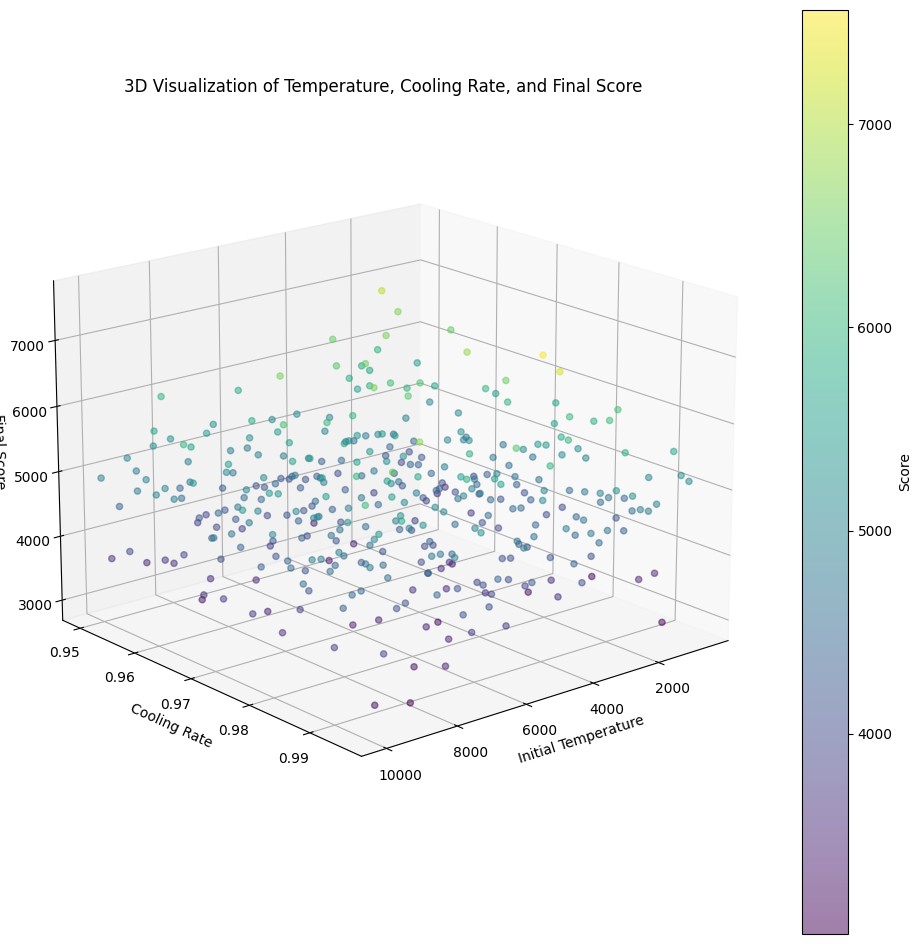

In [46]:
temp_series = all_df.iloc[:, 1]
coolrate_series = all_df.iloc[:, 2]
score_series = all_df.iloc[:, 3]
computetime_series = all_df.iloc[:,4]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=18, azim=50)

# Scatter plot using the temperature, cooling_rate, and score and with color-mapped points
sc = ax.scatter(temp_series, coolrate_series, score_series, c=score_series, cmap='viridis', marker='o', alpha=0.5)

# Add a colorbar to represent the mapping
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Score')  # you can set the label to represent the values being color-mapped

# Label the axes
ax.set_xlabel('Initial Temperature')
ax.set_ylabel('Cooling Rate')
ax.set_zlabel('Final Score')

# Set the title
ax.set_title('3D Visualization of Temperature, Cooling Rate, and Final Score')

# Show the plot
plt.show()


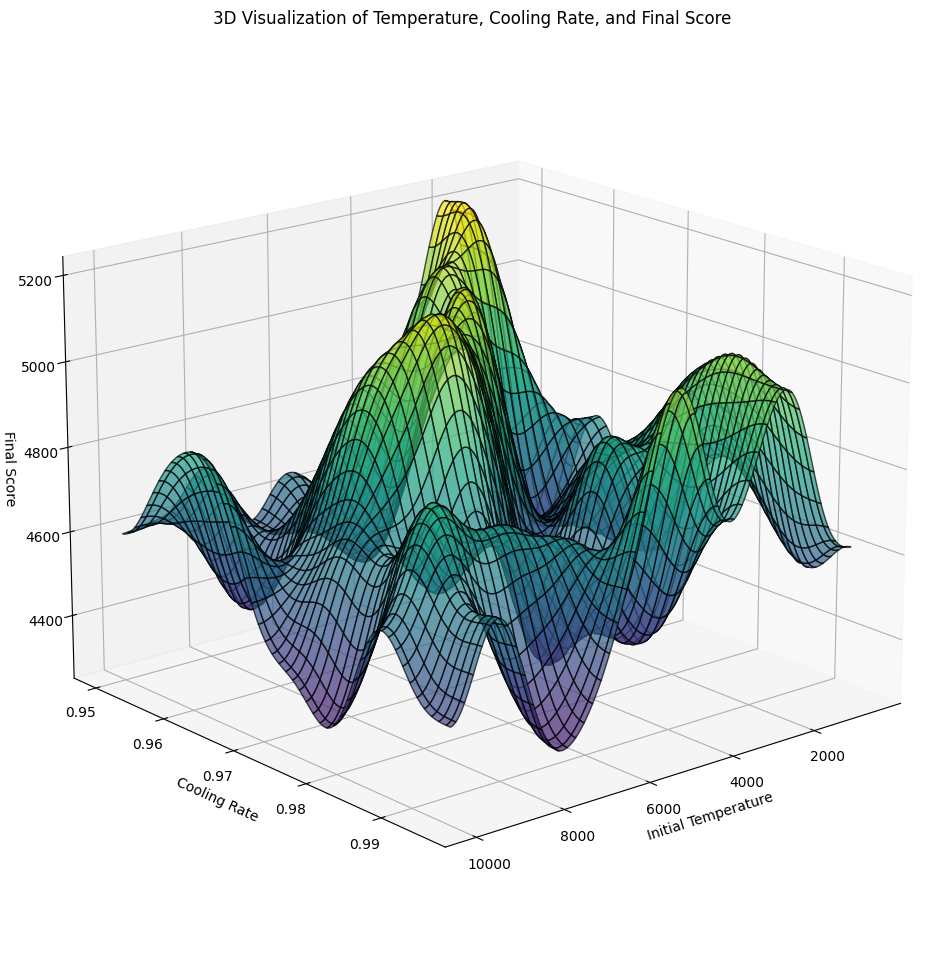

In [48]:
# VERY smoothed as the data is very noisy

#all_df.to_csv
temp_series = all_df.iloc[:,1]
coolrate_series = all_df.iloc[:,2]
score_series = all_df.iloc[:,3]

# Create a grid covering the range of temperature and cooling_rate
xi, yi = np.meshgrid(np.linspace(temp_series.min(), temp_series.max(), len(temp_series)),
                     np.linspace(coolrate_series.min(), coolrate_series.max(), len(coolrate_series)))

# Interpolate scattered data to grid using cubic interpolation
zi = griddata((temp_series, coolrate_series), score_series, (xi, yi), method='cubic')
zi_smoothed = gaussian_filter(zi, sigma=25)

fig = plt.figure(figsize=(12, 12)) 
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=18, azim=50)

# Scatter plot using the temperature, cooling_rate, and score
#ax.scatter(temp_series, coolrate_series, score_series, c='blue', marker='o', alpha=0.6)

ax.plot_surface(xi, yi, zi_smoothed, cmap='viridis', alpha=0.7, edgecolor='black')

# Label the axes
ax.set_xlabel('Initial Temperature')
ax.set_ylabel('Cooling Rate')
ax.set_zlabel('Final Score')

# Set the title
ax.set_title('3D Visualization of Temperature, Cooling Rate, and Final Score')

# Show the plot
plt.show()

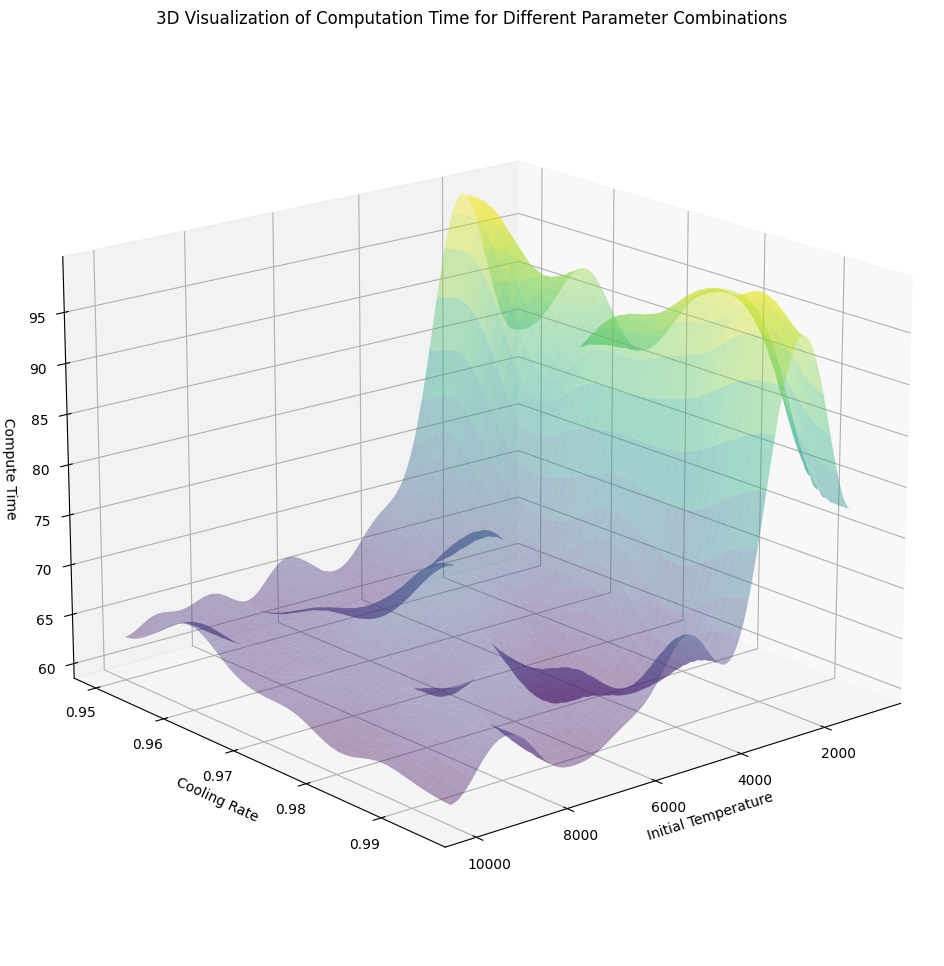

In [32]:
# OUT OF INTEREST, let's also plot the computational time (in seconds) 
# for each trial instead of the score, on the same set of axis, 
# to see if we can infer any correlation (there shouldn't be any)

temp_series = all_df.iloc[:,1]
coolrate_series = all_df.iloc[:,2]
computetime_series = all_df.iloc[:,4]

# Create a grid covering the range of temperature and cooling_rate
xi, yi = np.meshgrid(np.linspace(800, temp_series.max(), len(temp_series)),
                     np.linspace(coolrate_series.min(), coolrate_series.max(), len(coolrate_series)))

# Interpolate scattered data to grid using cubic interpolation
zi = griddata((temp_series, coolrate_series), computetime_series, (xi, yi), method='cubic')
zi_smoothed = gaussian_filter(zi, sigma=20)

fig = plt.figure(figsize=(12, 12)) 
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=18, azim=50)

ax.plot_surface(xi, yi, zi_smoothed, cmap='viridis', alpha=0.4, edgecolor='none')

# Label the axes
ax.set_xlabel('Initial Temperature')
ax.set_ylabel('Cooling Rate')
ax.set_zlabel('Compute Time')

# Plot a dashed line on the x-axis at the initial temperature
ax.axvline(x=2000, color='red', linestyle='--')

# Set the title
ax.set_title('3D Visualization of Computation Time for Different Parameter Combinations')

# Show the plot
plt.show()

What I like about this, is that you can see the time that I plugged in my MacBook

The compute time seems to be much more strongly related to the initial temperature and not dependent on the cooling rate. 

There is a STEEP dropoff above an inital temperature of ~2000

This can be explained by very high initial temperatures essentially causing the 

# Zooming in: progression of the board during each training
How does it progress over time... 
First, we keep initial temperature fixed and vary the cooling rate
We start with a trivial example. Let's look at the first trial (out of 100) 

`Parameters | initial temperature: x, cooling rate: y`

Clearly, the board started 'bad' and then improved over each iteration, eventually asymptoting as it settles into its local minima

**Now** lets see how the shape of this training curve changes, as the cooling rate changes (the initial temperature remains fixed at x)

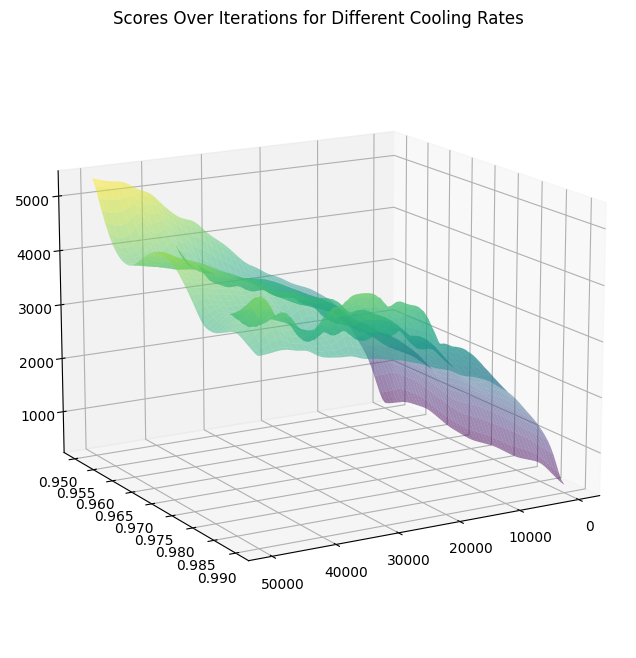

In [49]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

init_temp = 500.0
num_iters = 50000

# Collecting the data for the surface
x_data, y_data, z_data = [], [], []

for rate in np.arange(0.95, 0.994, 0.005):
    rate_val = round(rate, 3)
    filename = f"{init_temp}_{rate_val}_{num_iters}_results.csv"
    temp_df = pd.read_csv(filename)
    rate_series = [rate_val] * num_iters
    
    # Take every 100th iteration
    selected_iterations = temp_df['Iterations'][::10]
    selected_scores = temp_df['Scores'][::10]
    rate_series = [rate_val] * len(selected_iterations)
    
    x_data.extend(selected_iterations)
    y_data.extend(rate_series)
    z_data.extend(selected_scores)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=15, azim=60)

# Define a grid and interpolate data onto the grid
xi, yi = np.linspace(min(x_data), max(x_data), 100), np.linspace(min(y_data), max(y_data), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x_data, y_data), z_data, (xi, yi), method='linear')

# Apply a Gaussian filter to smooth the data
zi_smooth = gaussian_filter(zi, sigma=2)

# Creating the smoothed surface plot
ax.plot_surface(xi, yi, zi_smooth, cmap='viridis', alpha=0.5)

plt.title('Scores Over Iterations for Different Cooling Rates')


'''
# Generate mp4
# Function to update the view angle
def update(frame):
    ax.view_init(elev=10, azim=frame)
    return fig,

# Create an animation that rotates the plot by 360 degrees
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=50)

# Save the animation as a video file
ani.save('3d_rotation_new.gif', writer='pillow')
'''

plt.show()

Now, using matplotlib's animation library, we are going to slowly raise the initial temperature and see how this distribution changes as a whole

Interpretation:
- cooling rate low is good

# Ending: the best solution we can compute
Using the estimated 'optimal' parameter combinations of:
(latex), now we run a deep-iteration training (who knows whether the parameters will remain optimal for this iteration level)
Estimated run time is about: 1 hours (we could go longer but it platques) 

In [4]:
# Final result:

# Use derivatives to approximate the best hyperparameter pair

# Run a deep simulation for 1 million iterations

# Yields: 

# Extension: How robust is this solution (and in general) - this is more an exploration of the nature of the problem itself
- We will pick a 5x5 centre region of the board - (since the ball starts at 10, 10) (gif to explain this) 
- one 'trial' consists of:
    - picking a random square of out of these 25
    - randomly changing the arrow's direction (it will always change)
- we will repeat this $n$ times and then plot the $n$ changes in scores on a histogram (0 = score didn't change)